# Analysis of minimal pairs and homophones


In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils
import src.config as config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2),
            'mean_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].mean(), 4),
            'max_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].max(), 2),
            'total_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
        mean_mp_hp.append(lex_stats['mean_mp_w_hp'])
        max_mp_hp.append(lex_stats['max_mp_w_hp'])
        total_mp_hp.append(lex_stats['total_mp_w_hp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp,
            'mean_mp_w_hp': mean_mp_hp,
            'max_mp_w_hp': max_mp_hp,
            'total_mp_w_hp': total_mp_hp
           }
    

In [6]:
def plot_real_vs_art(art_dist, real_value, statistic, language, ylabel="Count"):
    """Compare distribution of test statistics from artificial lexicon to real lexicon."""
    
    print("Mean of artificial: {x}.".format(x=statistics.mean(art_dist)))
    print("Median of artificial: {x}.".format(x=statistics.median(art_dist)))
    print("Standard deviation of artificial: {x}.".format(x=statistics.stdev(art_dist)))
    print("Range of artificial: ({x}, {y}).".format(x=min(art_dist), y=max(art_dist)))
    print("Real value: {x}.".format(x=real_value))
    
    plt.hist(art_dist)
    plt.title("{lan}: {x} (real vs. artificial)".format(lan=language, x=statistic))
    plt.xlabel(statistic)
    plt.ylabel(ylabel)
    plt.axvline(x=real_value, linestyle="dotted", color="red")
    # plt.axvline(x=0, linestyle="dashed", color="blue")

In [7]:
def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word"):
    """Loads lexicons for a given language."""
    df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps.csv".format(lan1=language,
                                                                                         lan2=language))
    df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction.csv".format(lan1=language,
                                                                                                                           lan2=language))
    return df_real, df_real_processed, df_artificials
    

In [8]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    real_r2 = result_real.prsquared
    params['pr2'] = real_r2
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        fake_r2 = result_fake.prsquared
        params = result_fake.params
        params['real'] = "No"
        params['pr2'] = fake_r2
        coefs.append(params)
    
    return pd.DataFrame(coefs)

In [9]:
def process_stats(df_real, list_of_fakes, formula, covariates, covariate_labels, language):
    """Pipeline for processing and plotting stats results."""
    
    df_stats = analyze_stats(df_real, list_of_fakes, formula=formula, covariates=covariates)
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for index, cov in enumerate(COVARIATES):
        ax = fig.add_subplot(len(COVARIATES)+1, 1, index+1)

        real_value = df_stats[df_stats['real']=="Yes"][cov].values[0]
        art_values = df_stats[df_stats['real']=="No"][cov].values

        ax.hist(art_values)
        ax.axvline(x=real_value, linestyle="dotted", color="red")
        ax.axvline(x=0, linestyle="dashed")
        ax.text(s="Real coef: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)

        plt.title("{lan}: coefficient for {cov}".format(lan=language, cov=COVARIATE_LABELS[index]))


    # Now add pr2
    ax = fig.add_subplot(len(COVARIATES)+1, 1, index+2)
    real_value = df_stats[df_stats['real']=="Yes"]['pr2'].values[0]
    art_values = df_stats[df_stats['real']=="No"]['pr2'].values
    ax.hist(art_values)
    ax.axvline(x=real_value, linestyle="dotted", color="red")
    ax.axvline(x=0, linestyle="dashed")
    ax.text(s="Real R^2: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)
    plt.title("{lan}: Pseudo R^2".format(lan=language, cov=COVARIATE_LABELS[index]))
    
    fig.subplots_adjust(hspace=.5)
    
    target = formula.split(" ~")[0]
    regressors = ' '.join(covariates)
    plt.savefig("Figures/{l1}/{l2}_stats_{target}_{regressors}.png".format(l1=language,
                                                                           l2=language,
                                                                           target=target,
                                                                           regressors=regressors), 
                dpi=300)
    
    # Now save individual versions
    
    overall_stats = []

    ### Set up directories
    if not os.path.exists("Figures/{lan}/individual_plots".format(lan=language)):
        print("Figures/{lan}/individual_plots".format(lan=language))
        os.mkdir("Figures/{lan}/individual_plots".format(lan=language))
    for index, cov in enumerate(COVARIATES):
        fig = plt.figure()
        fig.set_figwidth(9)
        real_value = df_stats[df_stats['real']=="Yes"][cov].values[0]
        art_values = df_stats[df_stats['real']=="No"][cov].values

        overall_stats.append({
            'value': cov,
            'artificial mean': round(statistics.mean(art_values), 3),
            'artificial median': round(statistics.median(art_values), 3),
            'artificial sd': round(statistics.stdev(art_values), 3),
            'artificial min': round(min(art_values), 3),
            'artificial max': round(min(art_values), 3),
            'real value': round(real_value, 3),
            'language': language
        })
        
        plt.hist(art_values)
        plt.axvline(x=real_value, linestyle="dotted", color="red")
        plt.axvline(x=0, linestyle="dashed")
        plt.text(s="Real coef: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)

        plt.title("{lan}: coefficient for {cov}".format(lan=language, cov=COVARIATE_LABELS[index]))
        if not os.path.exists("Figures/{lan}/individual_plots/{cov}".format(lan=language, cov=cov)):
            print("Figures/{lan}/individual_plots/{cov}".format(lan=language, cov=cov))
            os.mkdir("Figures/{lan}/individual_plots/{cov}".format(lan=language, cov=cov))
        plt.savefig("Figures/{l1}/individual_plots/{cov1}/{l2}_{target}_{cov2}_{regressors}.png".format(l1=language,
                                                                                                       cov1=cov,
                                                                                   l2=language,
                                                                                   target=target,
                                                                                   cov2=cov,
                                                                                   regressors=regressors), 
                    dpi=300)
        plt.close(fig)
    
    # Now do pr2
    fig = plt.figure()
    fig.set_figwidth(9)
    real_value = df_stats[df_stats['real']=="Yes"]['pr2'].values[0]
    art_values = df_stats[df_stats['real']=="No"]['pr2'].values

    overall_stats.append({
        'value': 'r2',
        'artificial mean': round(statistics.mean(art_values), 3),
        'artificial median': round(statistics.median(art_values), 3),
        'artificial sd': round(statistics.stdev(art_values), 3),
        'artificial min': round(min(art_values), 3),
        'artificial max': round(min(art_values), 3),
        'real value': round(real_value, 3),
        'language': language
    })
    
    plt.hist(art_values)
    plt.axvline(x=real_value, linestyle="dotted", color="red")
    plt.axvline(x=0, linestyle="dashed")
    plt.text(s="Real R^2: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)

    plt.title("{lan}: Pseudo R^2".format(lan=language, cov=COVARIATE_LABELS[index]))

    plt.savefig("Figures/{l1}/individual_plots/{l2}_{target}_r2_{regressors}.png".format(l1=language,
                                                                               l2=language,
                                                                               target=target,
                                                                               cov=cov,
                                                                               regressors=regressors), 
                dpi=300)
    plt.close(fig)
    
    
    df_overall_stats = pd.DataFrame(overall_stats)    
    return df_overall_stats

## Predictions

In each case, we'll be comparing some test statistic (max # homophones per word, coefficient for *surprisal*, etc.) across the real and the artificial lexica. The critical question is whether the test statistic in the real lexicon exceeds (in the expected direction) the distribution of values from the artificial lexica.

Here's a couple of examples below.

In [10]:
np.random.seed(42)

In [11]:
real_value = -.8

Mean of artificial: -0.49551938888301245.
Median of artificial: -0.494803629017014.
Standard deviation of artificial: 0.007230083334490977.
Range of artificial: (-0.5046947438593495, -0.4842078718449261).
Real value: -0.8.


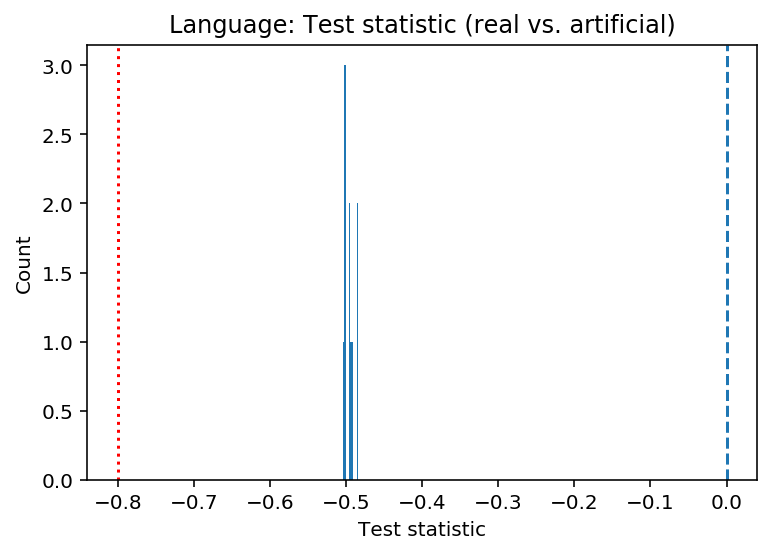

In [69]:
# Here's what it should look like if the real lexica explains *more* variance.
art_dist = np.random.normal(loc=-.5, scale=.01, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
plt.axvline(0, linestyle="dashed")
plt.savefig("Figures/predictions/stats/real_wins.png", dpi=300)

Mean of artificial: -0.8079065823458241.
Median of artificial: -0.8073515580238109.
Standard deviation of artificial: 0.007553247486313904.
Range of artificial: (-0.819132802446578, -0.7968575266740473).
Real value: -0.8.


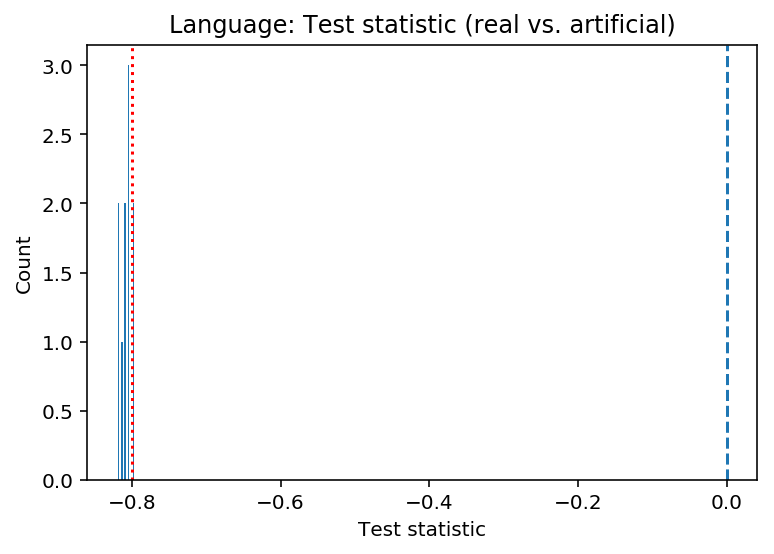

In [13]:
# Here's what it should look like if the real lexica falls squarely in the middle of the artificial distribution.
art_dist = np.random.normal(loc=-.8, scale=.01, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/stats/real_same.png", dpi=300)

Mean of artificial: -1.0022184356466945.
Median of artificial: -1.0025873502513991.
Standard deviation of artificial: 0.008138978027450198.
Range of artificial: (-1.0142474818621345, -0.9853435123107844).
Real value: -0.8.


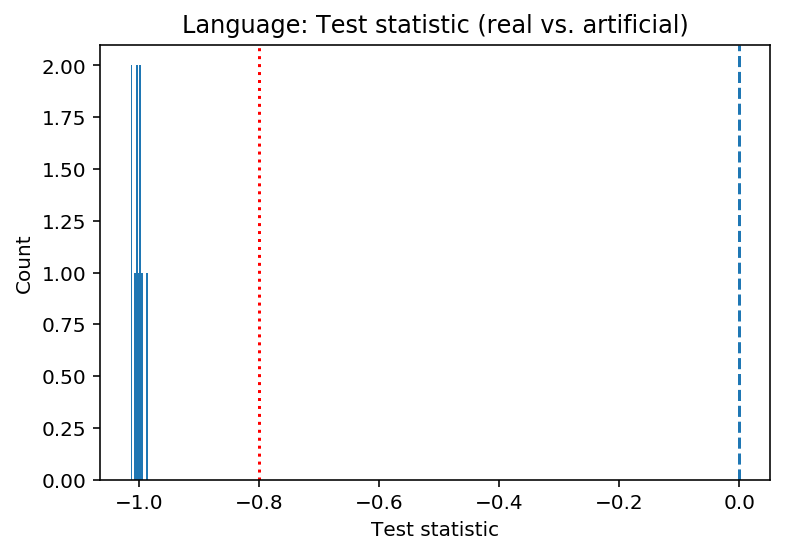

In [14]:
# And here's what it would look like if the real lexica is actually *less* efficient.
art_dist = np.random.normal(loc=-1, scale=.01, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/stats/real_loses.png", dpi=300)

In [15]:
real_value = 20

Mean of artificial: 9.379786667762708.
Median of artificial: 9.384796163032668.
Standard deviation of artificial: 2.290469270998851.
Range of artificial: (6.080659752240448, 13.704556369017876).
Real value: 20.


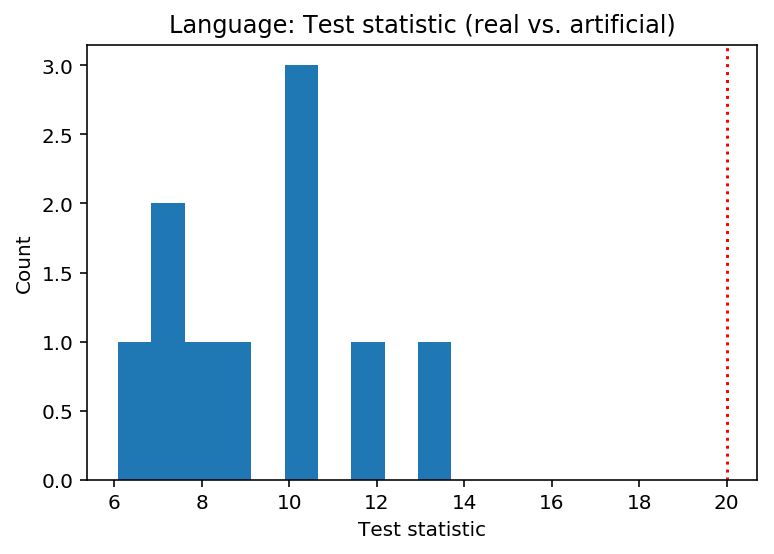

In [16]:
# Here's what it should look like if the real lexica explains *more* variance.
art_dist = np.random.normal(loc=10, scale=2, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
# plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/descriptive/real_wins.png", dpi=300)

Mean of artificial: 19.494355654782115.
Median of artificial: 19.58324802202247.
Standard deviation of artificial: 1.8012131696710774.
Range of artificial: (16.47391968927453, 22.11424445243783).
Real value: 20.


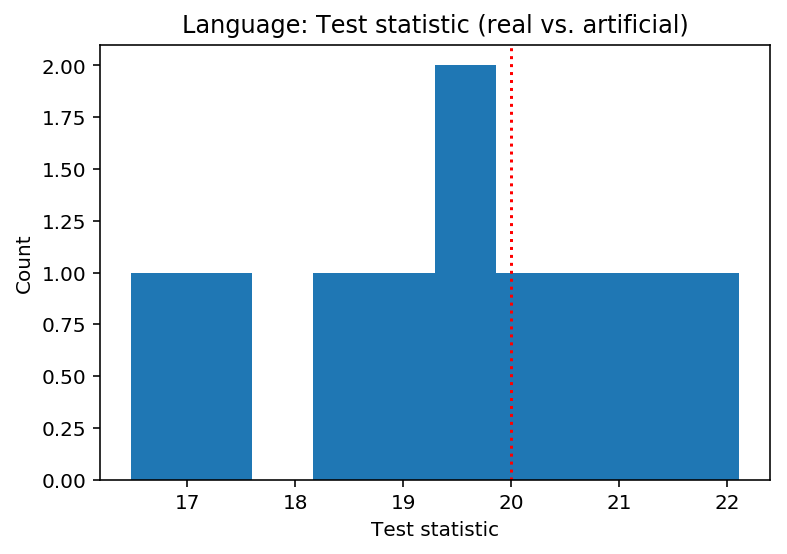

In [17]:
# Here's what it should look like if the real lexica falls squarely in the middle of the artificial distribution.
art_dist = np.random.normal(loc=20, scale=2, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
# plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/descriptive/real_same.png", dpi=300)

Mean of artificial: 30.39888285571552.
Median of artificial: 30.65534740079836.
Standard deviation of artificial: 1.4109864167591166.
Range of artificial: (28.321564953554724, 32.0619990449919).
Real value: 20.


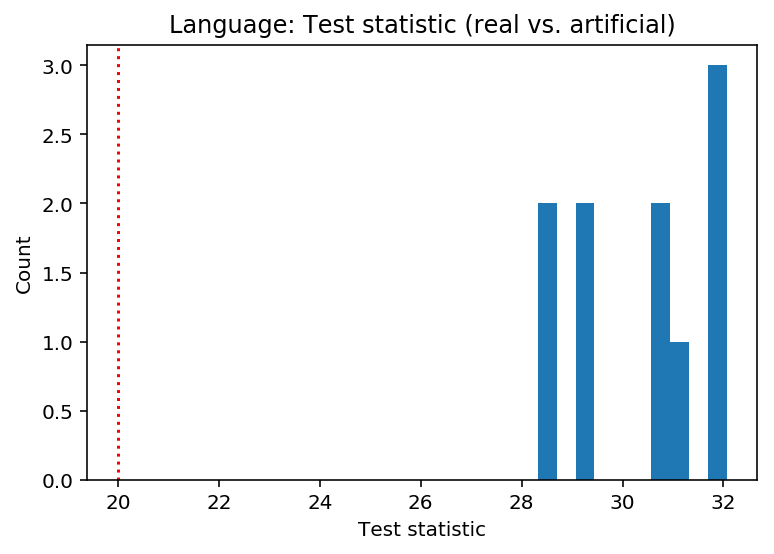

In [18]:
# And here's what it would look like if the real lexica is actually *less* efficient.
art_dist = np.random.normal(loc=30, scale=2, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
# plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/descriptive/real_loses.png", dpi=300)

## English

In [72]:
df_celex, df_celex_processed, df_english_artificials = load_lexicons_for_language("english")

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [73]:
len(df_celex)

52438

In [74]:
len(df_celex_processed)

35107

In [75]:
df_english_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [76]:
info_for_english = process_and_extract_artificials(df_english_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


In [77]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [78]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

### `#homophones` ~ `rank_homophones`

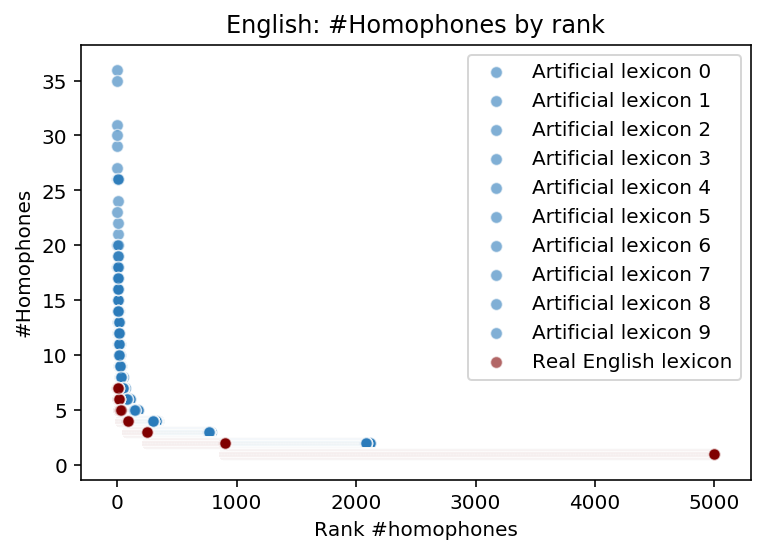

In [84]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<5000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<5000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real English lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("English: #Homophones by rank")

plt.savefig("Figures/english/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

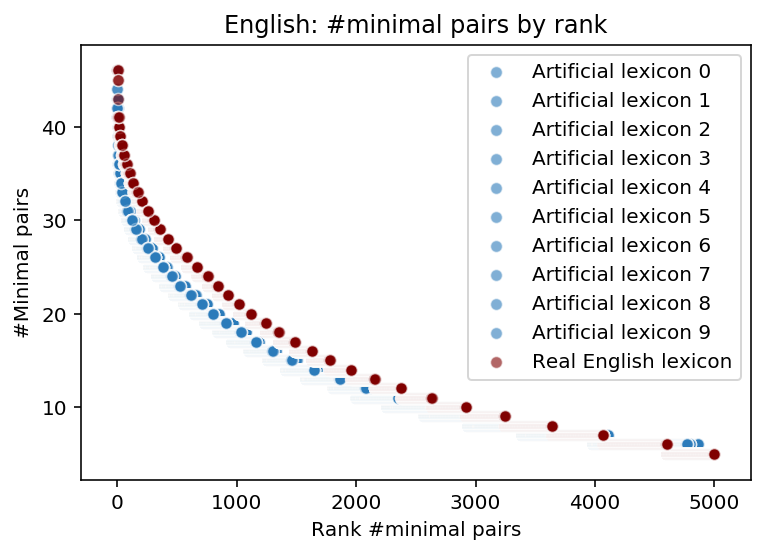

In [85]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<5000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<5000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real English lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("English: #minimal pairs by rank")

plt.savefig("Figures/english/data_visualizations/rank_neighborhoods.png", dpi=300)

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), there are more minimal pairs in the real lexicon than in the artificial English lexicons, whether or not homophones are included. The same goes for the **mean** neighborhood size per word.

There are also larger **max** neighborhoods in English, but only when not counting homophones in neighborhood size. When homophones are included, the artificial lexicons have larger neighborhoods––presumably because there are much larger numbers of homophones per wordform in the artificial lexicons.

Mean of artificial: 2.15516.
Median of artificial: 2.1584.
Standard deviation of artificial: 0.020957745849950374.
Range of artificial: (2.1165, 2.1816).
Real value: 2.5598.


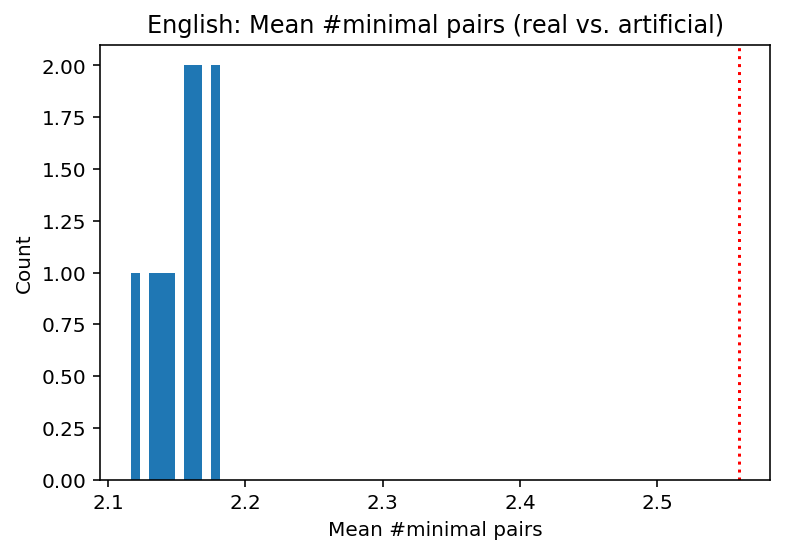

In [28]:
plot_real_vs_art(info_for_english['mean_mp'], df_english_stats['mean_mp'],
                'Mean #minimal pairs', language="English")

Mean of artificial: 3.71773.
Median of artificial: 3.7131.
Standard deviation of artificial: 0.02535030352656333.
Range of artificial: (3.6834, 3.764).
Real value: 4.3281.


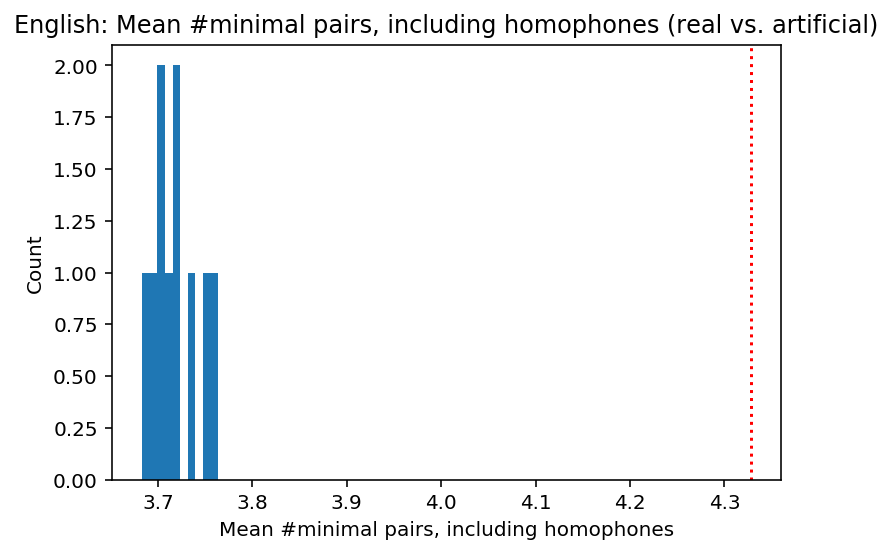

In [29]:
plot_real_vs_art(info_for_english['mean_mp_w_hp'], df_english_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="English")

Mean of artificial: 43.
Median of artificial: 42.5.
Standard deviation of artificial: 1.7320508075688772.
Range of artificial: (41, 46).
Real value: 46.


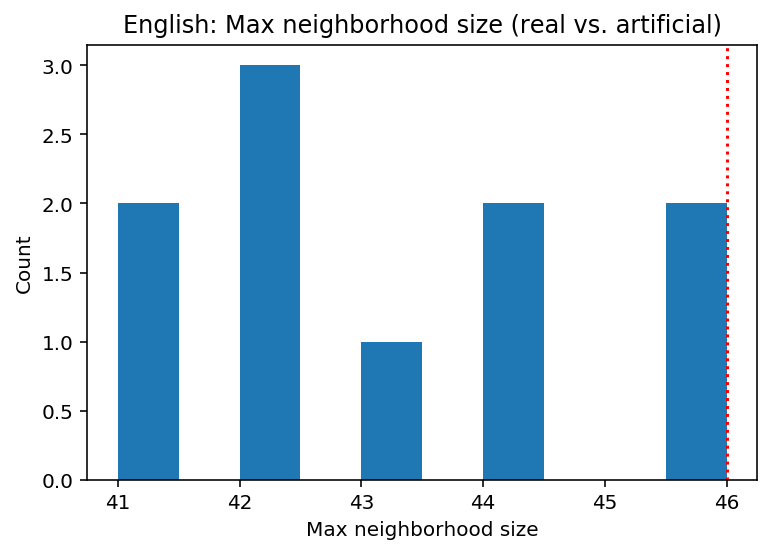

In [30]:
plot_real_vs_art(info_for_english['max_mp'], df_english_stats['max_mp'],
                'Max neighborhood size', language="English")

Mean of artificial: 101.
Median of artificial: 102.5.
Standard deviation of artificial: 7.211102550927978.
Range of artificial: (89, 113).
Real value: 127.


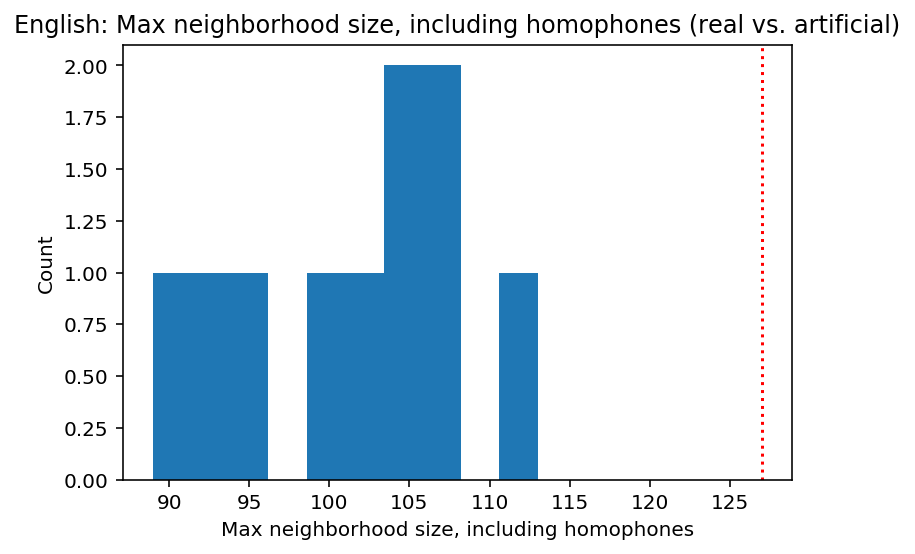

In [31]:
plot_real_vs_art(info_for_english['max_mp_w_hp'], df_english_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="English")

Mean of artificial: 91472.
Median of artificial: 91627.0.
Standard deviation of artificial: 924.9464849384531.
Range of artificial: (89686, 92724).
Real value: 89868.


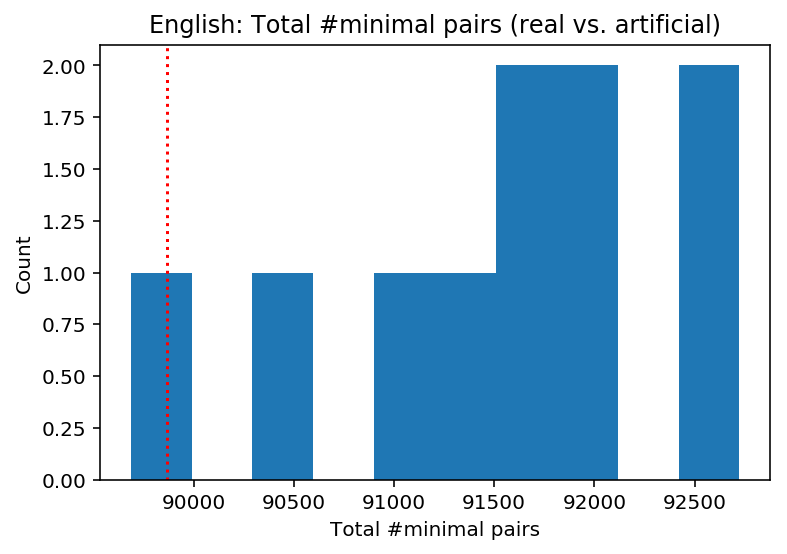

In [32]:
plot_real_vs_art(info_for_english['total_mp'], df_english_stats['total_mp'],
                'Total #minimal pairs', language='English')

Mean of artificial: 157790.
Median of artificial: 157609.5.
Standard deviation of artificial: 1096.1956942079275.
Range of artificial: (156415, 159736).
Real value: 151948.


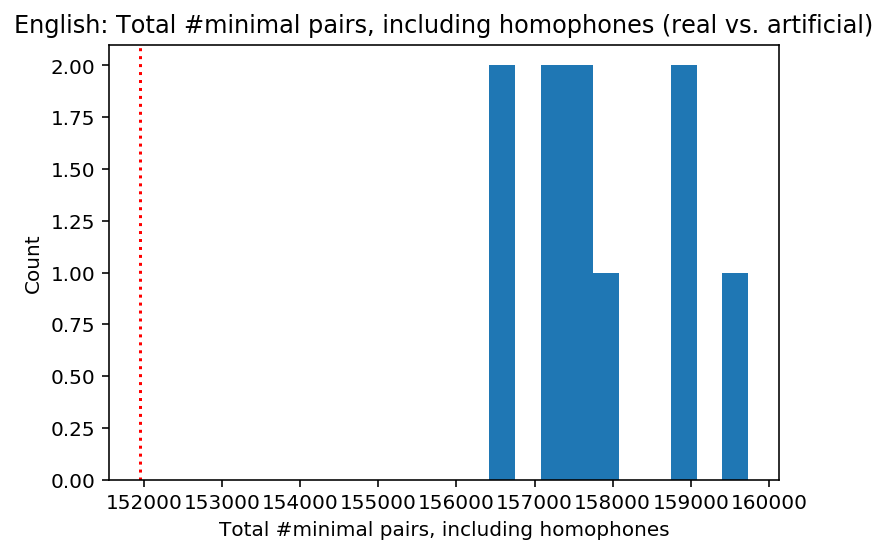

In [33]:
plot_real_vs_art(info_for_english['total_mp_w_hp'], df_english_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='English')

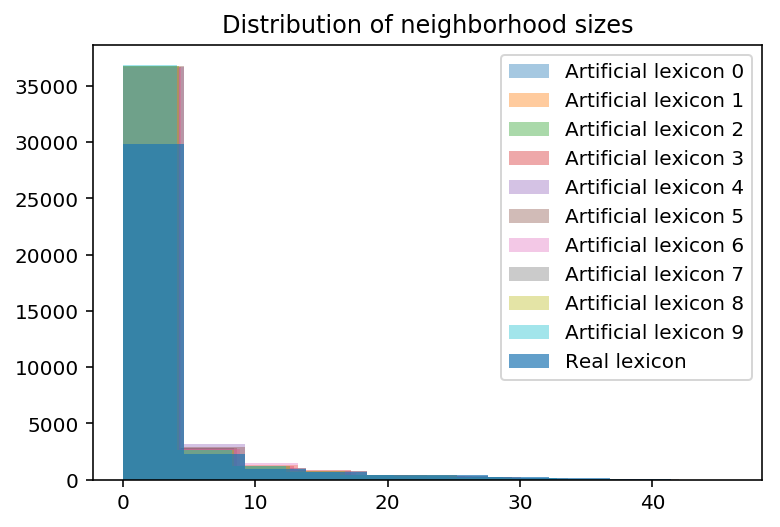

In [34]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

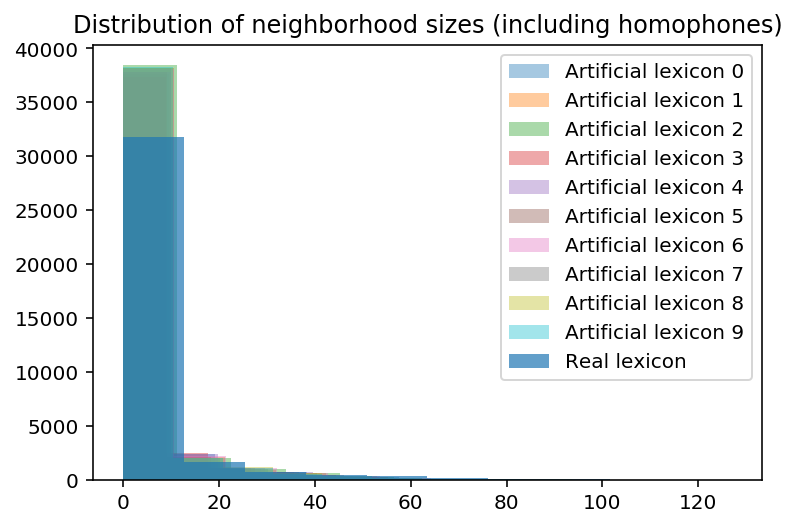

In [35]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes (including homophones)")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 80, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

On the other hand, the real English lexicon has a higher proportion of homophonous wordforms overall.

Mean of artificial: 0.15009.
Median of artificial: 0.1502.
Standard deviation of artificial: 0.0007324995259763337.
Range of artificial: (0.1488, 0.151).
Real value: 0.1564.


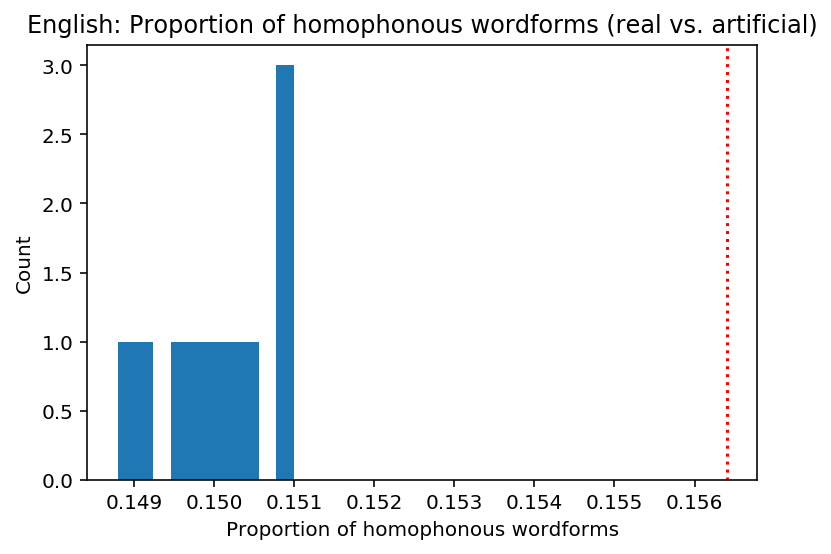

In [36]:
plot_real_vs_art(info_for_english['homophone_percentage'], df_english_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='English')
plt.savefig("Figures/english/english_percent_homophones.png", dpi=300)

Mean of artificial: 0.2355.
Median of artificial: 0.2355.
Standard deviation of artificial: 0.0013029880190461337.
Range of artificial: (0.2335, 0.2375).
Real value: 0.1931.


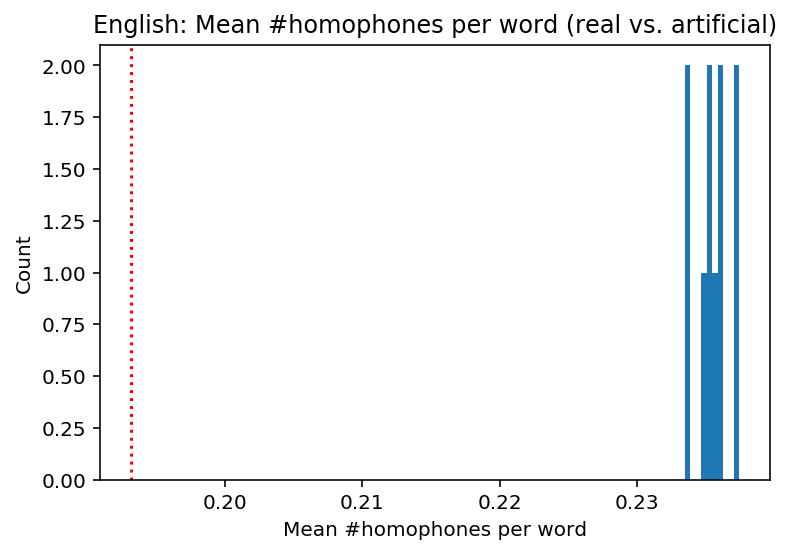

In [37]:
plot_real_vs_art(info_for_english['mean_homophones'], df_english_stats['mean_homophones'],
                'Mean #homophones per word', language='English')
plt.savefig("Figures/english/english_mean_homophones.png", dpi=300)

Mean of artificial: 27.
Median of artificial: 28.0.
Standard deviation of artificial: 5.916079783099616.
Range of artificial: (18, 36).
Real value: 7.


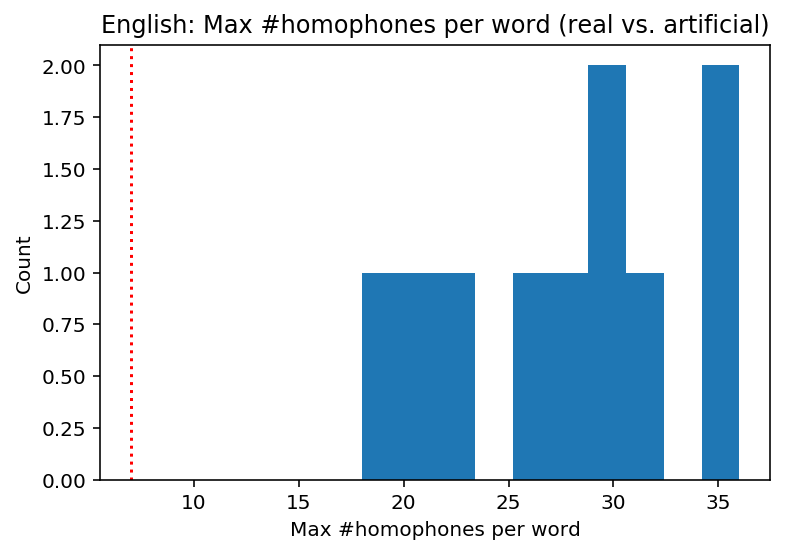

In [38]:
plot_real_vs_art(info_for_english['max_homophones'], df_english_stats['max_homophones'],
                'Max #homophones per word', language='English')
plt.savefig("Figures/english/english_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is larger in artificial lexicons than the real lexicon. This is in contrast to the other analysis. The difference here is that we're also factoring in neighborhood size as a covariate.
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [155]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    # 'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'English'

   artificial max  artificial mean  artificial median  artificial min  \
0       -1.809457        -1.681115          -1.663179       -1.809457   
1       -1.358412        -1.329188          -1.326812       -1.358412   
2        0.157257         0.161683           0.161838        0.157257   

   artificial sd  real value             value  
0       0.057451    0.781546  surprisal_normed  
1       0.016804   -0.717063     num_sylls_est  
2       0.002952    0.142716                r2  


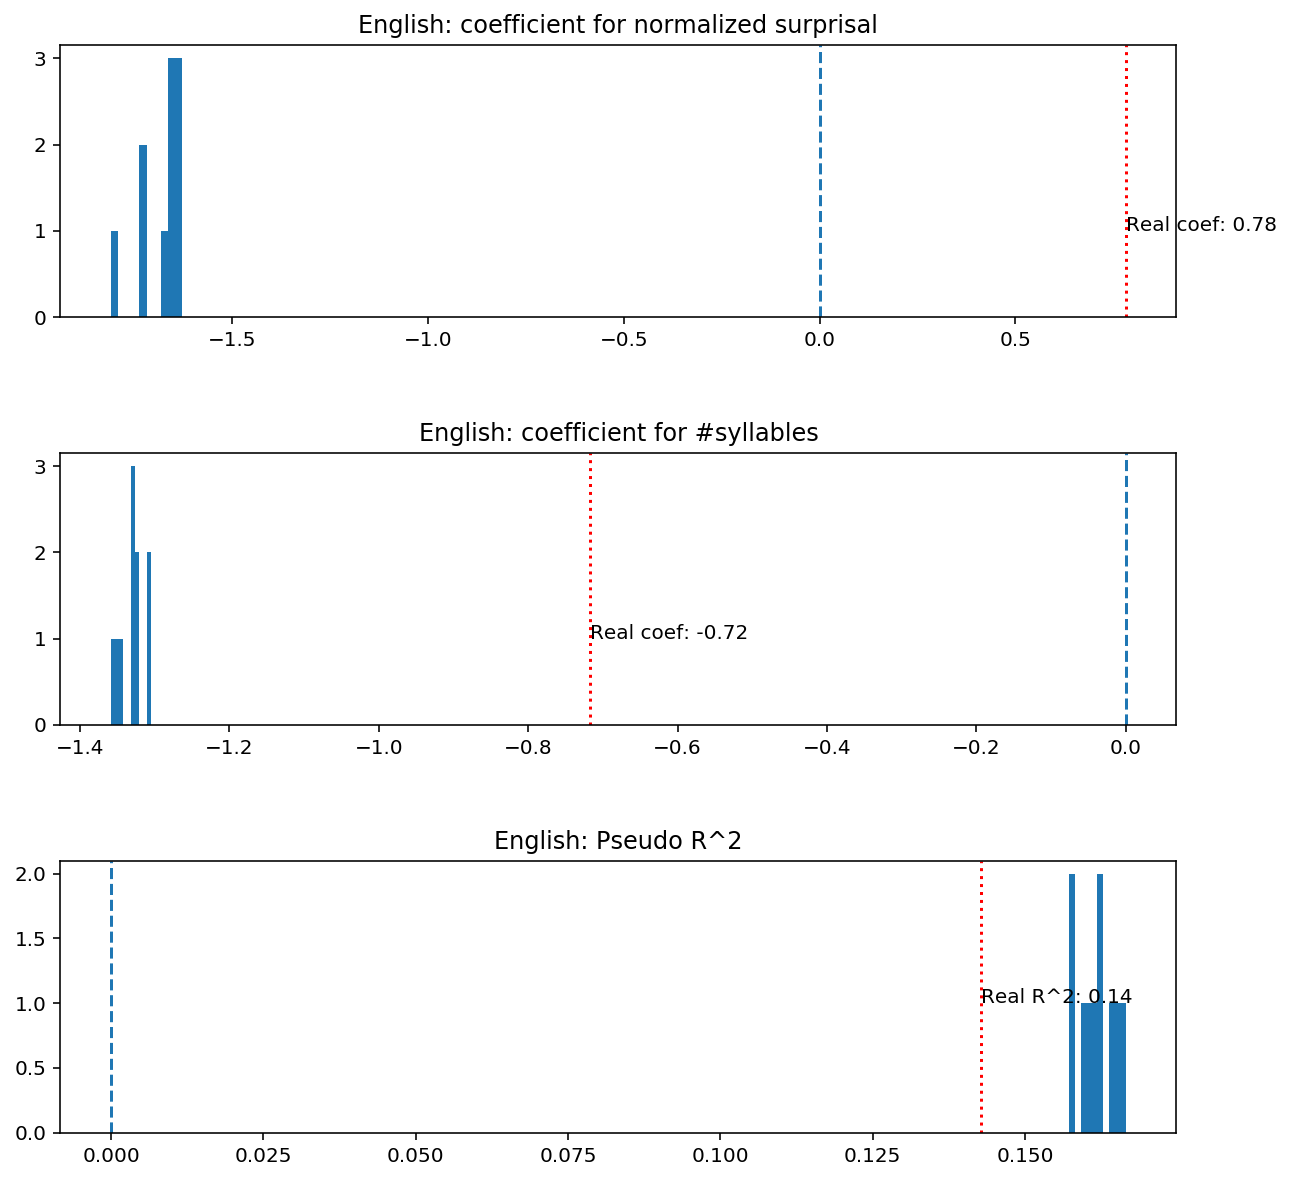

In [158]:
df_english_model1 = process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [160]:
df_english_model1

artificial max  artificial mean  artificial median  artificial min  \
0       -1.809457        -1.681115          -1.663179       -1.809457   
1       -1.358412        -1.329188          -1.326812       -1.358412   
2        0.157257         0.161683           0.161838        0.157257   

   artificial sd  real value             value  
0       0.057451    0.781546  surprisal_normed  
1       0.016804   -0.717063     num_sylls_est  
2       0.002952    0.142716                r2

In [161]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'English'

   artificial max  artificial mean  artificial median  artificial min  \
0       -3.274896        -3.163756          -3.167694       -3.274896   
1       -1.173266        -1.148204          -1.150297       -1.173266   
2        0.098574         0.103200           0.103607        0.098574   
3        0.212541         0.214725           0.214403        0.212541   

   artificial sd  real value              value  
0       0.076805    0.159488   surprisal_normed  
1       0.018822   -0.586026      num_sylls_est  
2       0.003095    0.046494  neighborhood_size  
3       0.001600    0.159365                 r2  


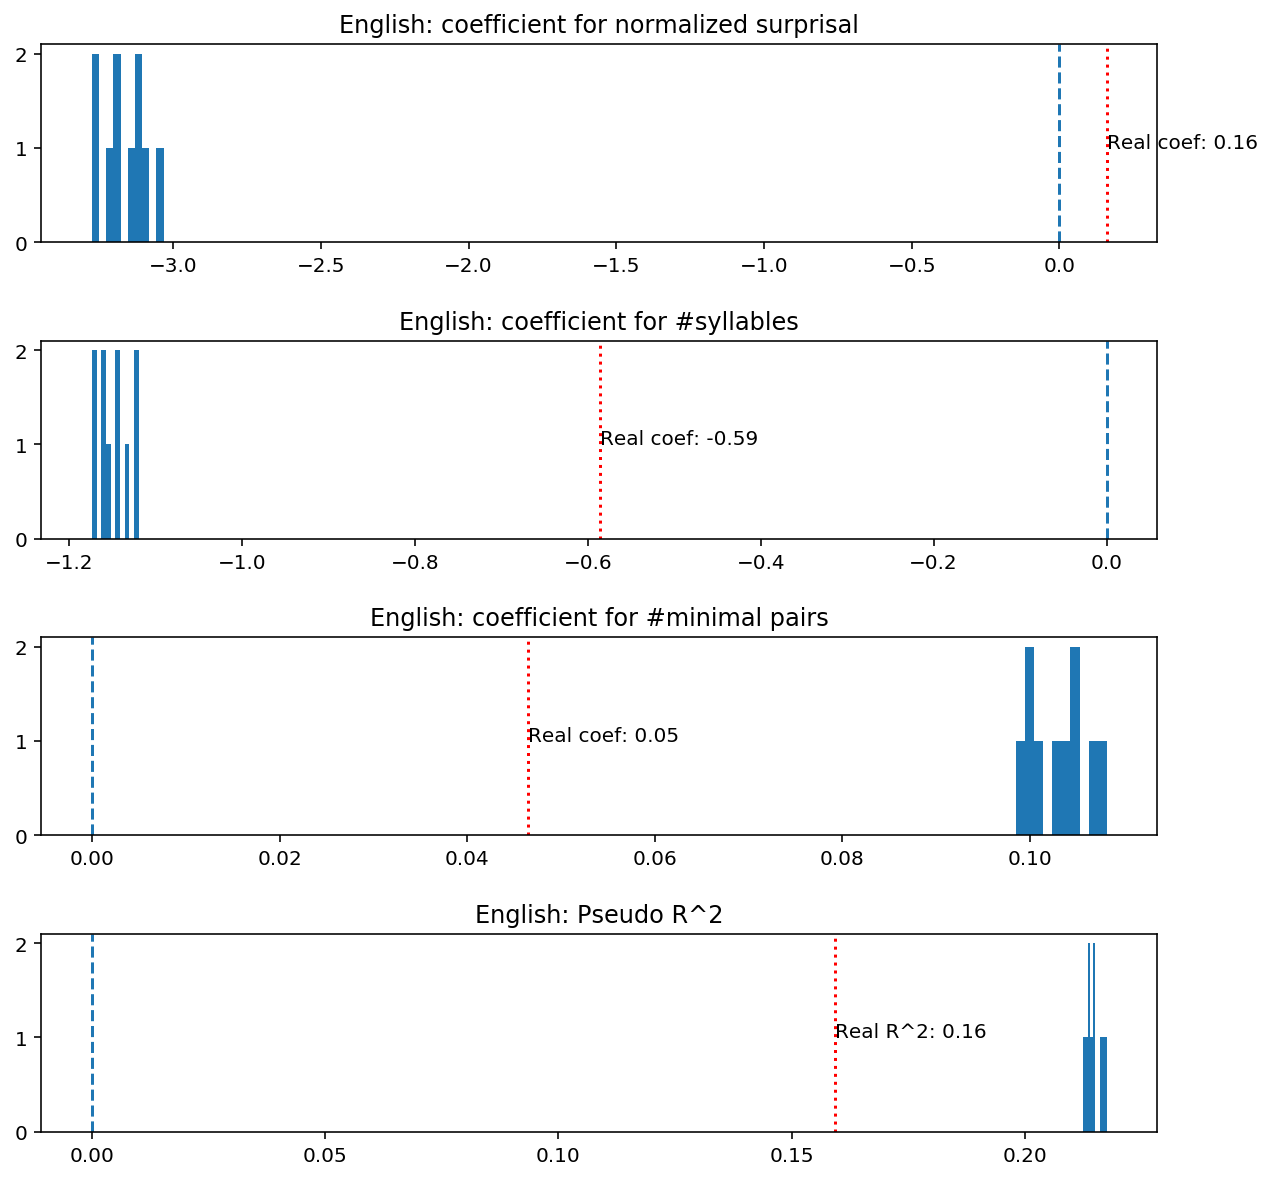

In [162]:
df_english_model2 = process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [163]:
df_english_model2

artificial max  artificial mean  artificial median  artificial min  \
0       -3.274896        -3.163756          -3.167694       -3.274896   
1       -1.173266        -1.148204          -1.150297       -1.173266   
2        0.098574         0.103200           0.103607        0.098574   
3        0.212541         0.214725           0.214403        0.212541   

   artificial sd  real value              value  
0       0.076805    0.159488   surprisal_normed  
1       0.018822   -0.586026      num_sylls_est  
2       0.003095    0.046494  neighborhood_size  
3       0.001600    0.159365                 r2

### Predicting *neighborhood size*

#### Analysis

In [165]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalizd surprisal', 
    '#syllables', 
]
LANGUAGE = 'English'

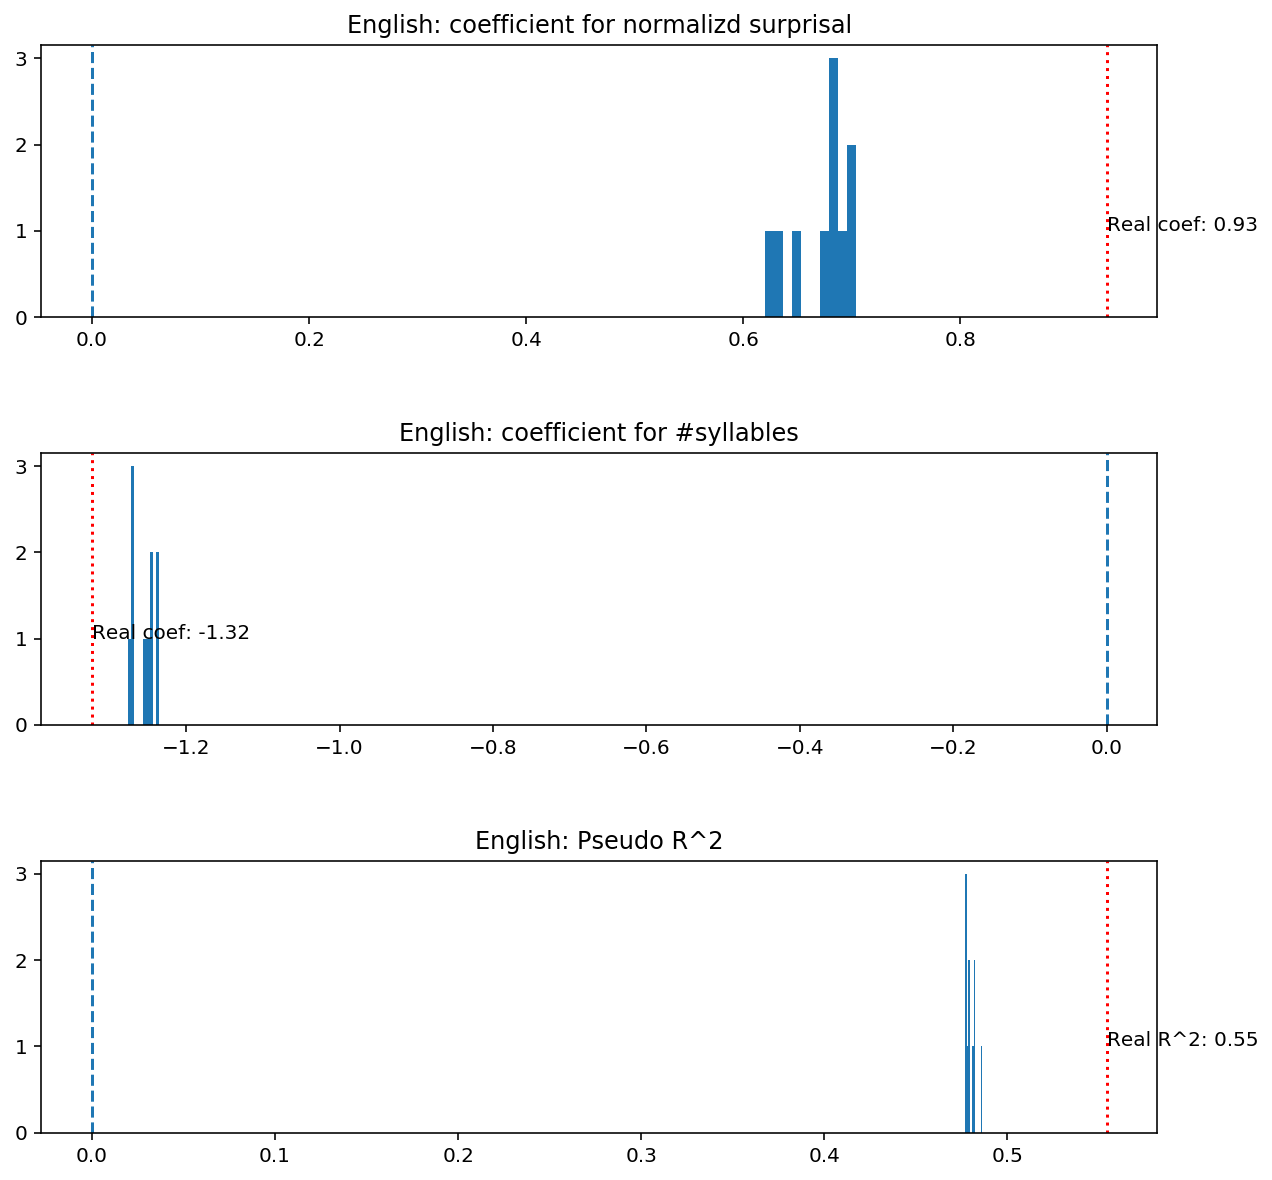

In [166]:
df_english_model3 = process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [167]:
df_english_model3

artificial max  artificial mean  artificial median  artificial min  \
0        0.620133         0.671898           0.682155        0.620133   
1       -1.275337        -1.255149          -1.250731       -1.275337   
2        0.476806         0.479999           0.479204        0.476806   

   artificial sd  real value             value  
0       0.029410    0.934649  surprisal_normed  
1       0.014509   -1.322704     num_sylls_est  
2       0.003089    0.554232                r2

# German

In [45]:
df_celex, df_celex_processed, df_german_artificials = load_lexicons_for_language("german")

In [46]:
len(df_celex)

51719

In [47]:
len(df_celex_processed)

50474

In [48]:
df_german_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [49]:
info_for_german = process_and_extract_artificials(df_german_artificials)

100%|██████████| 10/10 [00:08<00:00,  1.04s/it]


In [50]:
processed_artificials = info_for_german['processed_dataframes']

#### Norm surprisal

In [51]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

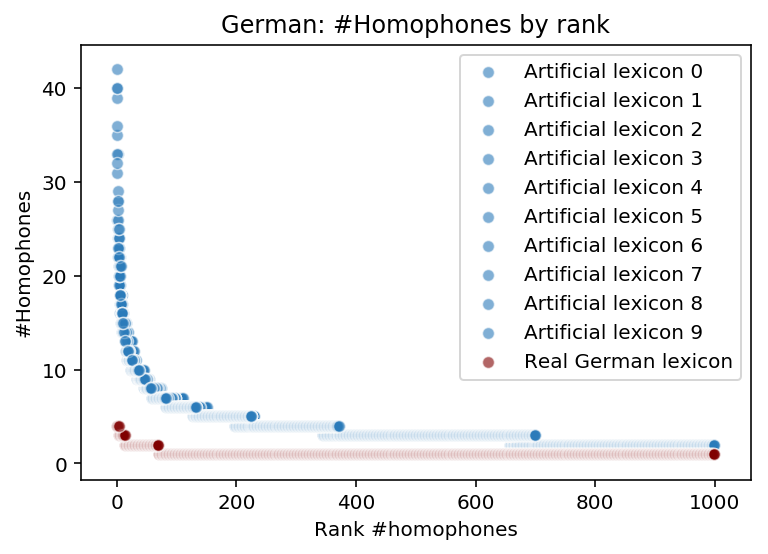

In [52]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real German lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("German: #Homophones by rank")

plt.savefig("Figures/german/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

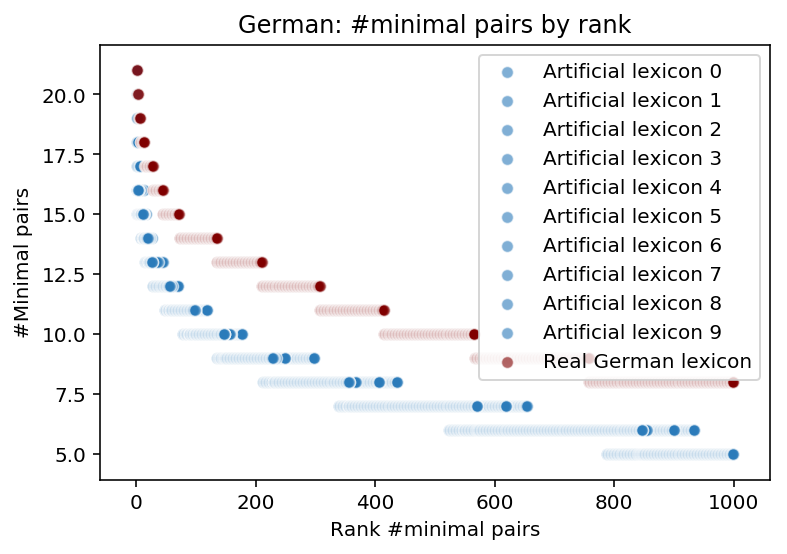

In [53]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real German lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("German: #minimal pairs by rank")

plt.savefig("Figures/german/data_visualizations/rank_neighborhoods.png", dpi=300)

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

Mean of artificial: 0.5458.
Median of artificial: 0.5489999999999999.
Standard deviation of artificial: 0.009914635646356345.
Range of artificial: (0.5298, 0.5576).
Real value: 0.7739.


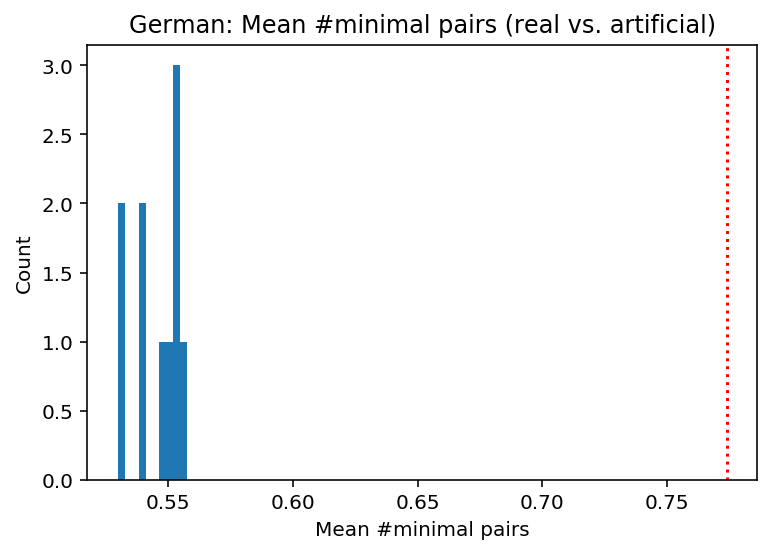

In [54]:
plot_real_vs_art(info_for_german['mean_mp'], df_german_stats['mean_mp'],
                'Mean #minimal pairs', language="German")

Mean of artificial: 0.92588.
Median of artificial: 0.9352.
Standard deviation of artificial: 0.017709244290294635.
Range of artificial: (0.896, 0.9458).
Real value: 0.8549.


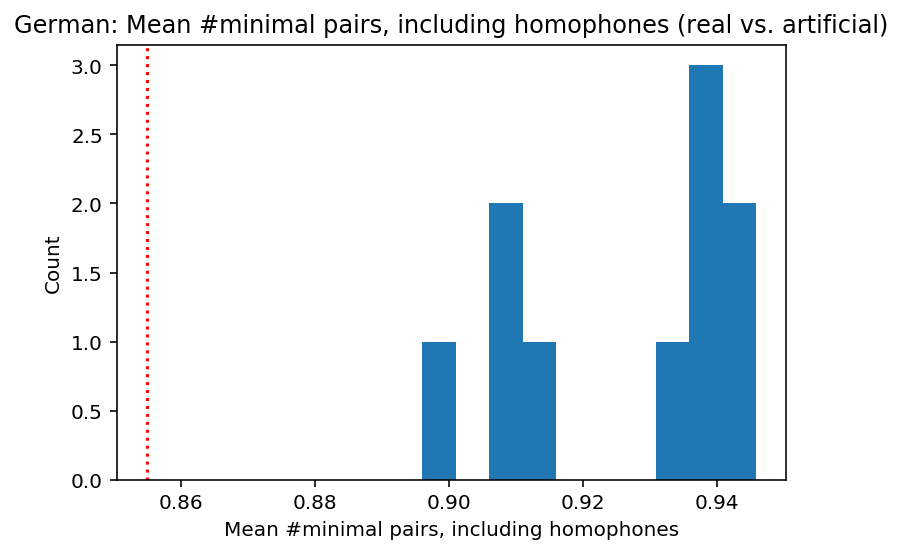

In [55]:
plot_real_vs_art(info_for_german['mean_mp_w_hp'], df_german_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="German")

Mean of artificial: 18.
Median of artificial: 17.5.
Standard deviation of artificial: 1.4142135623730951.
Range of artificial: (16, 21).
Real value: 21.


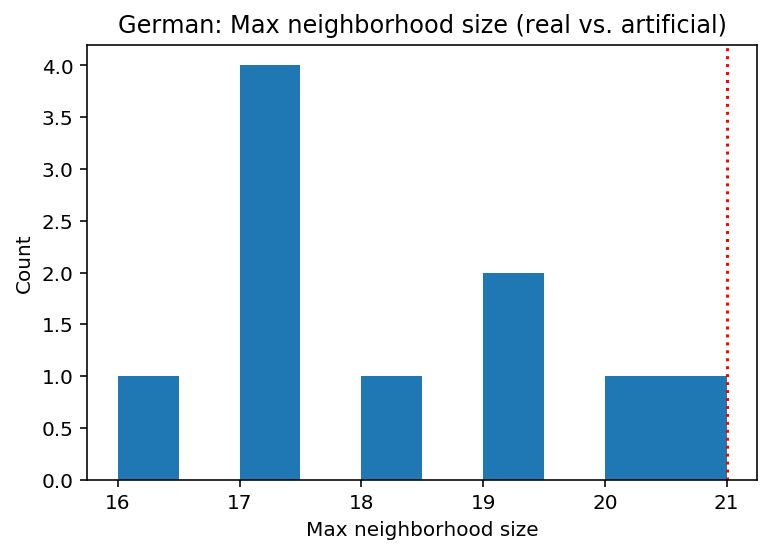

In [56]:
plot_real_vs_art(info_for_german['max_mp'], df_german_stats['max_mp'],
                'Max neighborhood size', language="German")

Mean of artificial: 70.
Median of artificial: 69.5.
Standard deviation of artificial: 6.244997998398398.
Range of artificial: (64, 81).
Real value: 29.


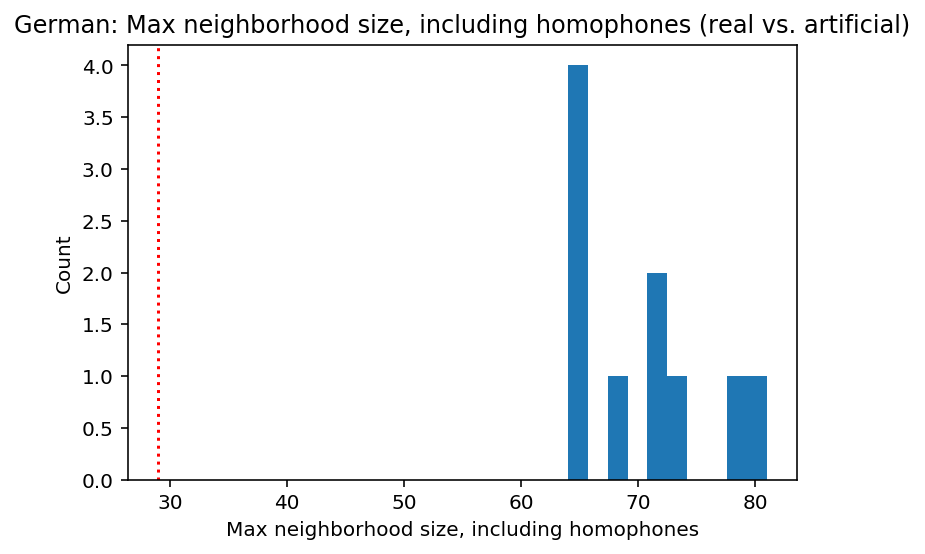

In [57]:
plot_real_vs_art(info_for_german['max_mp_w_hp'], df_german_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="German")

Mean of artificial: 24164.
Median of artificial: 24280.0.
Standard deviation of artificial: 450.9456730028574.
Range of artificial: (23432, 24726).
Real value: 39061.


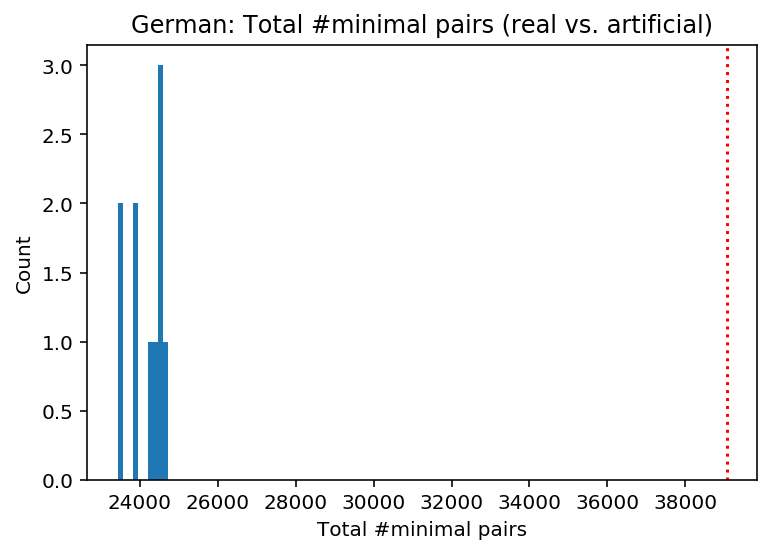

In [58]:
plot_real_vs_art(info_for_german['total_mp'], df_german_stats['total_mp'],
                'Total #minimal pairs', language='German')

Mean of artificial: 40990.
Median of artificial: 41397.5.
Standard deviation of artificial: 798.4510003751013.
Range of artificial: (39657, 41939).
Real value: 43149.


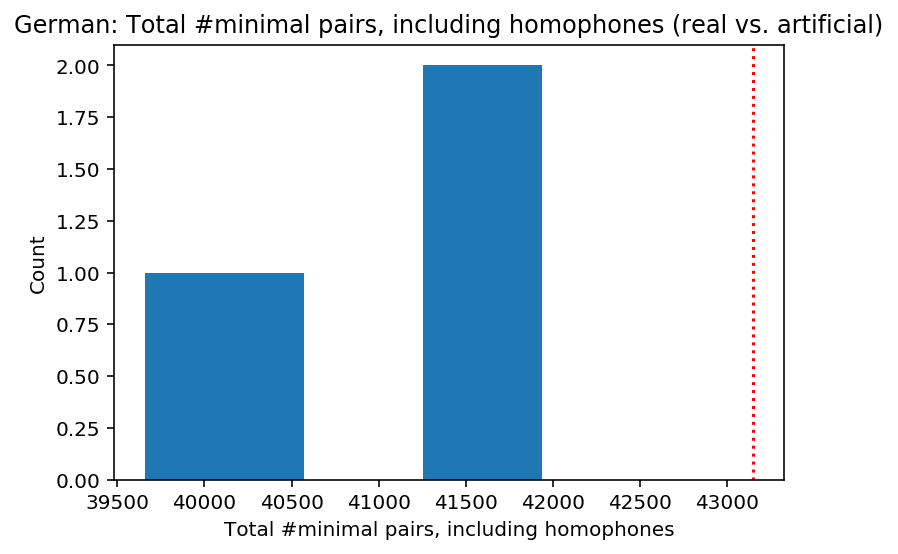

In [59]:
plot_real_vs_art(info_for_german['total_mp_w_hp'], df_german_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='German')

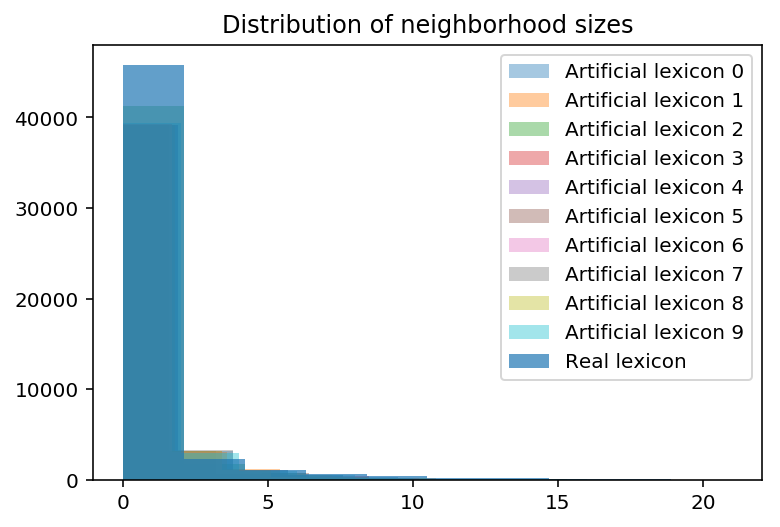

In [60]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

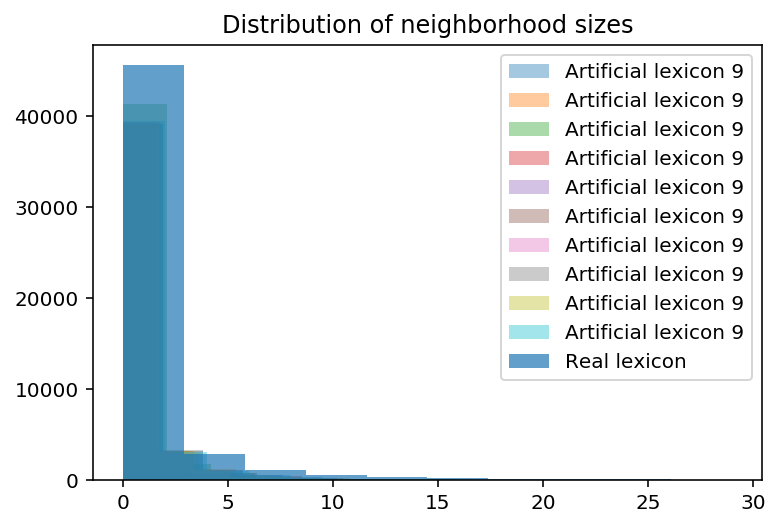

In [61]:
for df_tmp in processed_artificials:
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word, and a higher percentage of homophonous wordforms overall.

Mean of artificial: 0.09514.
Median of artificial: 0.09505.
Standard deviation of artificial: 0.0006415259585983675.
Range of artificial: (0.0943, 0.0963).
Real value: 0.023.


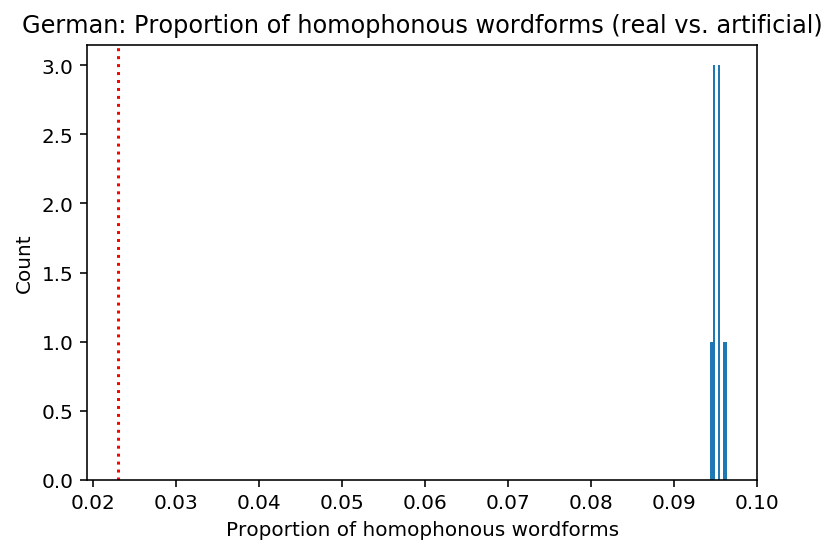

In [62]:
plot_real_vs_art(info_for_german['homophone_percentage'], df_german_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='German')
plt.savefig("Figures/german/german_%_homophones.png", dpi=300)

Mean of artificial: 0.16822.
Median of artificial: 0.1684.
Standard deviation of artificial: 0.0011399805066559514.
Range of artificial: (0.1664, 0.1696).
Real value: 0.0246.


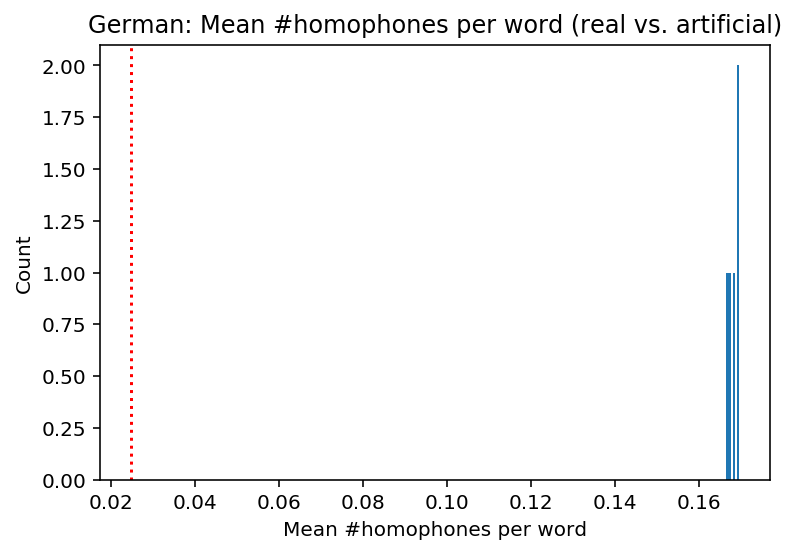

In [63]:
plot_real_vs_art(info_for_german['mean_homophones'], df_german_stats['mean_homophones'],
                'Mean #homophones per word', language='German')
plt.savefig("Figures/german/german_mean_homophones.png", dpi=300)

Mean of artificial: 35.
Median of artificial: 35.5.
Standard deviation of artificial: 4.898979485566356.
Range of artificial: (26, 42).
Real value: 4.


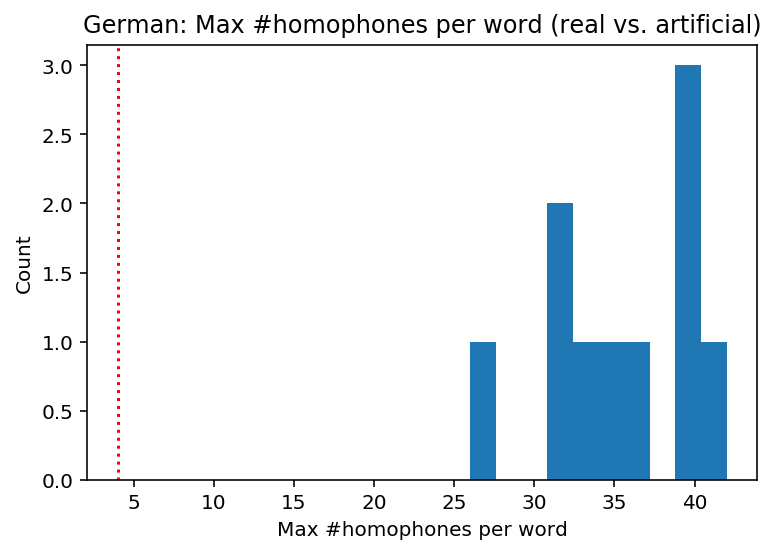

In [64]:
plot_real_vs_art(info_for_german['max_homophones'], df_german_stats['max_homophones'],
                'Max #homophones per word', language='German')
plt.savefig("Figures/german/german_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (German)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is smaller in the artificial lexicons than real lexicon (as shown in the other analysis).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [65]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'German'

surprisal_normed

Mean of artificial: -5.316192144021997.
Median of artificial: -5.295614255668735.
Standard deviation of artificial: 0.12038299518049929.
Range of artificial: (-5.633334841374974, -5.201867786157091).
Real value: 0.7177191055728347.
num_sylls_est

Mean of artificial: -1.688567794007864.
Median of artificial: -1.6861901671571444.
Standard deviation of artificial: 0.014105076431392364.
Range of artificial: (-1.7162461767211825, -1.6679866023988266).
Real value: -0.7656577979276276.

R2
Mean of artificial: 0.23093220451536697.
Median of artificial: 0.23045656686696275.
Standard deviation of artificial: 0.003193144716080405.
Range of artificial: (0.22685300230245953, 0.23732526701218126).
Real value: 0.09038681996180942.


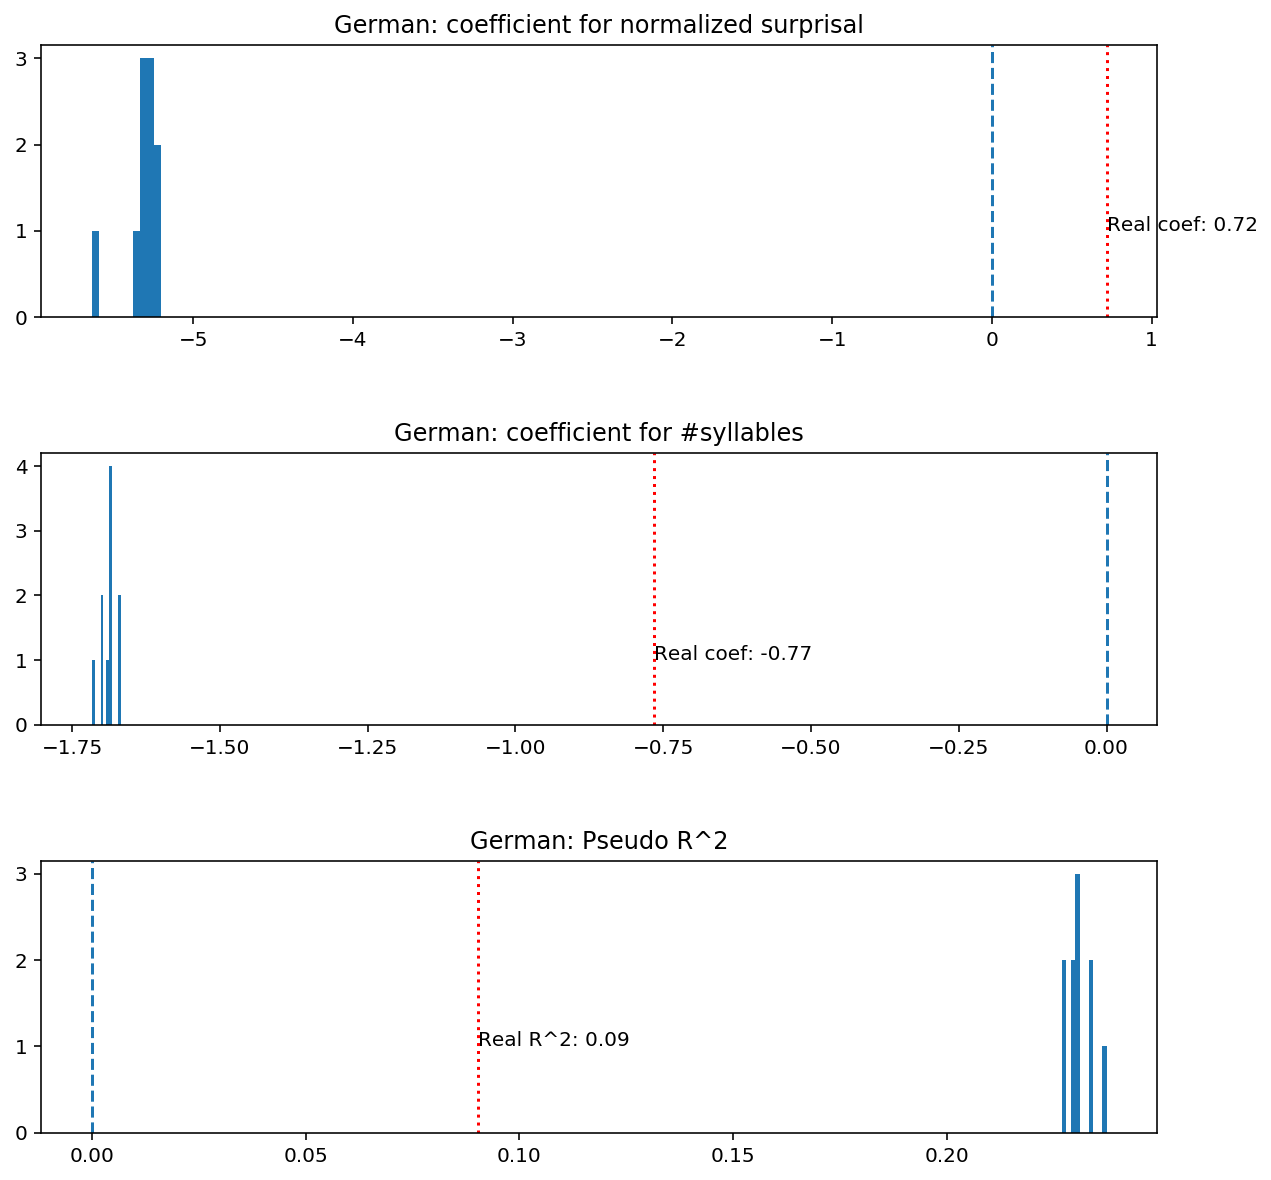

In [66]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [67]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'German'

surprisal_normed

Mean of artificial: -5.79727619767008.
Median of artificial: -5.772245558866912.
Standard deviation of artificial: 0.12558495383896698.
Range of artificial: (-6.11774944328218, -5.691335442696058).
Real value: 0.3222272438380277.
num_sylls_est

Mean of artificial: -1.4480818852314998.
Median of artificial: -1.4460217571109084.
Standard deviation of artificial: 0.02080951785700048.
Range of artificial: (-1.4779810297132572, -1.4155718659880987).
Real value: -0.5705574514162977.
neighborhood_size

Mean of artificial: 0.2114701317572894.
Median of artificial: 0.20973651794273712.
Standard deviation of artificial: 0.010527895982052322.
Range of artificial: (0.18763377904177805, 0.22459469631922316).
Real value: 0.1351623368862036.

R2
Mean of artificial: 0.2759982932684038.
Median of artificial: 0.27585895373995406.
Standard deviation of artificial: 0.0029868678889827197.
Range of artificial: (0.27161301390502257, 0.28082544680657673).
Real value: 0.10959960927930501.


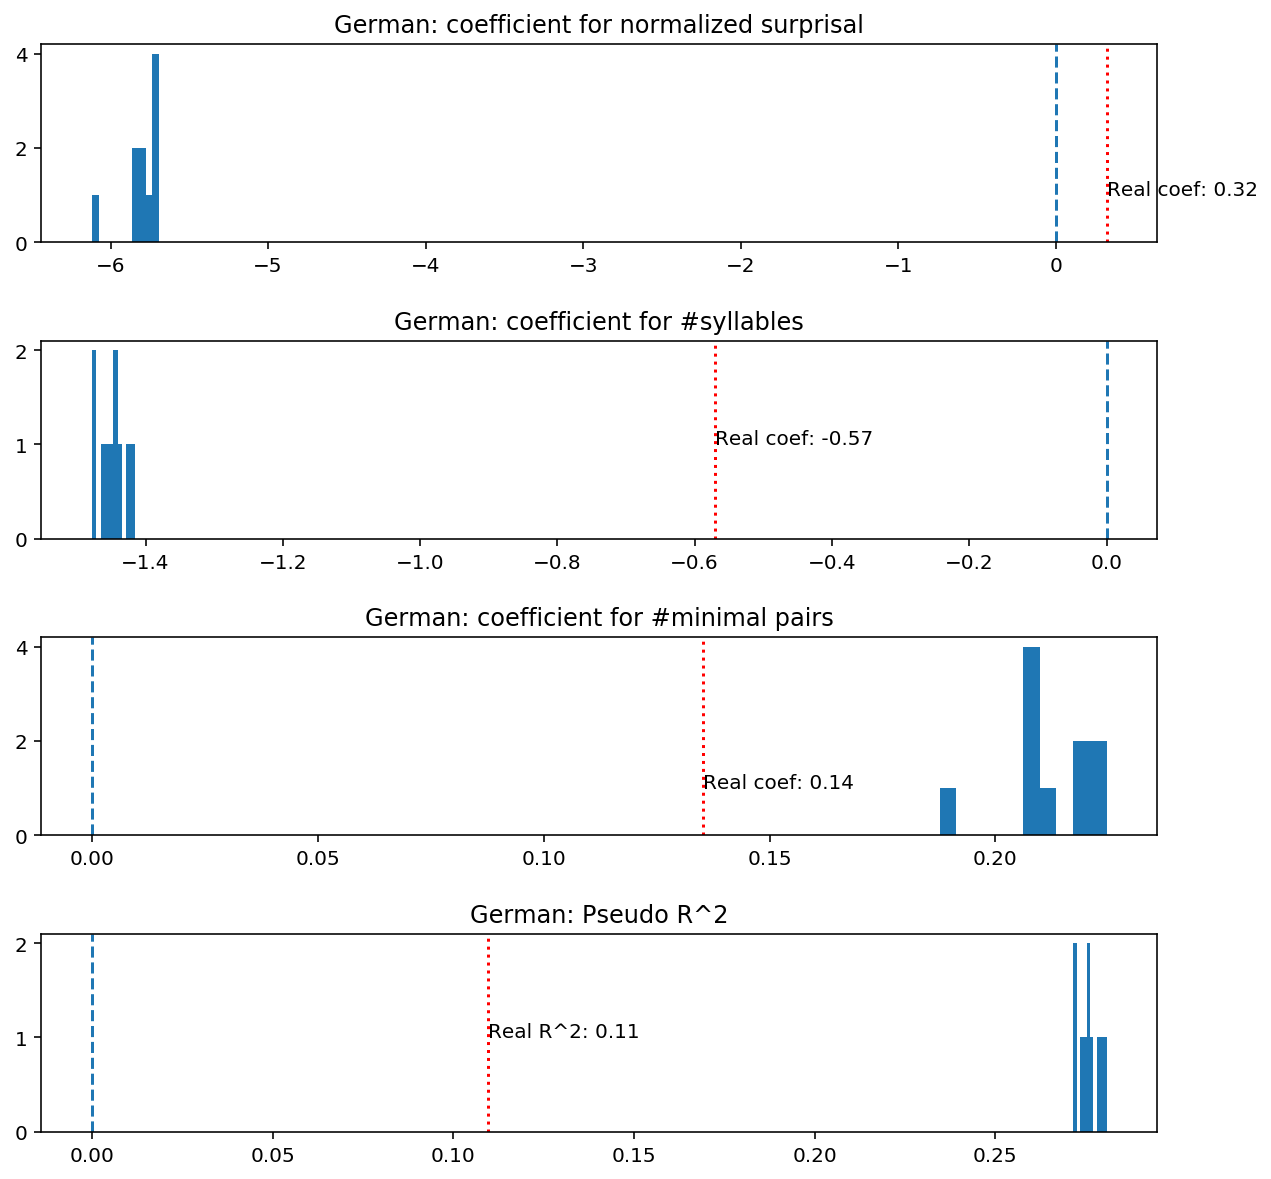

In [68]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #homophones + #syllables + surprisal
```

Mostly consistent with the above analysis in English, we find:

- The effect of **surprisal** (predicting #minimal pairs) is larger in the real lexicon than in the artificial lexicon.
- The effect of **#syllables** is larger in the artificial than real lexicon (this is distinct from the analysis in English).
- The effect of **#homophones** is larger in the real lexicon than in the artificial lexicons.

#### Analysis

In [69]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    # 'num_homophones'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    # '#homophones'
]
LANGUAGE = 'German'

surprisal_normed

Mean of artificial: -0.0871765958428384.
Median of artificial: -0.08740539569754902.
Standard deviation of artificial: 0.054826069398683945.
Range of artificial: (-0.16814826759595464, 0.011306410354795467).
Real value: 0.563890326992891.
num_sylls_est

Mean of artificial: -1.3108521309701118.
Median of artificial: -1.3109478591016863.
Standard deviation of artificial: 0.015720938732472583.
Range of artificial: (-1.342599549809181, -1.288268945208174).
Real value: -1.0811788519605803.

R2
Mean of artificial: 0.2994845375034796.
Median of artificial: 0.3008204485256359.
Standard deviation of artificial: 0.004840827859529273.
Range of artificial: (0.2918777179603137, 0.3057220597845933).
Real value: 0.30382280059864664.


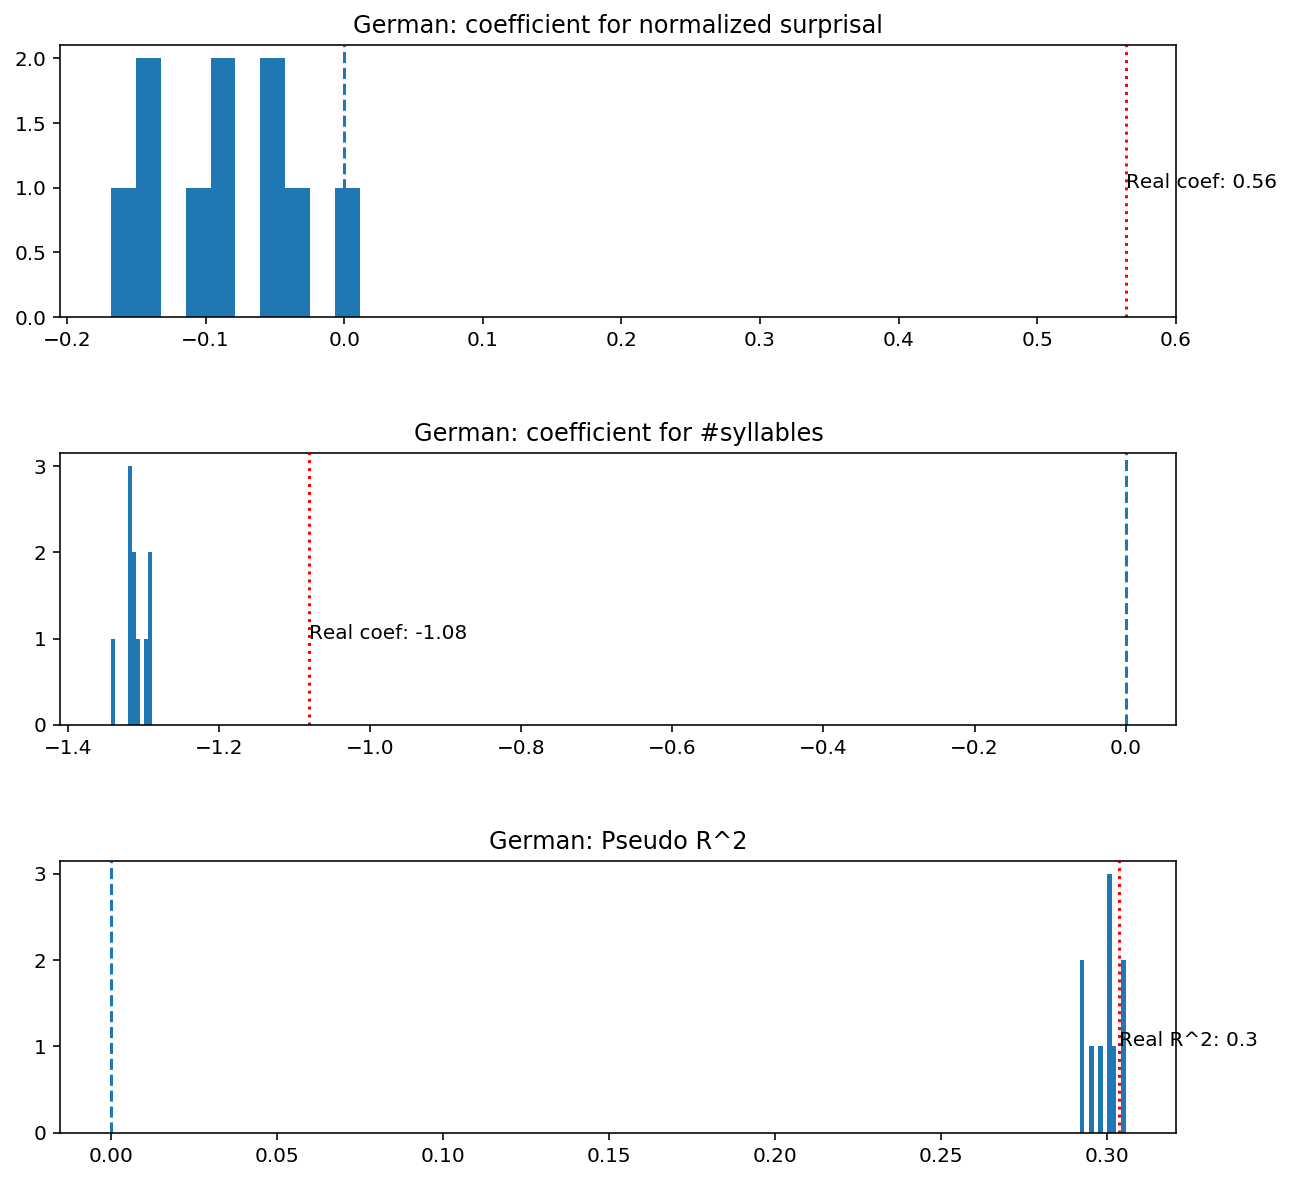

In [70]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# Dutch

In [71]:
df_celex, df_celex_processed, df_dutch_artificials = load_lexicons_for_language("dutch")

In [72]:
len(df_celex)

67910

In [73]:
len(df_celex_processed)

65351

In [74]:
df_dutch_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [75]:
info_for_dutch = process_and_extract_artificials(df_dutch_artificials)

100%|██████████| 10/10 [00:13<00:00,  1.20s/it]


In [76]:
processed_artificials = info_for_dutch['processed_dataframes']

In [77]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

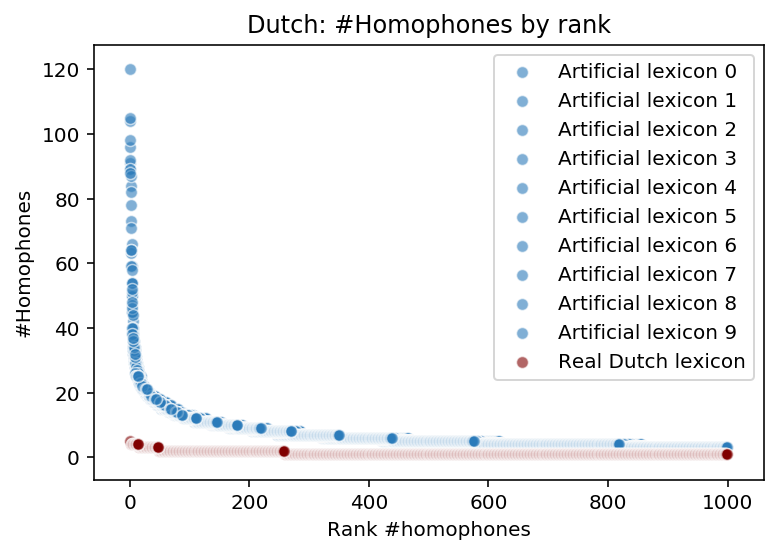

In [78]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Dutch: #Homophones by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

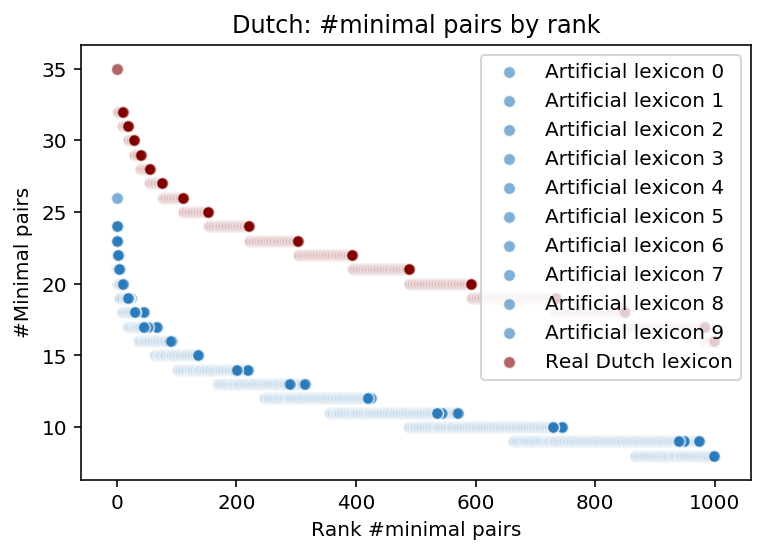

In [79]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("Dutch: #minimal pairs by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_neighborhoods.png", dpi=300)


### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

Mean of artificial: 0.71867.
Median of artificial: 0.7202.
Standard deviation of artificial: 0.007596790257880116.
Range of artificial: (0.7051, 0.7311).
Real value: 1.1584.


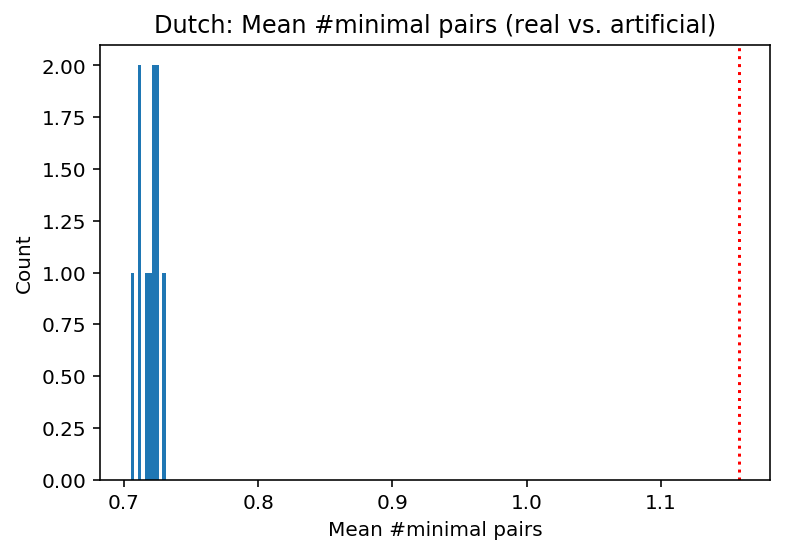

In [80]:
plot_real_vs_art(info_for_dutch['mean_mp'], df_dutch_stats['mean_mp'],
                'Mean #minimal pairs', language="Dutch")

Mean of artificial: 1.51333.
Median of artificial: 1.5141499999999999.
Standard deviation of artificial: 0.019095028439651794.
Range of artificial: (1.4871, 1.5497).
Real value: 1.4446.


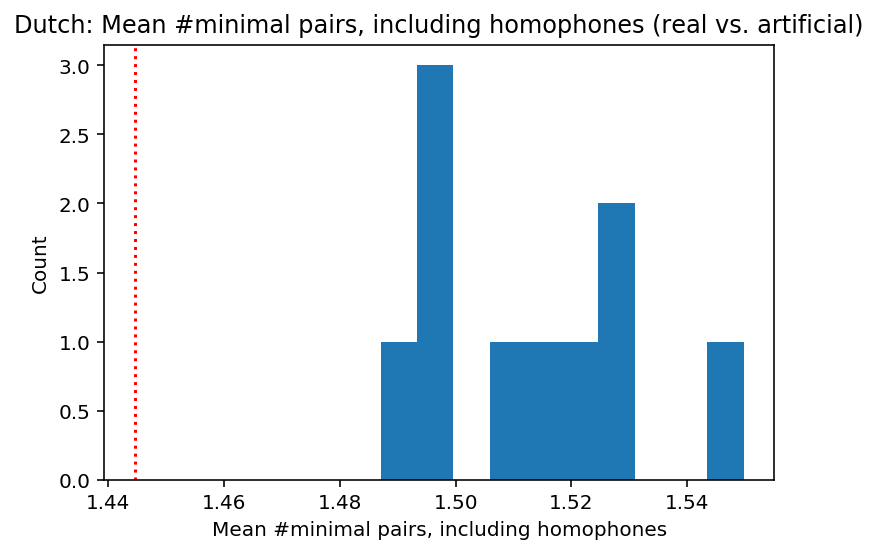

In [81]:
plot_real_vs_art(info_for_dutch['mean_mp_w_hp'], df_dutch_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="Dutch")

Mean of artificial: 23.
Median of artificial: 23.0.
Standard deviation of artificial: 1.0.
Range of artificial: (21, 26).
Real value: 35.


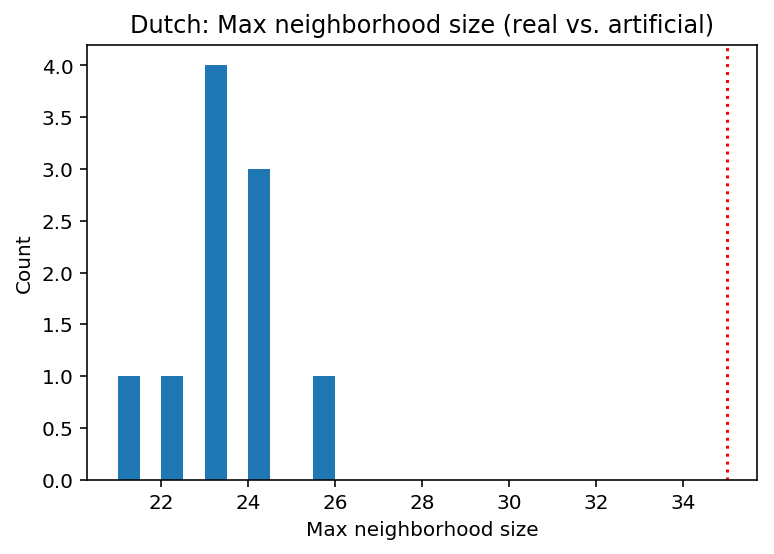

In [82]:
plot_real_vs_art(info_for_dutch['max_mp'], df_dutch_stats['max_mp'],
                'Max neighborhood size', language="Dutch")

Mean of artificial: 121.
Median of artificial: 120.5.
Standard deviation of artificial: 7.874007874011811.
Range of artificial: (111, 139).
Real value: 64.


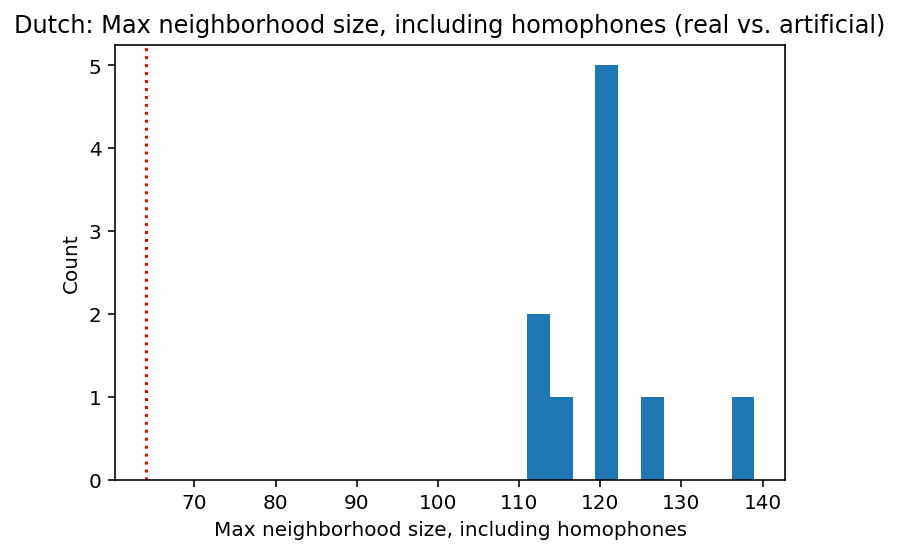

In [83]:
plot_real_vs_art(info_for_dutch['max_mp_w_hp'], df_dutch_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="Dutch")

Mean of artificial: 39196.
Median of artificial: 39264.0.
Standard deviation of artificial: 444.65492238363896.
Range of artificial: (38388, 39926).
Real value: 75701.


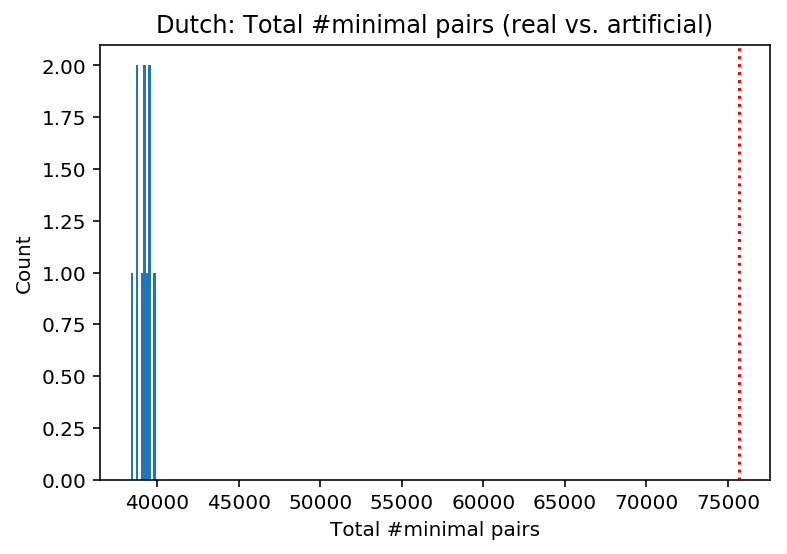

In [84]:
plot_real_vs_art(info_for_dutch['total_mp'], df_dutch_stats['total_mp'],
                'Total #minimal pairs', language='Dutch')

Mean of artificial: 82537.
Median of artificial: 82661.0.
Standard deviation of artificial: 1027.1197593270222.
Range of artificial: (81130, 84460).
Real value: 94405.


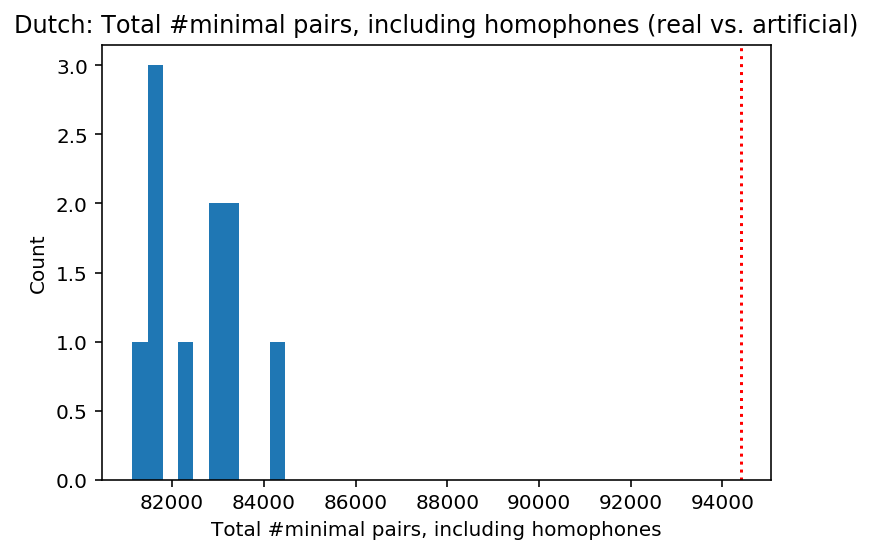

In [85]:
plot_real_vs_art(info_for_dutch['total_mp_w_hp'], df_dutch_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='Dutch')

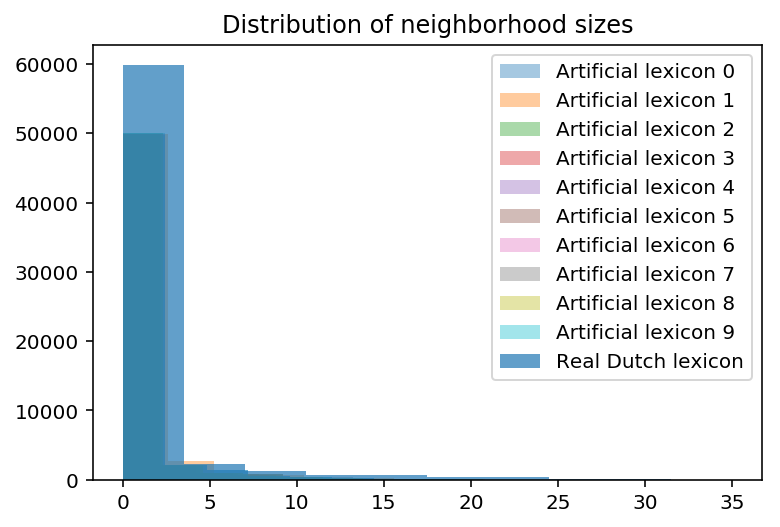

In [86]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real Dutch lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

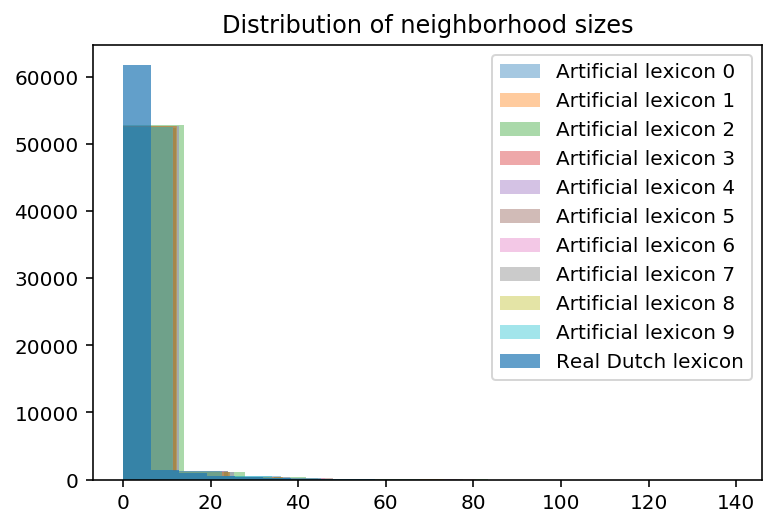

In [87]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real Dutch lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

Mean of artificial: 0.10847.
Median of artificial: 0.1084.
Standard deviation of artificial: 0.0006201254353399443.
Range of artificial: (0.1073, 0.1096).
Real value: 0.0292.


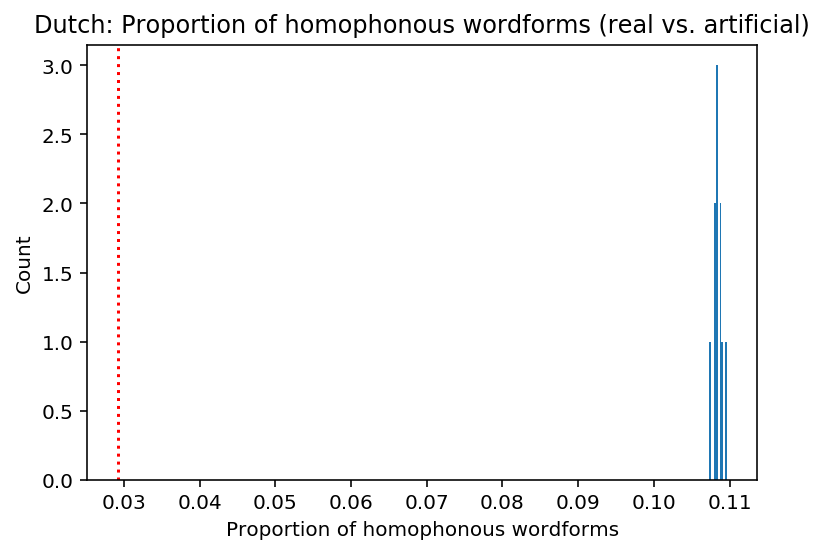

In [88]:
plot_real_vs_art(info_for_dutch['homophone_percentage'], df_dutch_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='Dutch')
plt.savefig("Figures/dutch/dutch_%_homophones.png", dpi=300)

Mean of artificial: 0.24511.
Median of artificial: 0.24485.
Standard deviation of artificial: 0.0013461467643281332.
Range of artificial: (0.2432, 0.2473).
Real value: 0.0342.


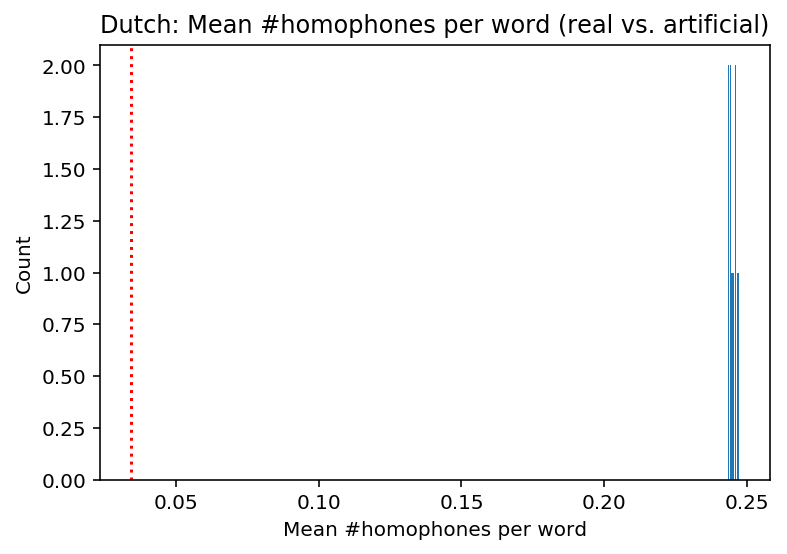

In [89]:
plot_real_vs_art(info_for_dutch['mean_homophones'], df_dutch_stats['mean_homophones'],
                'Mean #homophones per word', language='Dutch')
plt.savefig("Figures/dutch/dutch_mean_homophones.png", dpi=300)

Mean of artificial: 97.
Median of artificial: 94.0.
Standard deviation of artificial: 10.04987562112089.
Range of artificial: (88, 120).
Real value: 5.


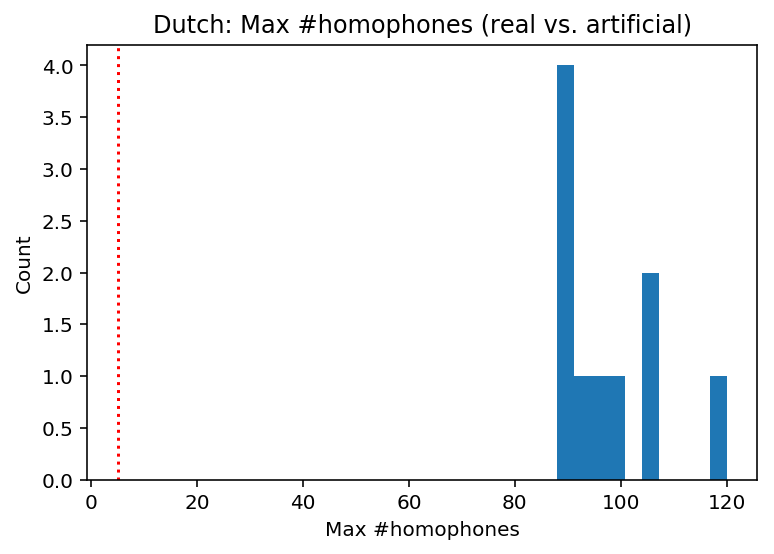

In [90]:
plot_real_vs_art(info_for_dutch['max_homophones'], df_dutch_stats['max_homophones'],
                'Max #homophones', language='Dutch')
plt.savefig("Figures/dutch/dutch_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (Dutch)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is smaller in the artificial lexicons than real lexicon (as shown in the other analysis).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [91]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'Dutch'

surprisal_normed

Mean of artificial: -5.557579406893423.
Median of artificial: -5.55261786362703.
Standard deviation of artificial: 0.07865771311078777.
Range of artificial: (-5.6952383678829825, -5.454912871645468).
Real value: 0.9182347567800994.
num_sylls_est

Mean of artificial: -1.8997663002646048.
Median of artificial: -1.899799751773663.
Standard deviation of artificial: 0.013158594610823636.
Range of artificial: (-1.9205795526381158, -1.8784180710974132).
Real value: -1.186450739984781.

R2
Mean of artificial: 0.2651268473891912.
Median of artificial: 0.26510923260394004.
Standard deviation of artificial: 0.002649762061748284.
Range of artificial: (0.26127345160601434, 0.2699432322781993).
Real value: 0.186567326217293.


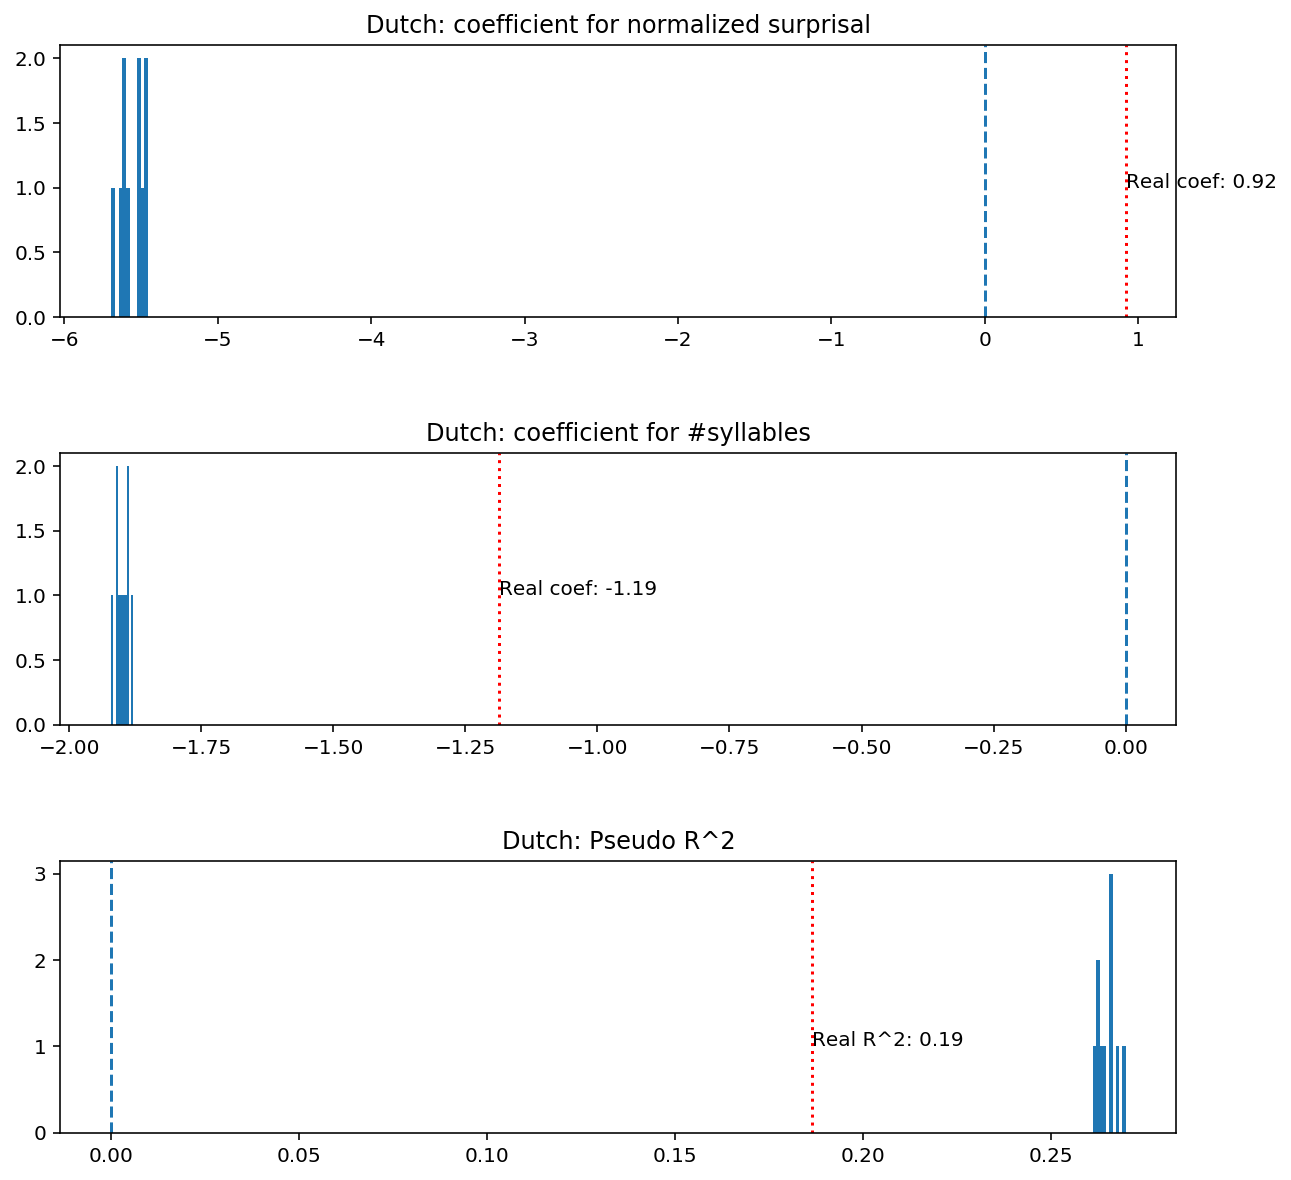

In [92]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [93]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'Dutch'

surprisal_normed

Mean of artificial: -6.8812720386993655.
Median of artificial: -6.878908130932343.
Standard deviation of artificial: 0.08145002530794375.
Range of artificial: (-7.027109982532759, -6.760121518520627).
Real value: 0.6059231779815096.
num_sylls_est

Mean of artificial: -1.5207945128896256.
Median of artificial: -1.5196137198237039.
Standard deviation of artificial: 0.02031483185271557.
Range of artificial: (-1.5472207094593857, -1.4907102159018526).
Real value: -0.7884561728701986.
neighborhood_size

Mean of artificial: 0.2307309052664706.
Median of artificial: 0.2338058579134673.
Standard deviation of artificial: 0.0061371709386976465.
Range of artificial: (0.21733073637360178, 0.23675920505626966).
Real value: 0.080001508197513.

R2
Mean of artificial: 0.34420684014899533.
Median of artificial: 0.3426420413527971.
Standard deviation of artificial: 0.0036514798375354754.
Range of artificial: (0.3410186300232383, 0.35196933915418027).
Real value: 0.2149557143379348.


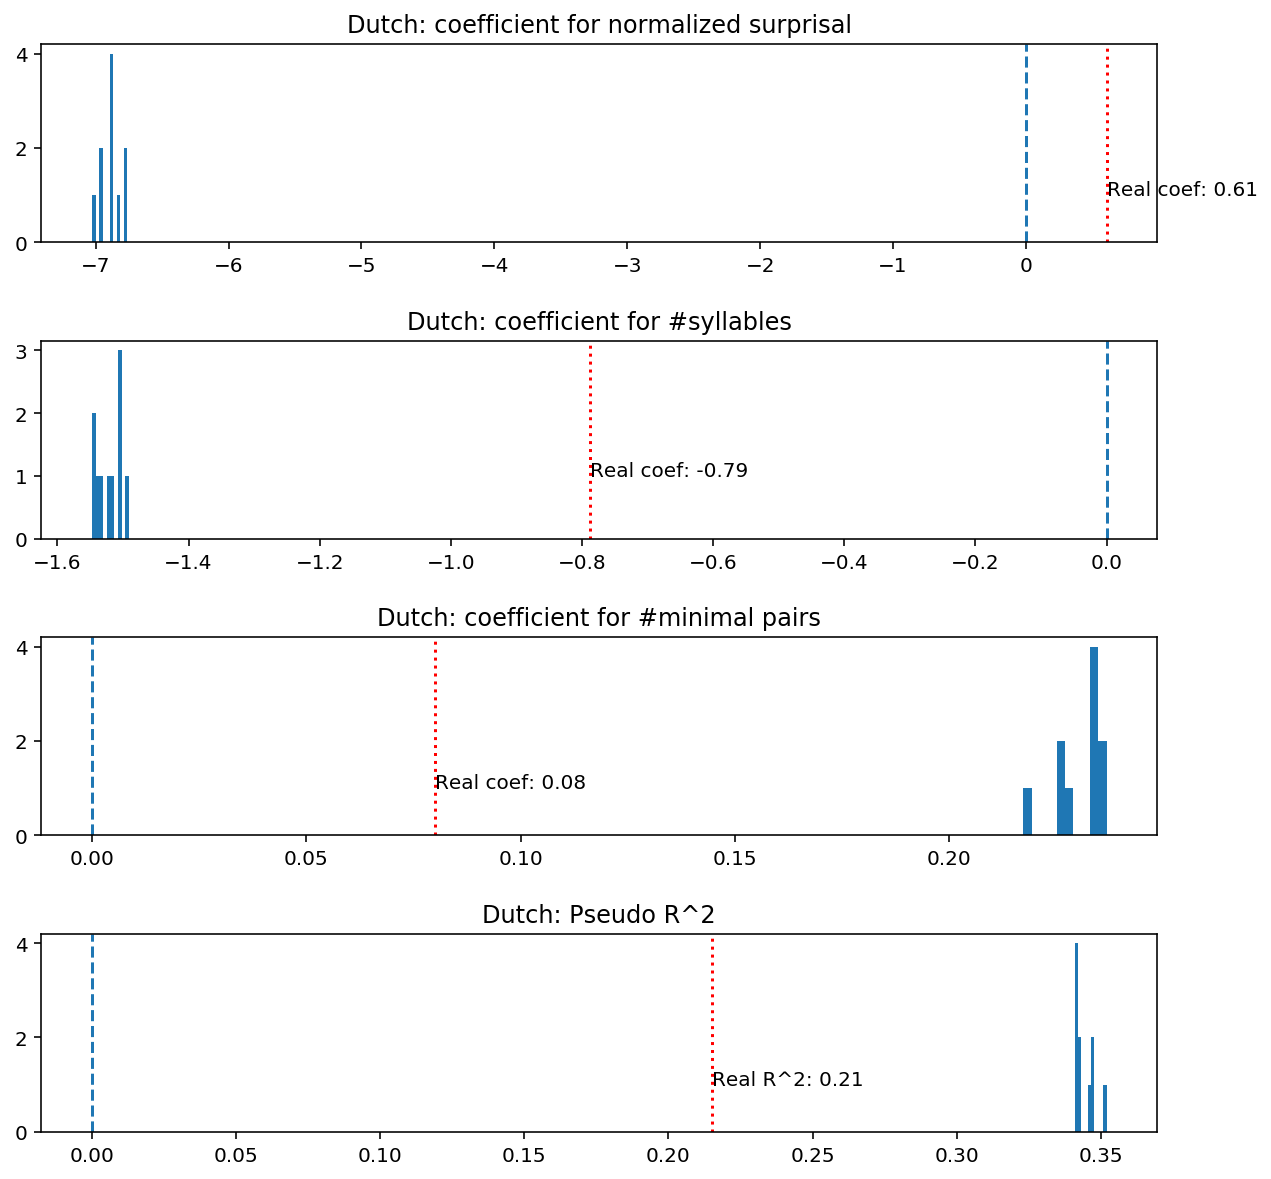

In [94]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #syllables + surprisal
```


#### Analysis

In [95]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'Dutch'

/Users/seantrott/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


surprisal_normed

Mean of artificial: 0.45662354601866256.
Median of artificial: 0.4664400381602968.
Standard deviation of artificial: 0.03667681828997189.
Range of artificial: (0.3996646974290747, 0.5034669613665894).
Real value: 0.8963558633971299.
num_sylls_est

Mean of artificial: -1.3436689956617136.
Median of artificial: -1.340127315525606.
Standard deviation of artificial: 0.012326755775454954.
Range of artificial: (-1.364376663932408, -1.332333364944028).
Real value: -1.3132493245398644.

R2
Mean of artificial: 0.3397742684616869.
Median of artificial: 0.3416654471930692.
Standard deviation of artificial: 0.006511596101437604.
Range of artificial: (0.32843246859196584, 0.34684938961062206).
Real value: 0.4363706978496642.


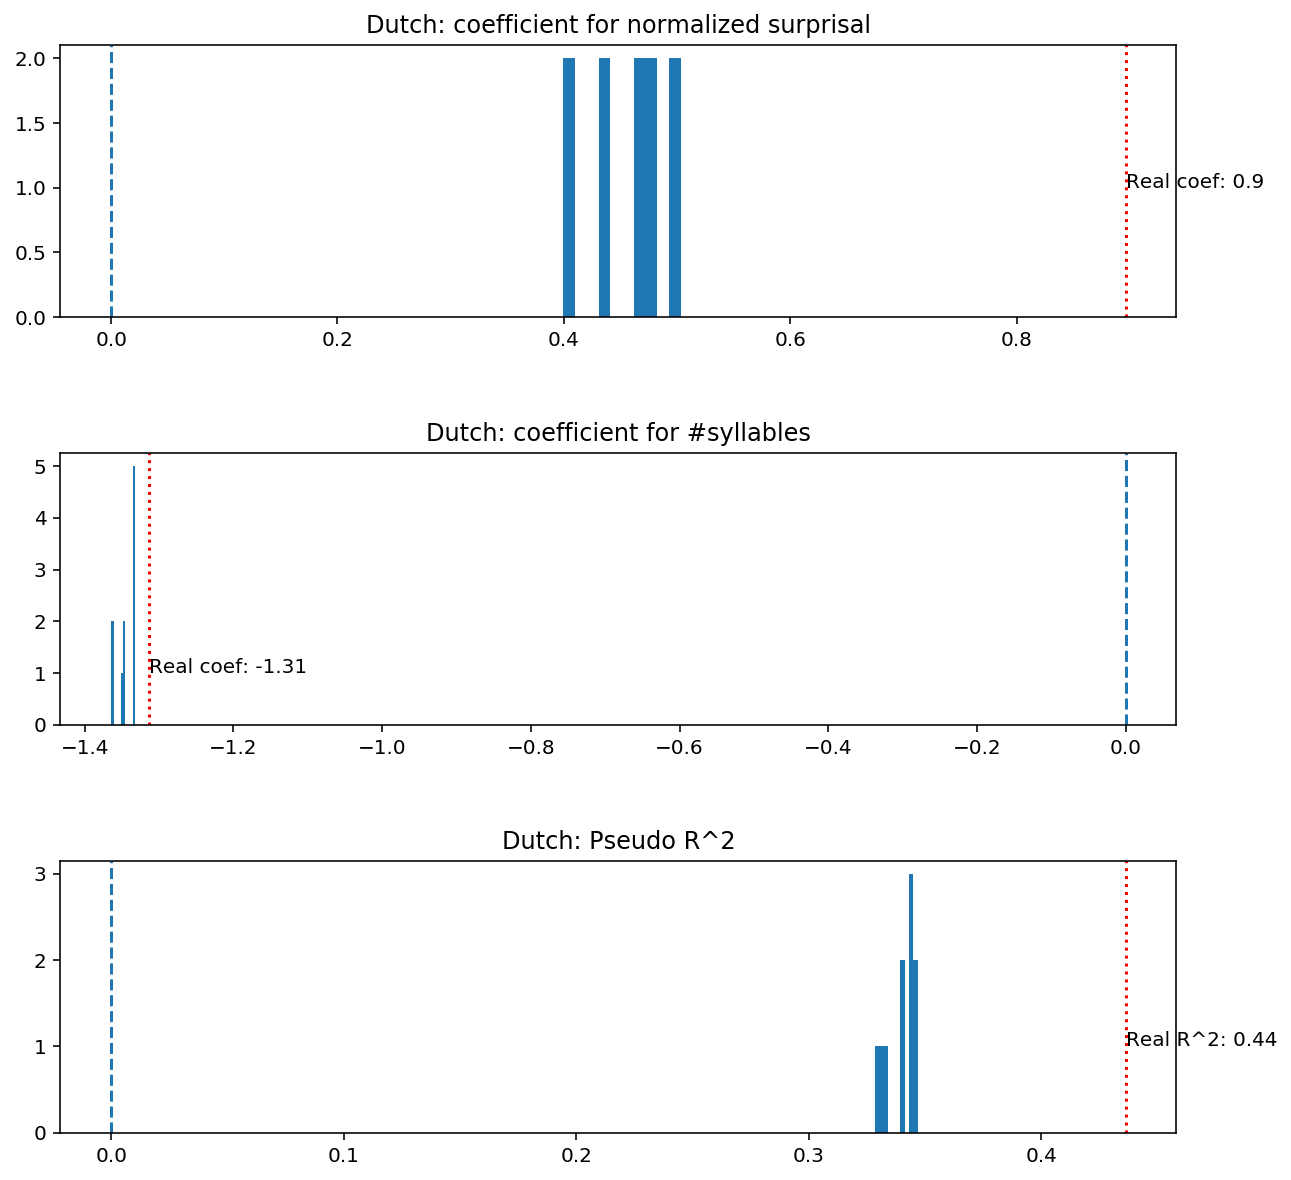

In [96]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# French

In [97]:
import src.config as config

In [98]:
df_celex, df_celex_processed, df_french_artificials = load_lexicons_for_language("french", 
                                                                                word_column=config.WORD_COLUMN['french'], 
                                                                                phon_column=config.PHON_COLUMN['french'])

In [99]:
len(df_celex)

47310

In [100]:
len(df_celex_processed)

37278

In [101]:
df_french_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [102]:
info_for_french = process_and_extract_artificials(df_french_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


In [103]:
processed_artificials = info_for_french['processed_dataframes']

In [104]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

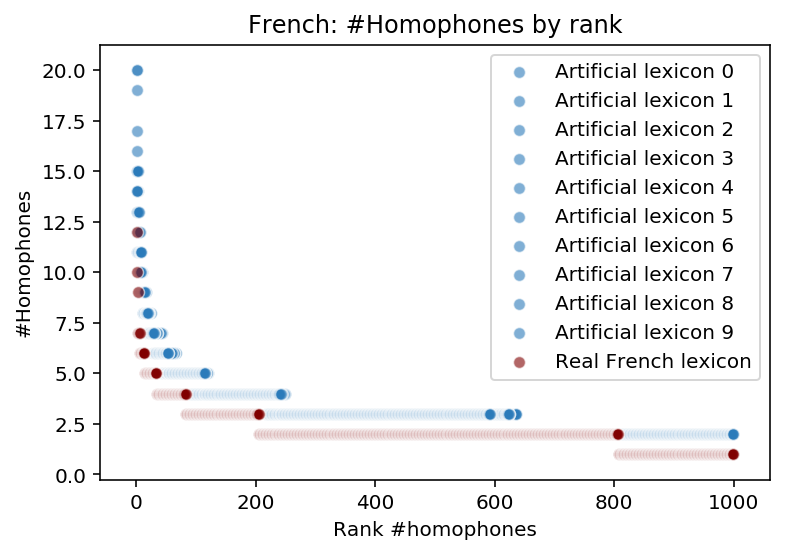

In [105]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real French lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("French: #Homophones by rank")

plt.savefig("Figures/french/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

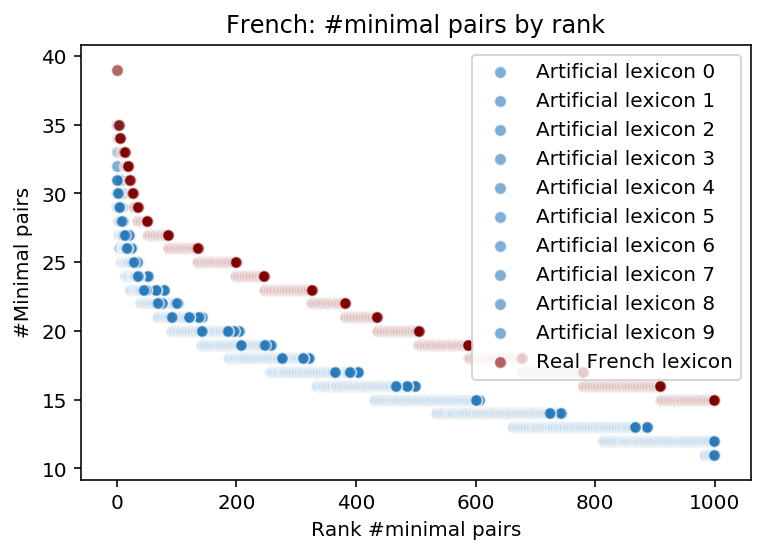

In [106]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real French lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("French: #minimal pairs by rank")

plt.savefig("Figures/french/data_visualizations/rank_neighborhoods.png", dpi=300)


### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

Mean of artificial: 1.5843.
Median of artificial: 1.579.
Standard deviation of artificial: 0.016589621923225283.
Range of artificial: (1.5668, 1.6202).
Real value: 1.9556.


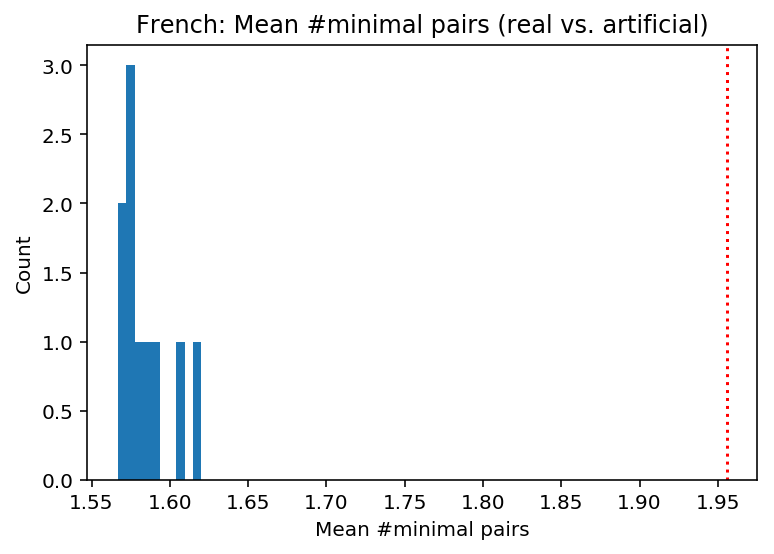

In [107]:
plot_real_vs_art(info_for_french['mean_mp'], df_french_stats['mean_mp'],
                'Mean #minimal pairs', language="French")

Mean of artificial: 2.59061.
Median of artificial: 2.5877.
Standard deviation of artificial: 0.027302765427699754.
Range of artificial: (2.5407, 2.6411).
Real value: 2.8871.


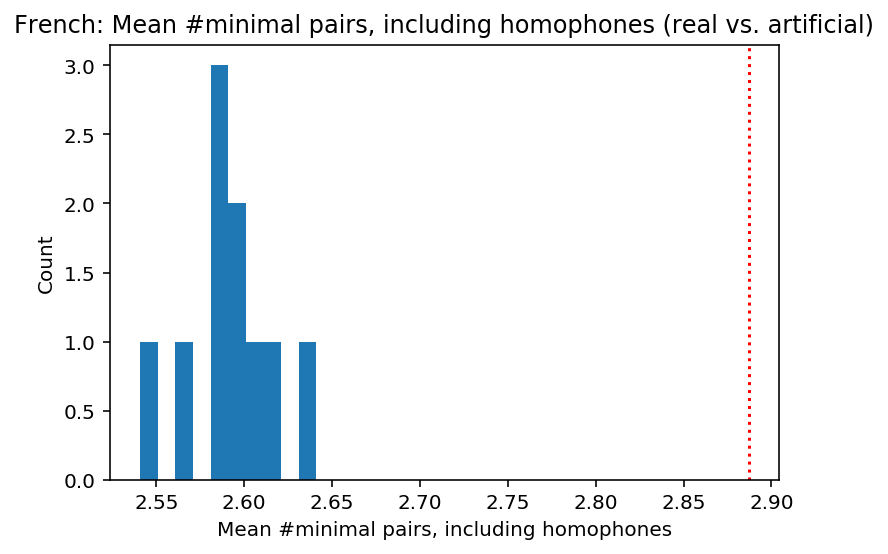

In [108]:
plot_real_vs_art(info_for_french['mean_mp_w_hp'], df_french_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="French")

Mean of artificial: 31.
Median of artificial: 31.0.
Standard deviation of artificial: 1.7320508075688772.
Range of artificial: (29, 35).
Real value: 39.


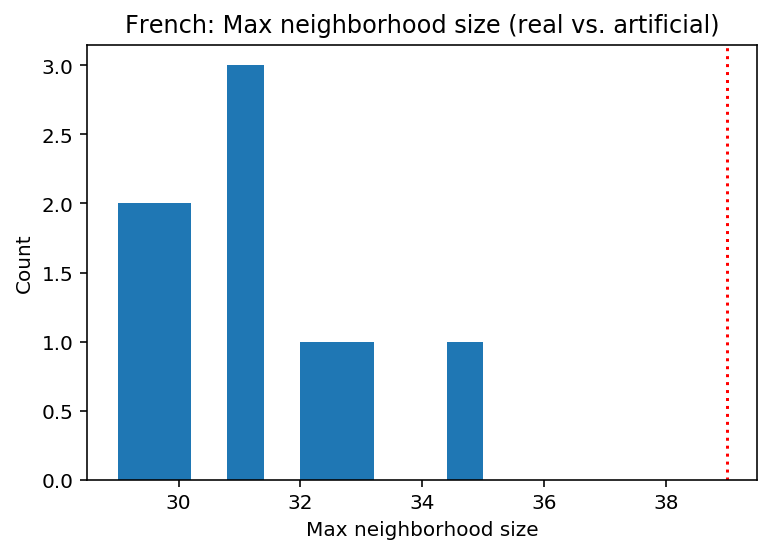

In [109]:
plot_real_vs_art(info_for_french['max_mp'], df_french_stats['max_mp'],
                'Max neighborhood size', language="French")

Mean of artificial: 69.
Median of artificial: 69.0.
Standard deviation of artificial: 6.164414002968976.
Range of artificial: (60, 79).
Real value: 97.


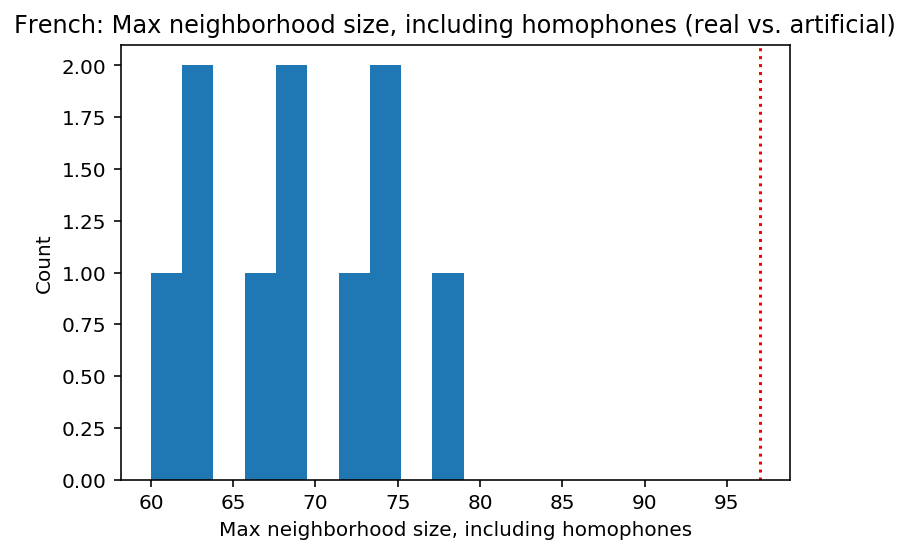

In [110]:
plot_real_vs_art(info_for_french['max_mp_w_hp'], df_french_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="French")

Mean of artificial: 60934.
Median of artificial: 60715.0.
Standard deviation of artificial: 654.5441161602479.
Range of artificial: (60240, 62366).
Real value: 72901.


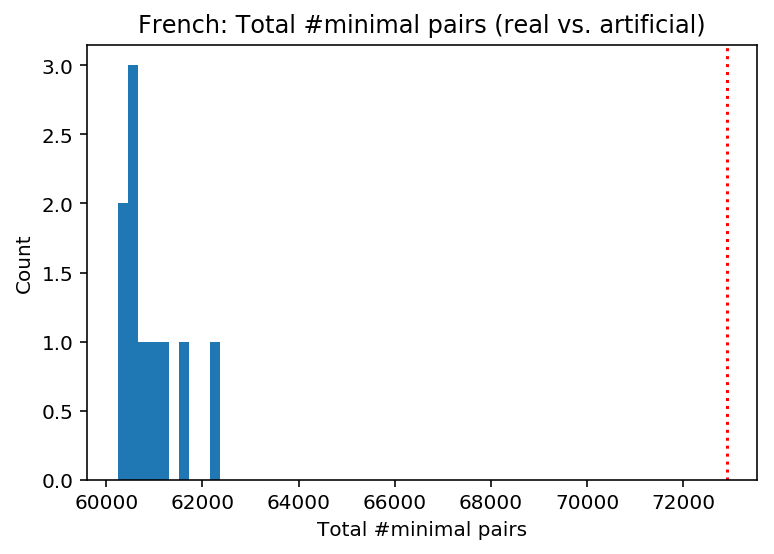

In [111]:
plot_real_vs_art(info_for_french['total_mp'], df_french_stats['total_mp'],
                'Total #minimal pairs', language='French')

Mean of artificial: 99637.
Median of artificial: 99480.0.
Standard deviation of artificial: 1069.0495778961797.
Range of artificial: (97683, 101660).
Real value: 107624.


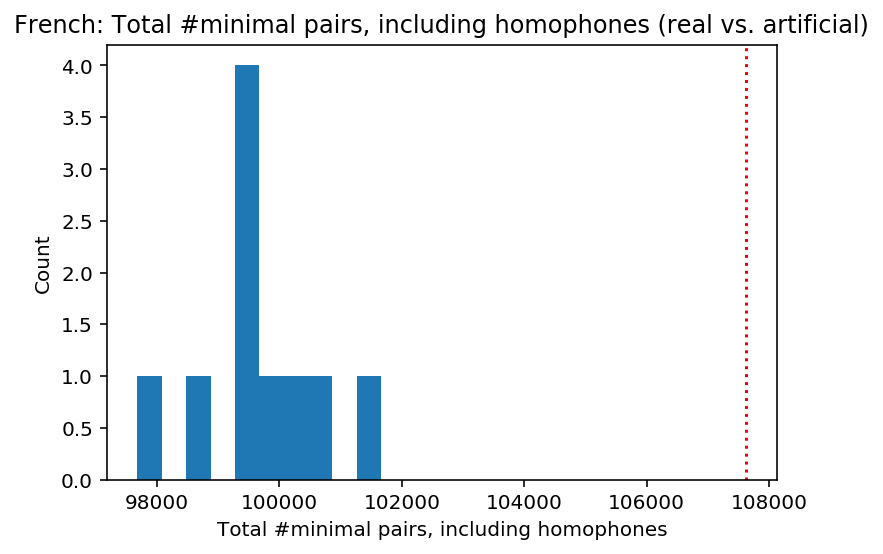

In [112]:
plot_real_vs_art(info_for_french['total_mp_w_hp'], df_french_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='French')

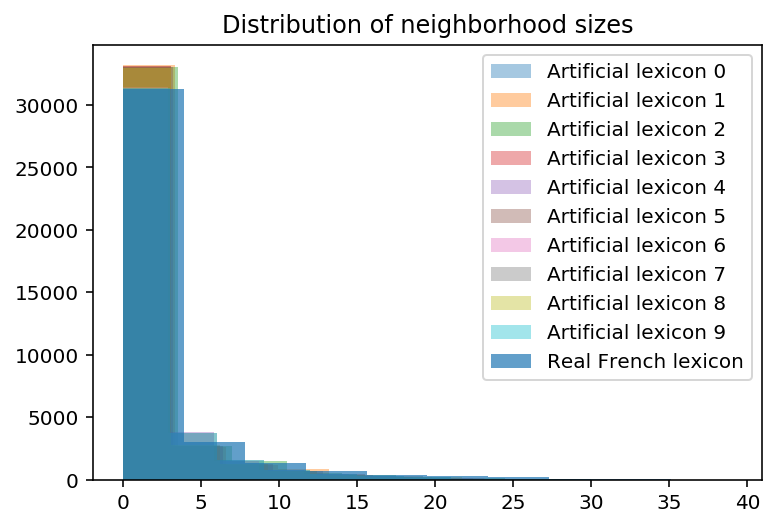

In [113]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real French lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

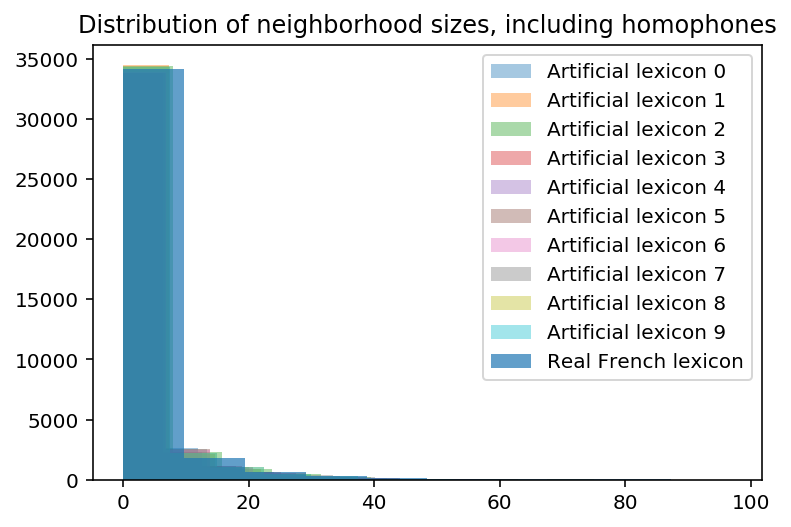

In [114]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real French lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes, including homophones")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

Mean of artificial: 0.15445.
Median of artificial: 0.15435.
Standard deviation of artificial: 0.001381826488544945.
Range of artificial: (0.1527, 0.1577).
Real value: 0.1434.


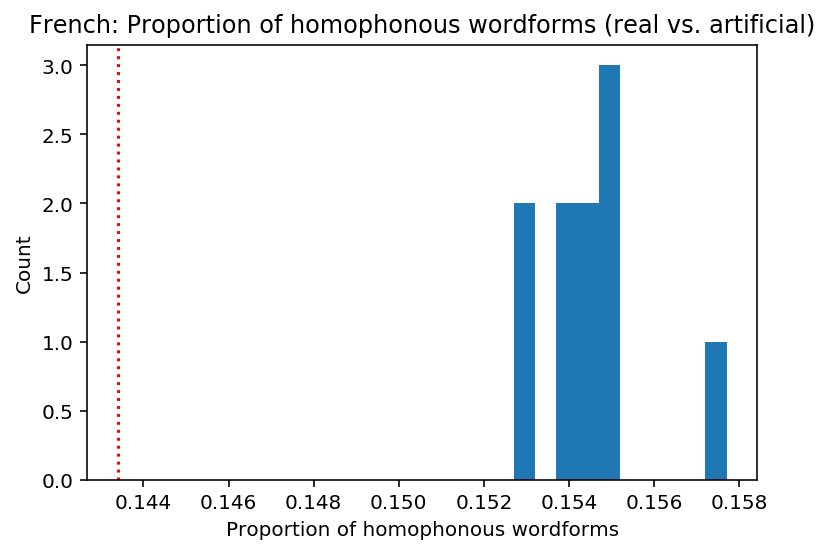

In [115]:
plot_real_vs_art(info_for_french['homophone_percentage'], df_french_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='French')
plt.savefig("Figures/french/french_%_homophones.png", dpi=300)

Mean of artificial: 0.23009000000000002.
Median of artificial: 0.23.
Standard deviation of artificial: 0.0009677580046455589.
Range of artificial: (0.229, 0.2319).
Real value: 0.1745.


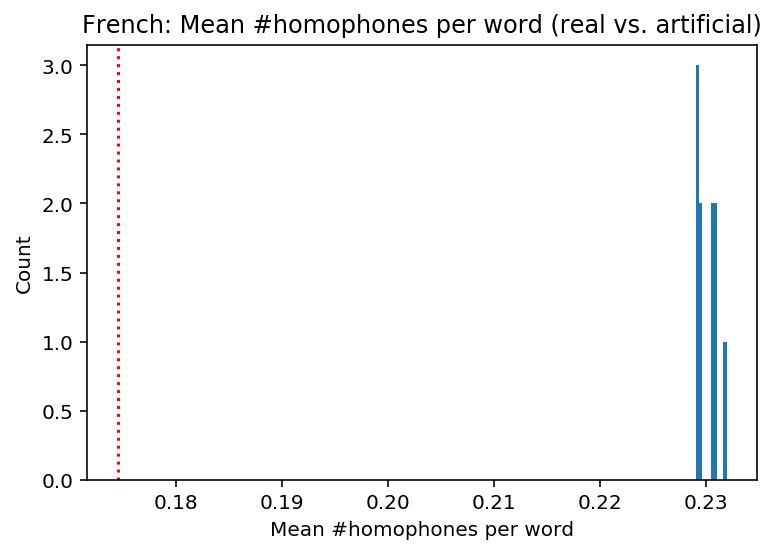

In [116]:
plot_real_vs_art(info_for_french['mean_homophones'], df_french_stats['mean_homophones'],
                'Mean #homophones per word', language='French')
plt.savefig("Figures/french/french_mean_homophones.png", dpi=300)

Mean of artificial: 15.
Median of artificial: 15.0.
Standard deviation of artificial: 2.8284271247461903.
Range of artificial: (13, 20).
Real value: 12.


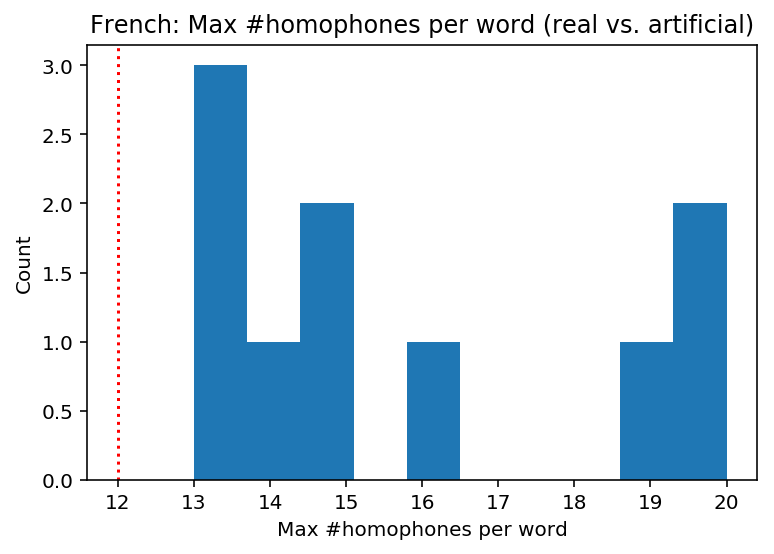

In [117]:
plot_real_vs_art(info_for_french['max_homophones'], df_french_stats['max_homophones'],
                'Max #homophones per word', language='French')
plt.savefig("Figures/french/french_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (French)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is larger in the artificial lexicons than real lexicon (as shown in English, when controlling for neighborhood size).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [118]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'French'

surprisal_normed

Mean of artificial: -1.8780142048764696.
Median of artificial: -1.8884881653833663.
Standard deviation of artificial: 0.0683698739150603.
Range of artificial: (-1.981518151234095, -1.7737620465484063).
Real value: 0.9233521036036426.
num_sylls_est

Mean of artificial: -1.1693051605950358.
Median of artificial: -1.1693295118816578.
Standard deviation of artificial: 0.0053609246577970456.
Range of artificial: (-1.1778152398922432, -1.1586132290104478).
Real value: -0.2572533754728375.

R2
Mean of artificial: 0.13225940751749338.
Median of artificial: 0.13213426397774264.
Standard deviation of artificial: 0.0013468582376467398.
Range of artificial: (0.13053641803977778, 0.13427968183235317).
Real value: 0.05951380829741948.


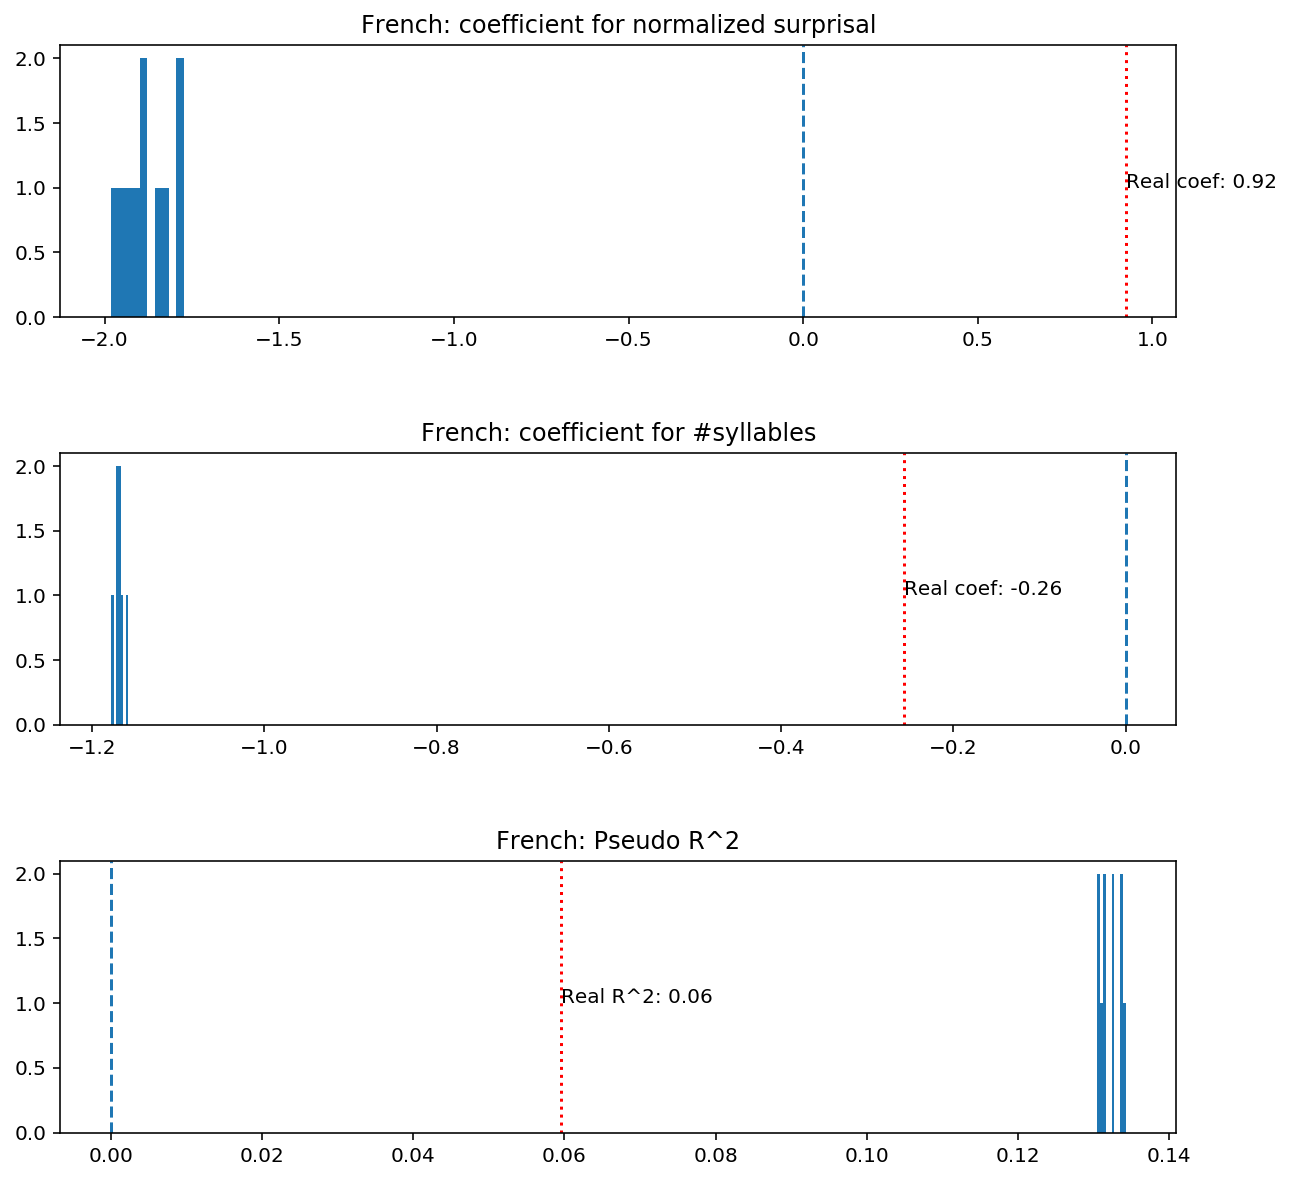

In [119]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [120]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized_surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'French'

surprisal_normed

Mean of artificial: -3.0201065273510324.
Median of artificial: -3.0248075628826356.
Standard deviation of artificial: 0.12176240226560892.
Range of artificial: (-3.2142368618196326, -2.853669999588262).
Real value: 0.5099820481637728.
num_sylls_est

Mean of artificial: -1.0268013313395212.
Median of artificial: -1.0276970406643764.
Standard deviation of artificial: 0.010756207878657175.
Range of artificial: (-1.040620117361362, -1.0095397963778576).
Real value: -0.1419812533020955.
neighborhood_size

Mean of artificial: 0.12496997953808596.
Median of artificial: 0.12519388347504717.
Standard deviation of artificial: 0.005786332062349019.
Range of artificial: (0.11477067517748636, 0.13559226531996252).
Real value: 0.06080495941143101.

R2
Mean of artificial: 0.17596591741373133.
Median of artificial: 0.17509163336786449.
Standard deviation of artificial: 0.002794135741093639.
Range of artificial: (0.17336396818384125, 0.18287658440112697).
Real value: 0.075704512353776

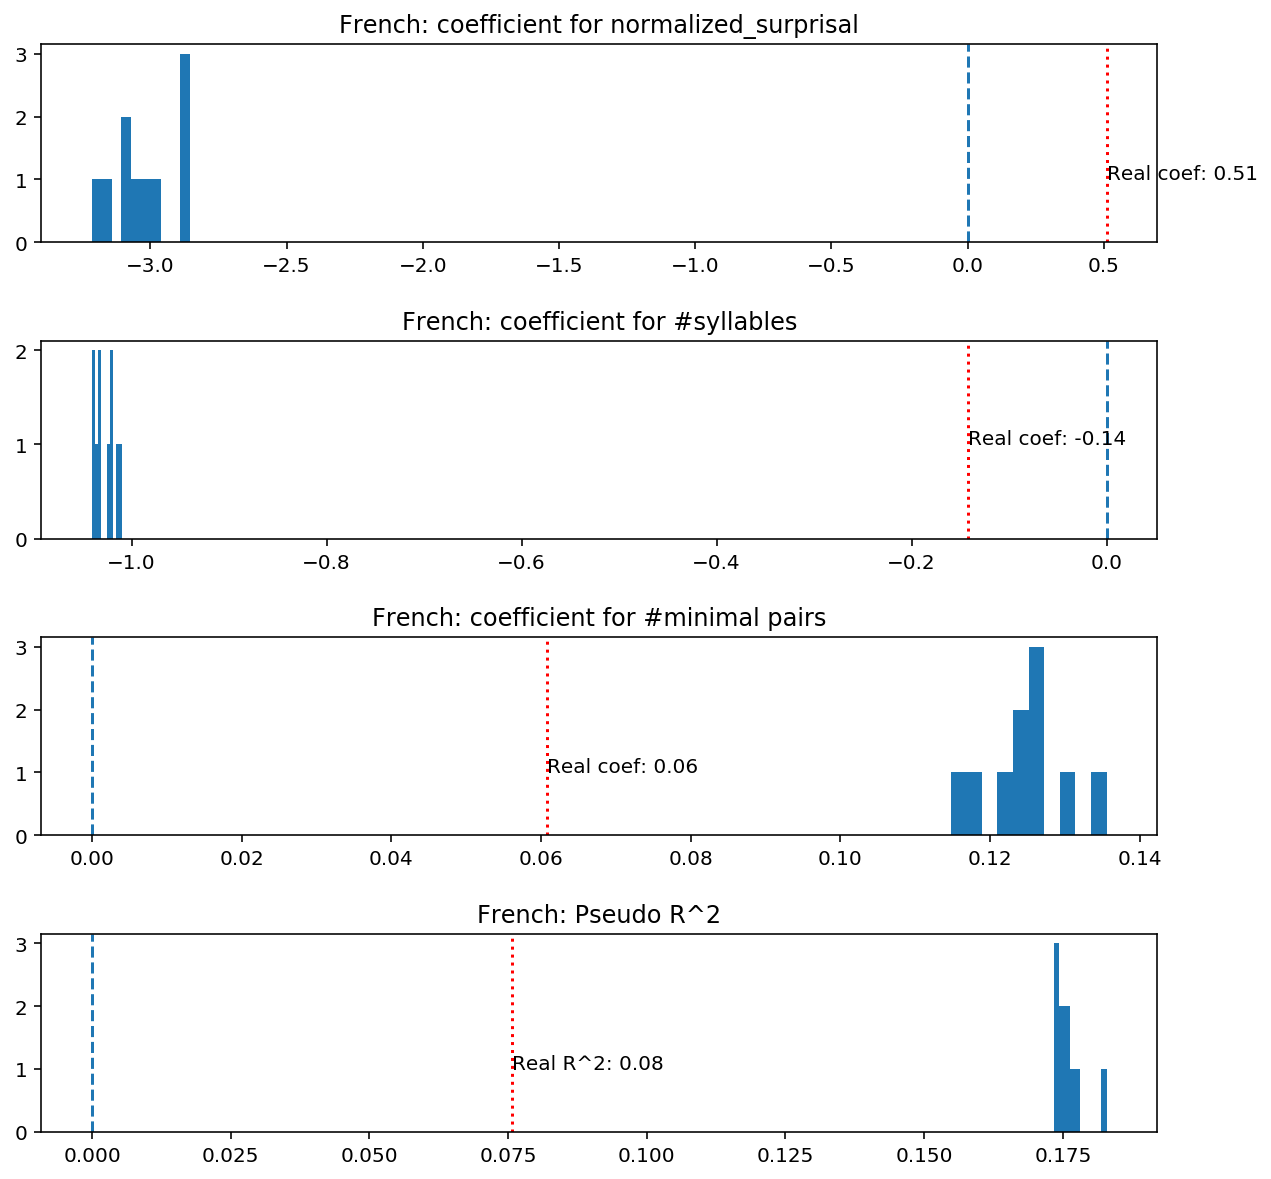

In [121]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #homophones + #syllables + surprisal
```

Mostly consistent with the above analysis in English, we find:

- The effect of **surprisal** (predicting #minimal pairs) is larger in the real lexicon than in the artificial lexicon.
- The effect of **#syllables** is larger in the artificial than real lexicon (this is distinct from the analysis in English).
- The effect of **#homophones** is larger in the real lexicon than in the artificial lexicons.

#### Analysis

In [122]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'French'

surprisal_normed

Mean of artificial: 0.5757515815549893.
Median of artificial: 0.585579433680088.
Standard deviation of artificial: 0.028647946001487005.
Range of artificial: (0.5296815159594406, 0.608385713769895).
Real value: 0.7819869656185601.
num_sylls_est

Mean of artificial: -1.0748771157837538.
Median of artificial: -1.0766565630309.
Standard deviation of artificial: 0.008261159430714572.
Range of artificial: (-1.0851835750311334, -1.0629581660135785).
Real value: -1.056848236070616.

R2
Mean of artificial: 0.39343689729065917.
Median of artificial: 0.3938385669323427.
Standard deviation of artificial: 0.004090715352586988.
Range of artificial: (0.38724144773920166, 0.40163628636222615).
Real value: 0.43666309930866243.


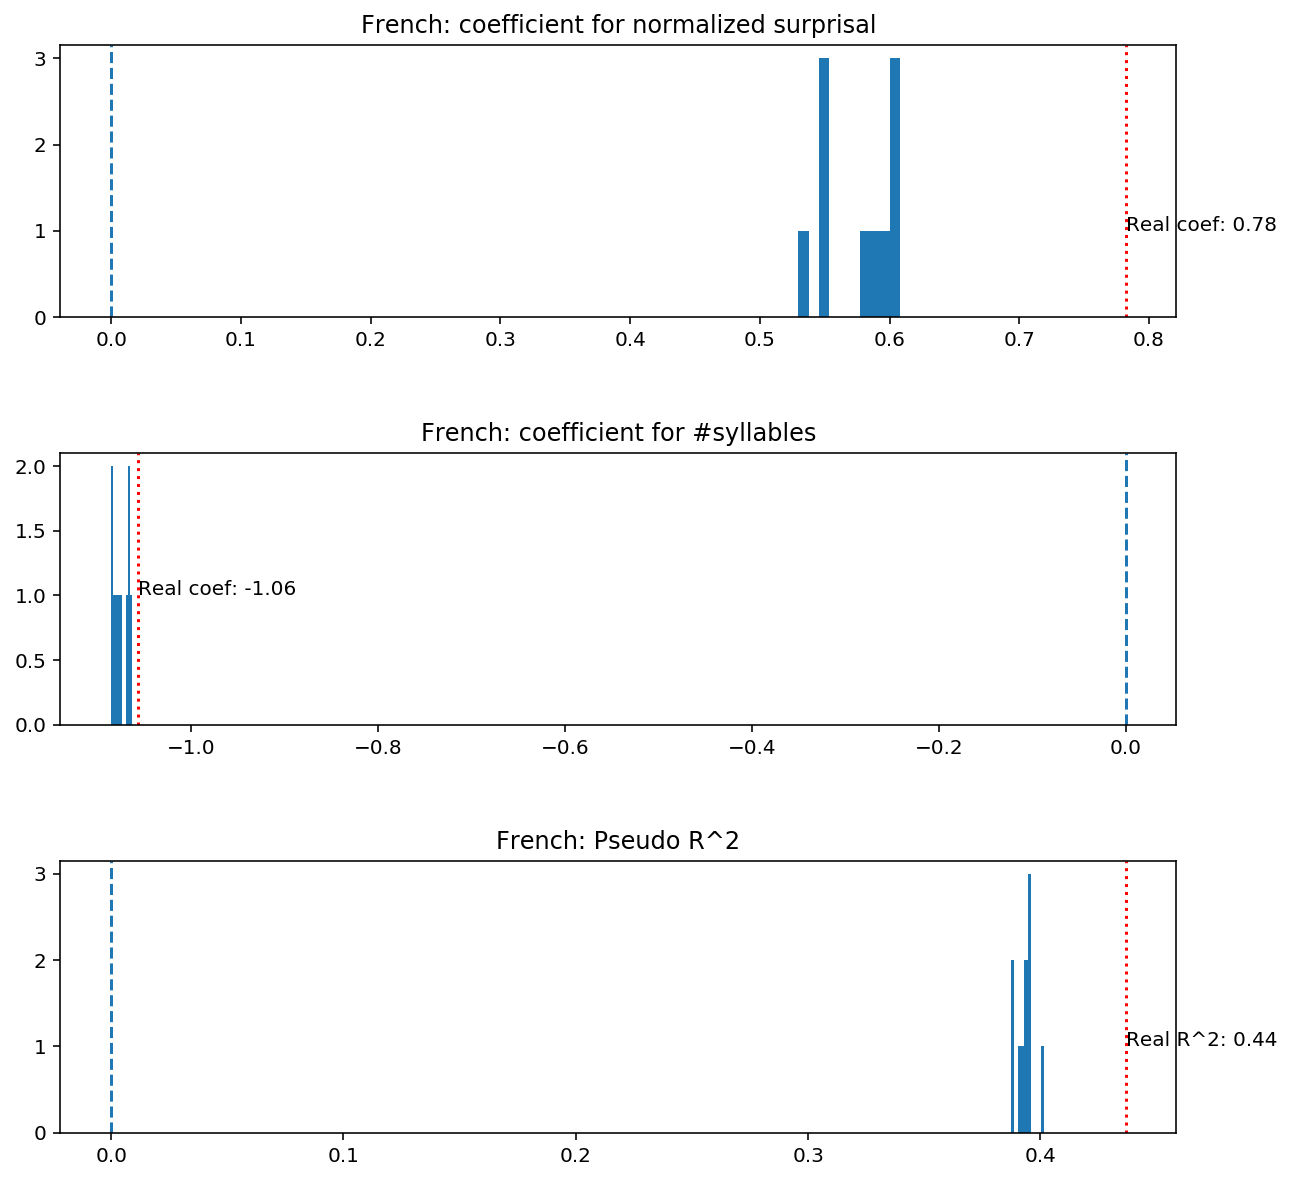

In [123]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

## Japanese

In [71]:
df_celex, df_celex_processed, df_japanese_artificials = load_lexicons_for_language("japanese", phon_column="phonetic_remapped",
                                                                                 word_column="orth_form_romaji")

In [72]:
len(df_celex)

51147

In [73]:
len(df_celex_processed)

40449

In [74]:
df_japanese_stats = get_stats_for_lexicon(df_celex_processed)
df_japanese_stats

{'homophone_percentage': 0.1506,
 'mean_homophones': 0.2645,
 'max_homophones': 33,
 'mean_mp': 4.7489,
 'max_mp': 59,
 'total_mp': 192090,
 'mean_mp_w_hp': 9.4683,
 'max_mp_w_hp': 356,
 'total_mp_w_hp': 382984}

### Preprocess artificials

In [75]:
info_for_japanese = process_and_extract_artificials(df_japanese_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [76]:
processed_artificials = info_for_japanese['processed_dataframes']

In [77]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

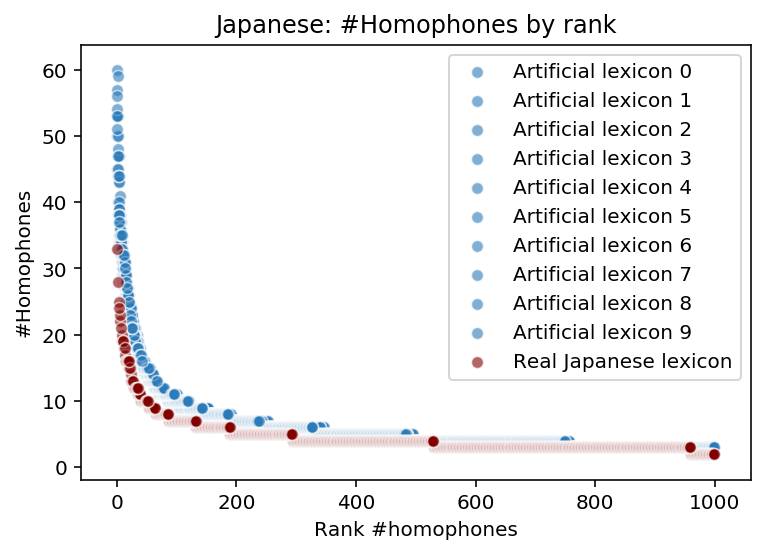

In [131]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Japanese: #Homophones by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

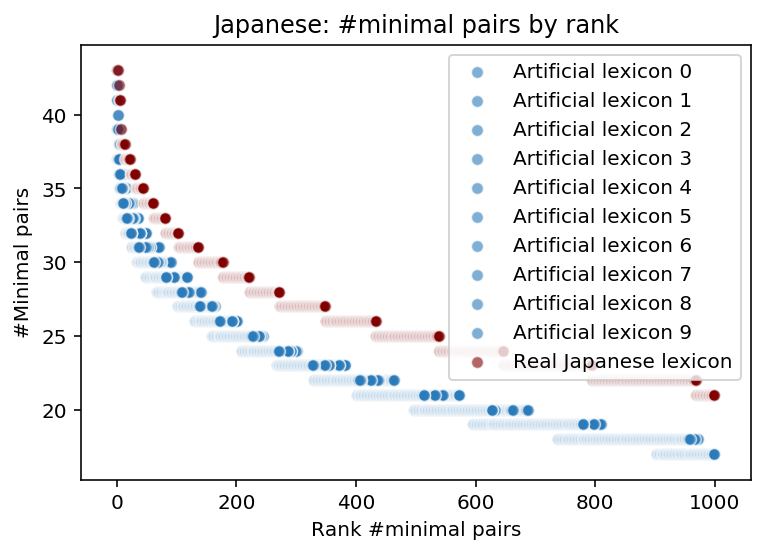

In [132]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("Japanese: #minimal pairs by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_neighborhoods.png", dpi=300)


### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

Mean of artificial: 2.8785600000000002.
Median of artificial: 2.8758999999999997.
Standard deviation of artificial: 0.02241979284273409.
Range of artificial: (2.8485, 2.9149).
Real value: 3.9055.


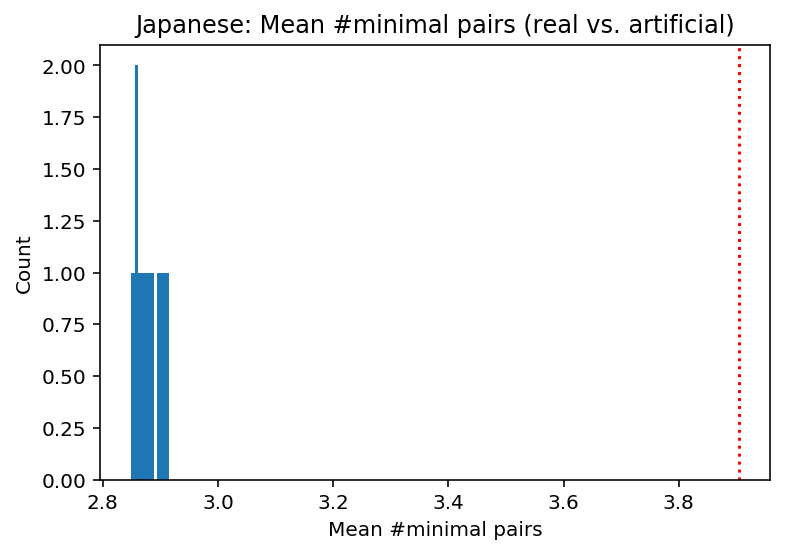

In [133]:
plot_real_vs_art(info_for_japanese['mean_mp'], df_japanese_stats['mean_mp'],
                'Mean #minimal pairs', language="Japanese")

Mean of artificial: 6.63599.
Median of artificial: 6.64255.
Standard deviation of artificial: 0.047405495462024154.
Range of artificial: (6.5453, 6.7006).
Real value: 7.6132.


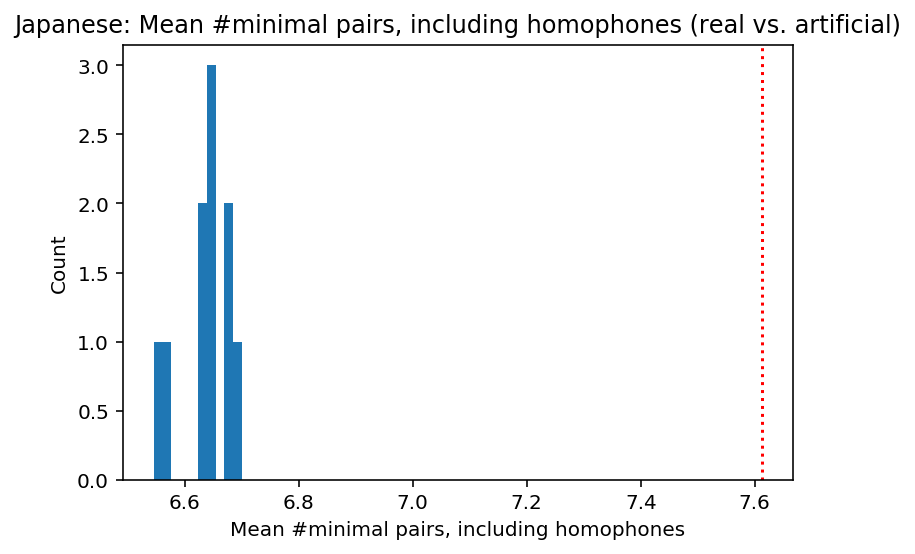

In [134]:
plot_real_vs_art(info_for_japanese['mean_mp_w_hp'], df_japanese_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="Japanese")

Mean of artificial: 40.
Median of artificial: 41.0.
Standard deviation of artificial: 1.4142135623730951.
Range of artificial: (37, 43).
Real value: 43.


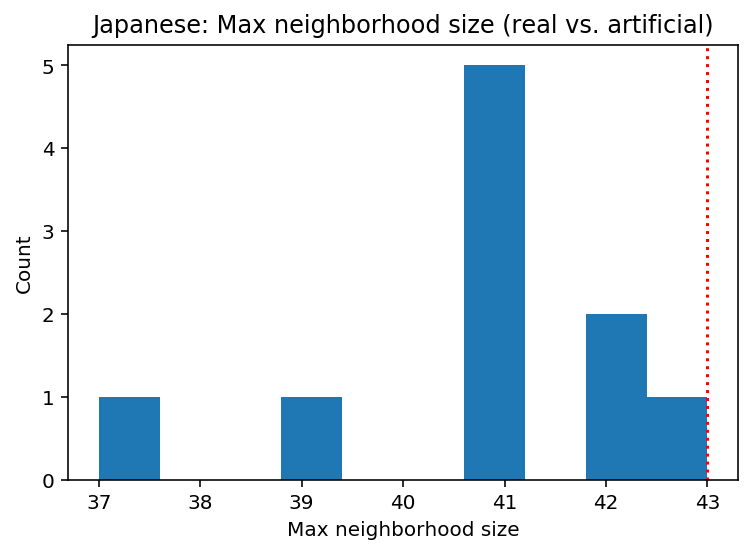

In [135]:
plot_real_vs_art(info_for_japanese['max_mp'], df_japanese_stats['max_mp'],
                'Max neighborhood size', language="Japanese")

Mean of artificial: 377.
Median of artificial: 373.5.
Standard deviation of artificial: 17.578395831246947.
Range of artificial: (357, 413).
Real value: 273.


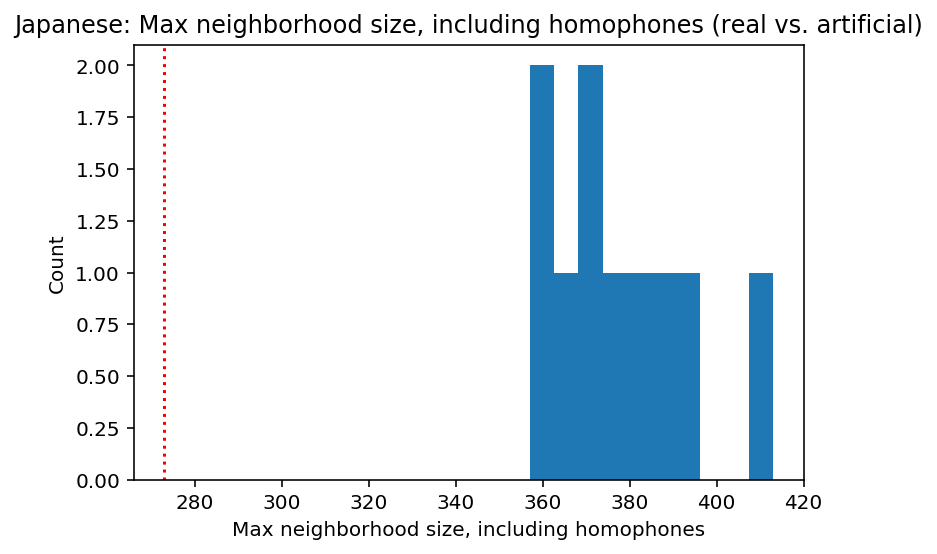

In [136]:
plot_real_vs_art(info_for_japanese['max_mp_w_hp'], df_japanese_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="Japanese")

Mean of artificial: 111800.
Median of artificial: 111659.0.
Standard deviation of artificial: 1027.6628824668137.
Range of artificial: (110216, 113386).
Real value: 157972.


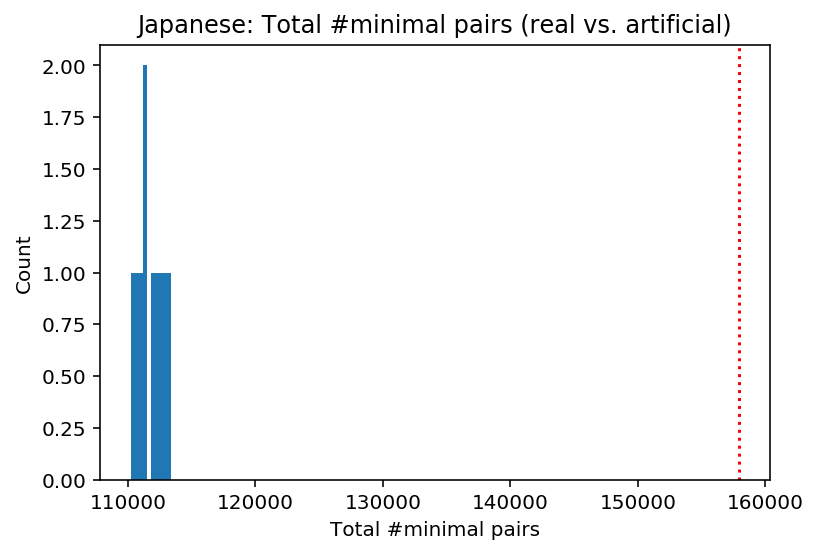

In [137]:
plot_real_vs_art(info_for_japanese['total_mp'], df_japanese_stats['total_mp'],
                'Total #minimal pairs', language='Japanese')

Mean of artificial: 257730.
Median of artificial: 257953.5.
Standard deviation of artificial: 1589.8902477844185.
Range of artificial: (254677, 260454).
Real value: 307946.


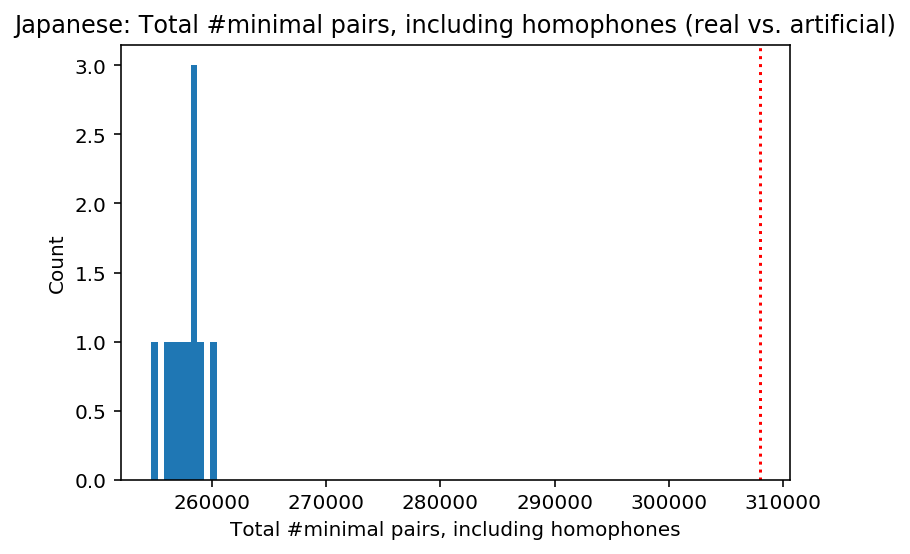

In [138]:
plot_real_vs_art(info_for_japanese['total_mp_w_hp'], df_japanese_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='Japanese')

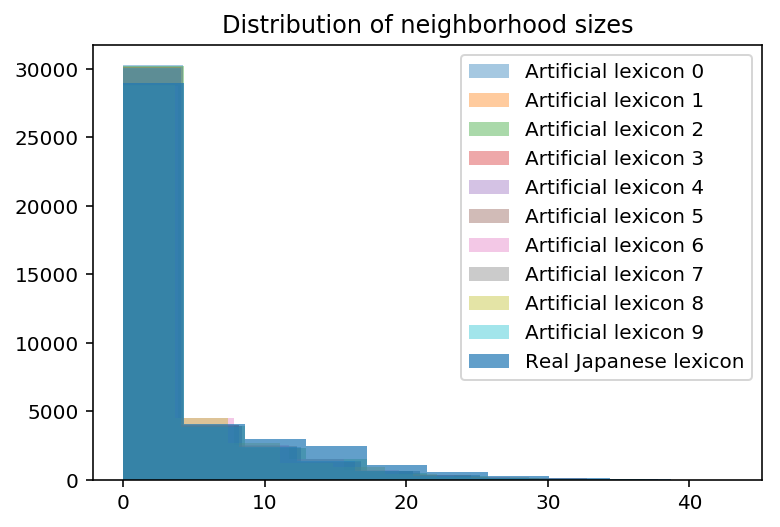

In [139]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real Japanese lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

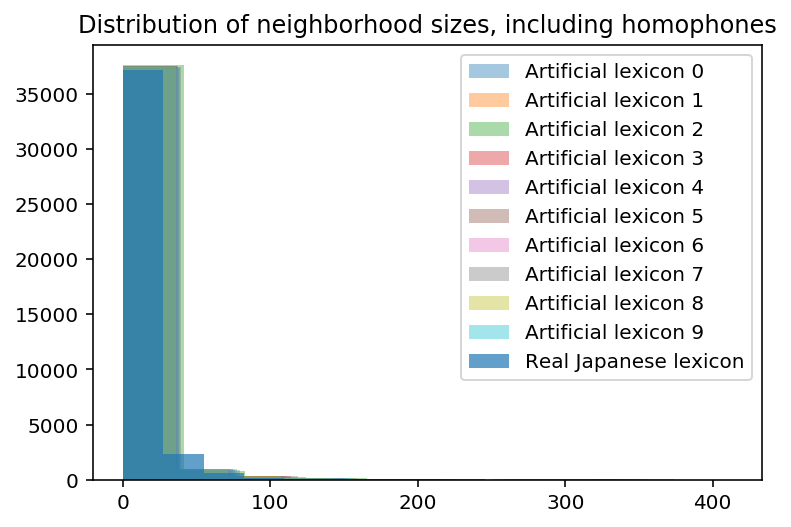

In [140]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real Japanese lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes, including homophones")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 100, in some cases) than the real lexicon (below ~30-40). There is also a higher number of *mean* homophones per word.

Mean of artificial: 0.14873999999999998.
Median of artificial: 0.14875.
Standard deviation of artificial: 0.0015079050957463392.
Range of artificial: (0.1469, 0.1512).
Real value: 0.1506.


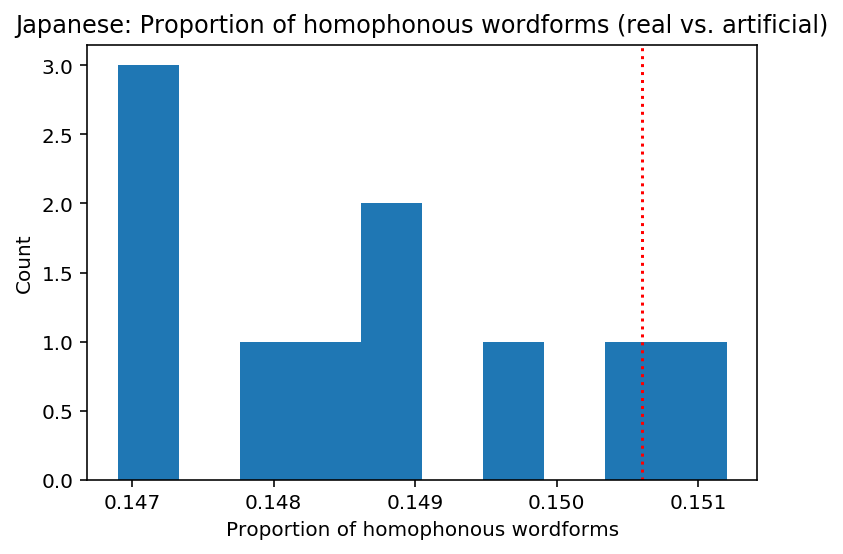

In [141]:
plot_real_vs_art(info_for_japanese['homophone_percentage'], df_japanese_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='Japanese')
plt.savefig("Figures/japanese/japanese_%_homophones.png", dpi=300)

Mean of artificial: 0.31691.
Median of artificial: 0.3158.
Standard deviation of artificial: 0.0032449790274959975.
Range of artificial: (0.3116, 0.3219).
Real value: 0.2645.


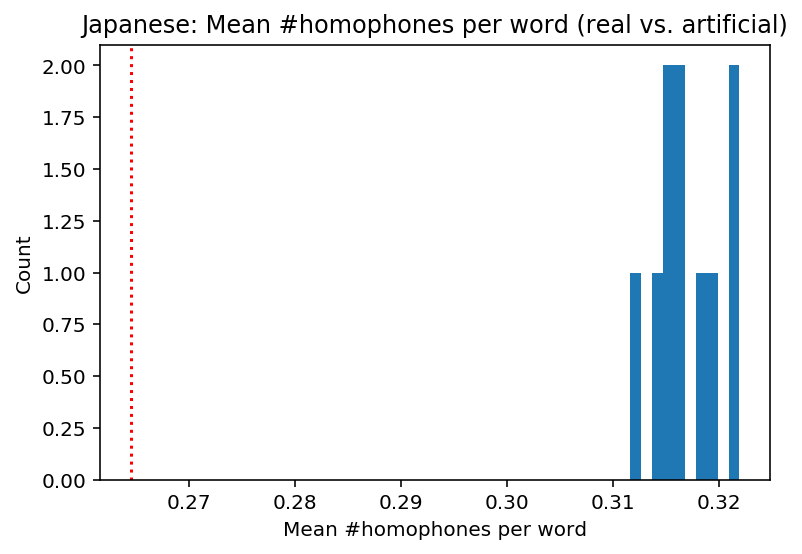

In [142]:
plot_real_vs_art(info_for_japanese['mean_homophones'], df_japanese_stats['mean_homophones'],
                'Mean #homophones per word', language='Japanese')
plt.savefig("Figures/japanese/japanese_mean_homophones.png", dpi=300)

Mean of artificial: 53.
Median of artificial: 53.0.
Standard deviation of artificial: 4.0.
Range of artificial: (45, 60).
Real value: 33.


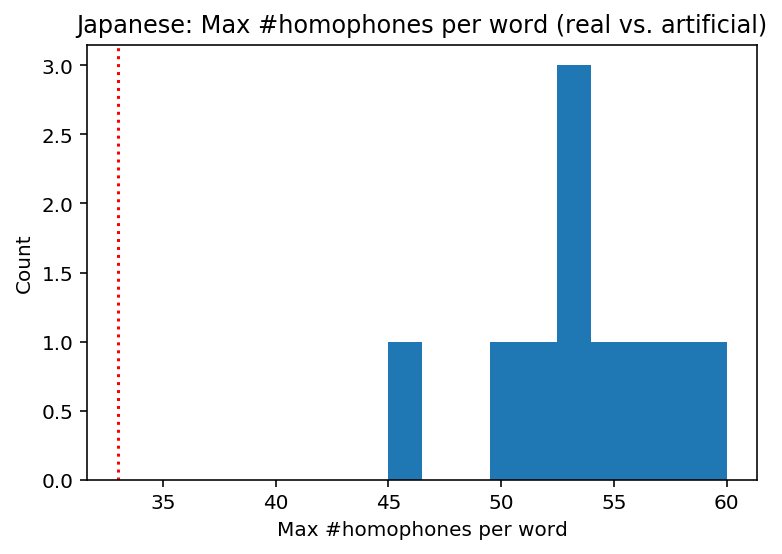

In [143]:
plot_real_vs_art(info_for_japanese['max_homophones'], df_japanese_stats['max_homophones'],
                'Max #homophones per word', language='Japanese')
plt.savefig("Figures/japanese/japanese_max_homophones.png", dpi=300)

## Statisical Analysis

### Predicting number of homophones

#### Analysis

In [23]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'Japanese'

artificial max  artificial mean  artificial median  artificial min  \
0       -3.069772        -2.859124          -2.861862       -3.069772   
1       -1.772418        -1.734732          -1.730309       -1.772418   
2        0.297294         0.301680           0.301508        0.297294   

   artificial sd  real value             value  
0       0.108190    0.347172  surprisal_normed  
1       0.025263   -0.904112     num_sylls_est  
2       0.004224    0.204174                r2

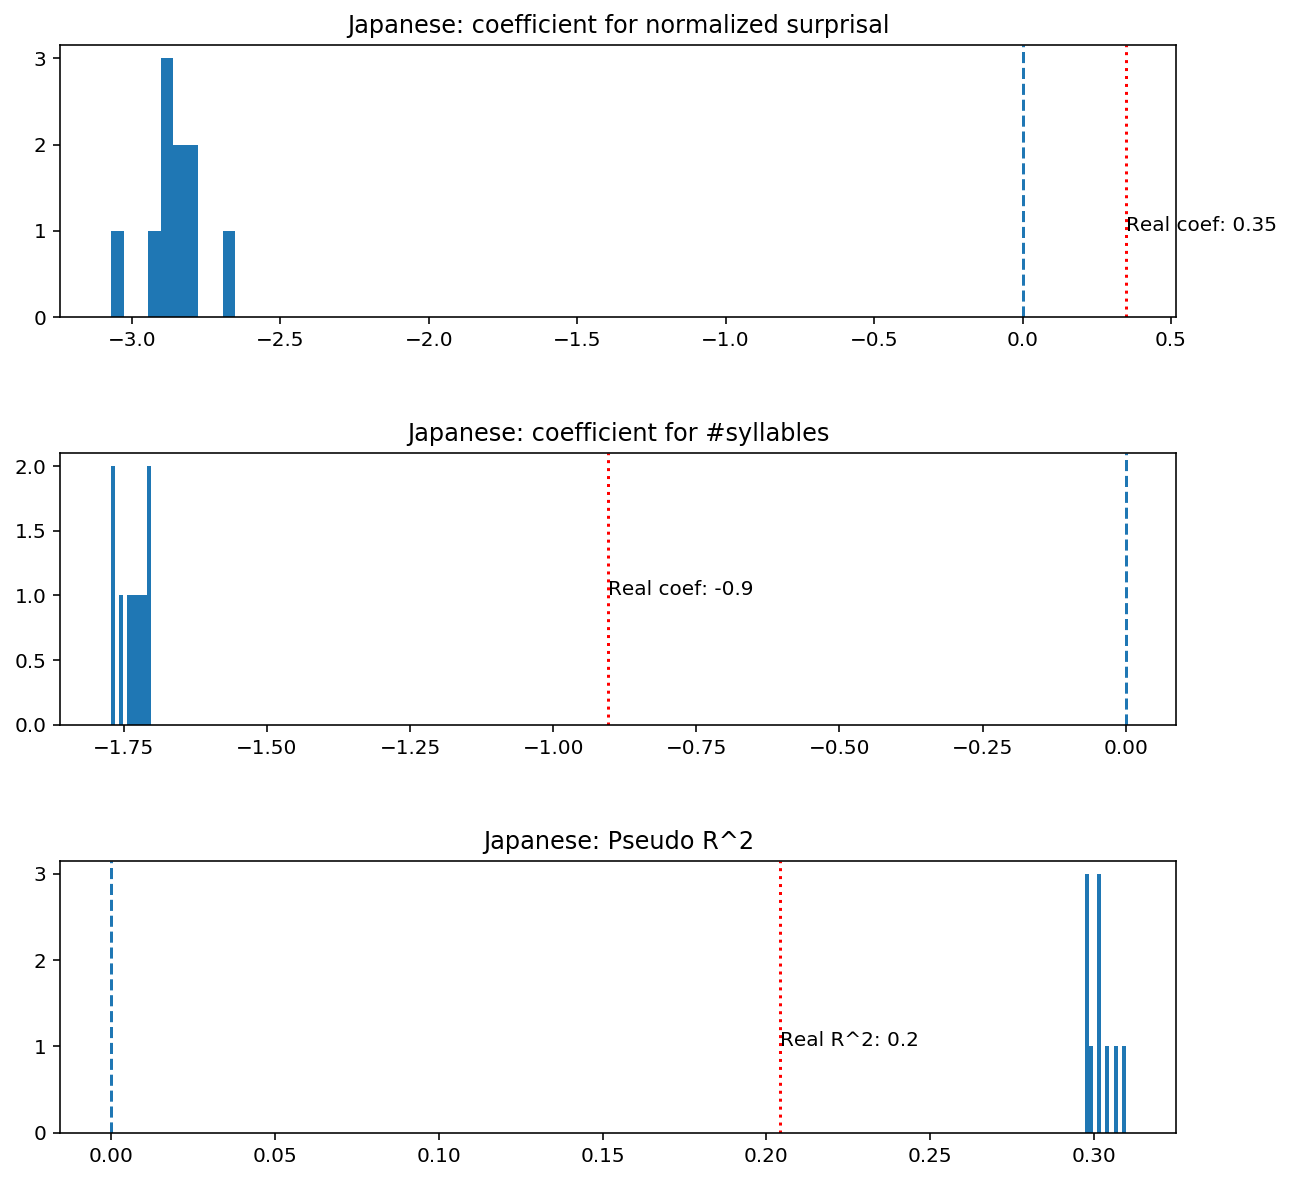

In [24]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)


In [ ]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#morae', 
    '#minimal pairs'
]
LANGUAGE = 'Japanese'

In [ ]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size

The effect of `surprisal` is larger in the **real** than **artificial** lexicons: the real Japanese lexicon appears to optimize neighborhoods more on the basis of surprisal than artificial lexicons.

The effect of `#morae` is smaller in the **real** than **artificial** lexicon: the artificial lexicons optimize neighborhoods more on the basis of word length than the real lexicon.

And the effect of `#homophones` is larger (in the expected direction) in the **real**  than the **artificial** lexicons: wordforms with more homophones also have larger neighborhoods. This isn't true in the artificial lexicon.

#### Analysis

In [78]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#morae', 
]
LANGUAGE = 'Japanese'

artificial max  artificial mean  artificial median  artificial min  \
0          -0.590           -0.538             -0.540          -0.590   
1          -1.182           -1.169             -1.169          -1.182   
2           0.481            0.488              0.488           0.481   

   artificial sd  language  real value             value  
0          0.028  Japanese      -0.246  surprisal_normed  
1          0.007  Japanese      -1.073     num_sylls_est  
2          0.003  Japanese       0.483                r2

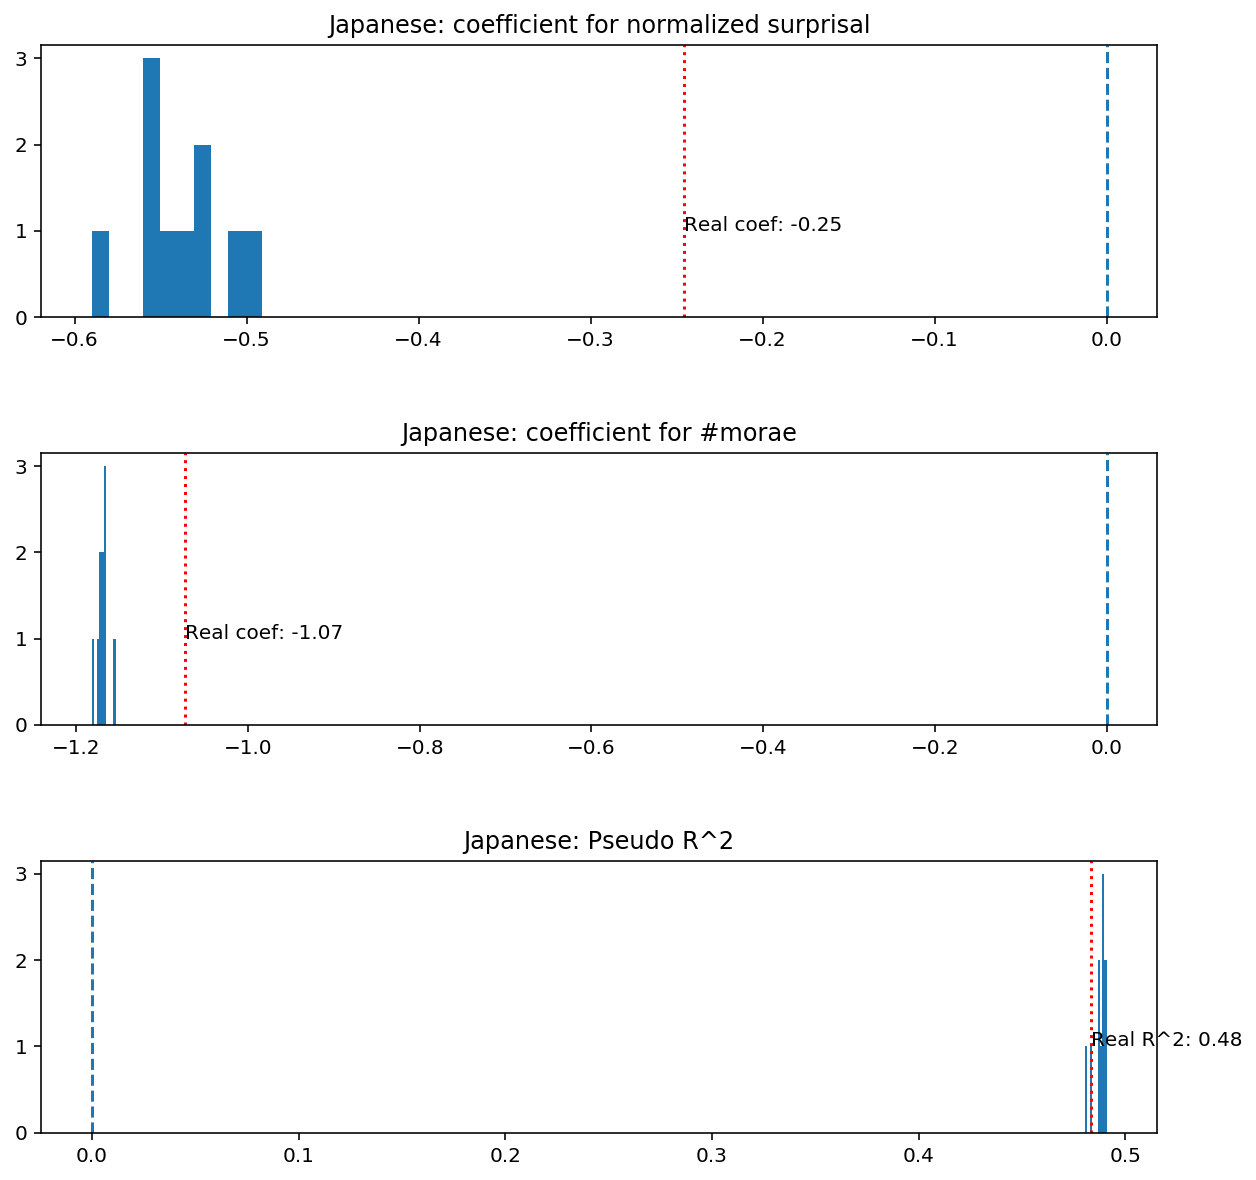

In [79]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# Concatenating all languages together

For convenience, the code below runs the primary analyses on each language to build a summary table of the main findings.

In [10]:
languages = ['english', 'german', 'dutch', 'french', 'japanese']

In [88]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

# Adding minimal pairs
TARGET_MODEL_2 = 'num_homophones'
COVARIATES_MODEL_2 = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA_MODEL_2 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_2, regressors=' + '.join(COVARIATES_MODEL_2))

# Predicting minimal pairs
TARGET_MODEL_3 = 'neighborhood_size'
COVARIATES_MODEL_3 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_3 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_3, regressors=' + '.join(COVARIATES_MODEL_3))


In [89]:
#Supplementary models: non-normed surprisal
TARGET_MODEL_4 = 'num_homophones'
COVARIATES_MODEL_4 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_4 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_4, regressors=' + '.join(COVARIATES_MODEL_4))

# Adding minimal pairs
TARGET_MODEL_5 = 'num_homophones'
COVARIATES_MODEL_5 = [
    'surprisal',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA_MODEL_5 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_5, regressors=' + '.join(COVARIATES_MODEL_5))

# Predicting minimal pairs
TARGET_MODEL_6 = 'neighborhood_size'
COVARIATES_MODEL_6 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_6 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_6, regressors=' + '.join(COVARIATES_MODEL_6))


In [91]:
model1_results, model2_results, model3_results = [], [], []
model4_results, model5_results, model6_results = [], [], []
descriptive_stats = []

for language in languages:
    print(language)
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column)

    # Process artificial lexica
    language_info = process_and_extract_artificials(df_artificials)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Create normed surprisal column
    df_processed['surprisal_normed'] = df_processed['surprisal'] / df_processed['num_phones']
    for p in processed_artificials:
        p['surprisal_normed'] = p['surprisal'] / p['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_processed)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)
    
    # Run model 2
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_2, 
                                covariates=COVARIATES_MODEL_2)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 2 data
    model2_results.append(df_analysis)

    # Run model 3
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_3, 
                                covariates=COVARIATES_MODEL_3)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 3 data
    model3_results.append(df_analysis)
    
    ##### Supplementary (non-normalized surprisal)
    
    # Run model 4
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_4, 
                                covariates=COVARIATES_MODEL_4)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 4 data
    model4_results.append(df_analysis)

    # Run model 5
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_5, 
                                covariates=COVARIATES_MODEL_5)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 5 data
    model5_results.append(df_analysis)

    # Run model 6
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_6, 
                                covariates=COVARIATES_MODEL_6)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 6 data
    model6_results.append(df_analysis)

english


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


german


100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


dutch


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


french


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


japanese


100%|██████████| 10/10 [00:07<00:00,  1.44it/s]


## Descriptive results

### Homophony

In [44]:
df_descriptive = pd.concat(descriptive_stats)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


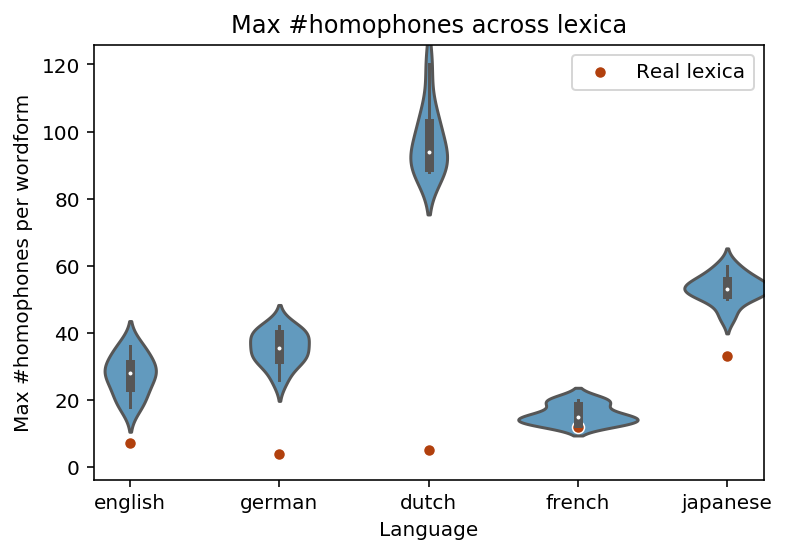

In [45]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
               label = "Simulated"
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
                   y = 'max_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Max #homophones across lexica")
plt.ylabel("Max #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/max_homophones.png", dpi=400, bbox_inches = "tight")

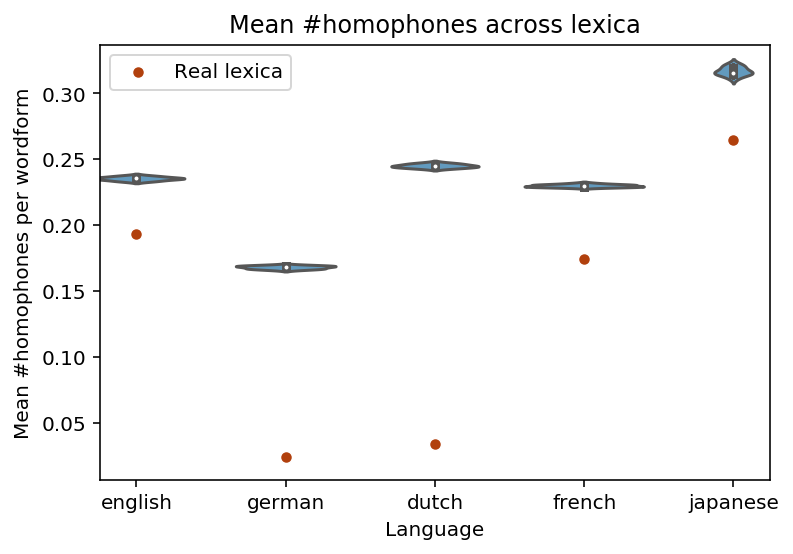

In [15]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
           y = 'mean_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Mean #homophones across lexica")
plt.ylabel("Mean #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_homophones.png", dpi=400, bbox_inches = "tight")

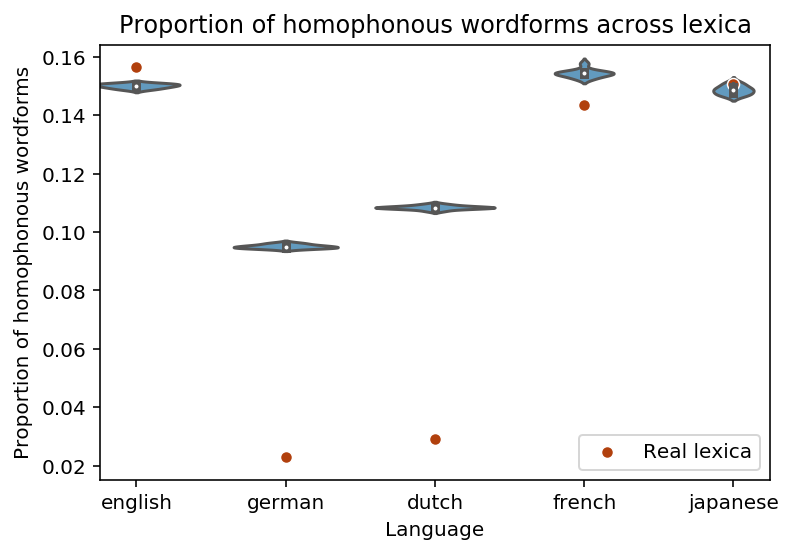

In [16]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Proportion of homophonous wordforms across lexica")
plt.ylabel("Proportion of homophonous wordforms")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/homophony_rate.png", dpi=400, bbox_inches = "tight")

### Minimal pairs

Text(0.5, 0, 'Language')

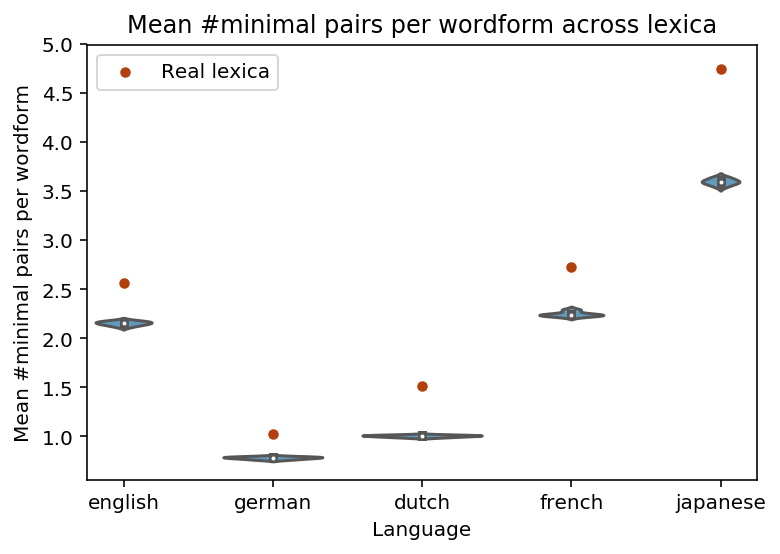

In [46]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Mean #minimal pairs per wordform across lexica")
plt.ylabel("Mean #minimal pairs per wordform")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

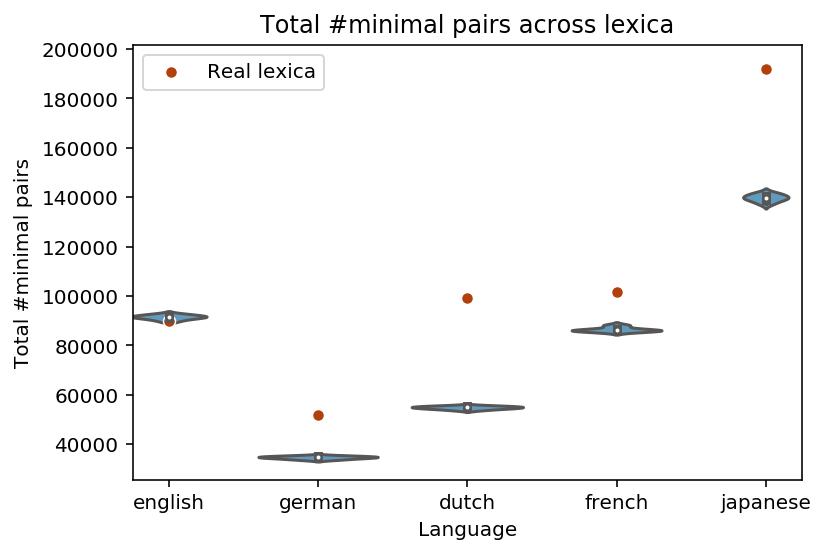

In [47]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Total #minimal pairs across lexica")
plt.ylabel("Total #minimal pairs")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

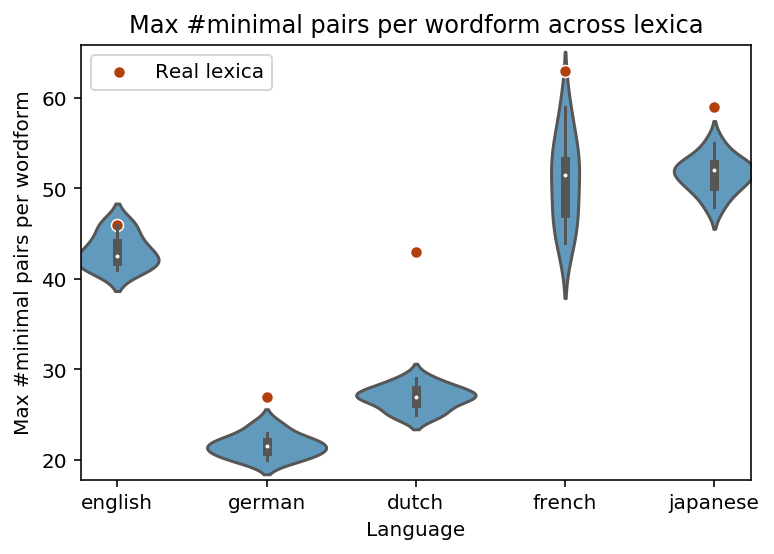

In [48]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Max #minimal pairs per wordform across lexica")
plt.ylabel("Max #minimal pairs per wordform")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

## Modeling results

### Model 1: `#homophones ~ #syllables + surprisal`

In [49]:
df_all_model1 = pd.concat(model1_results)

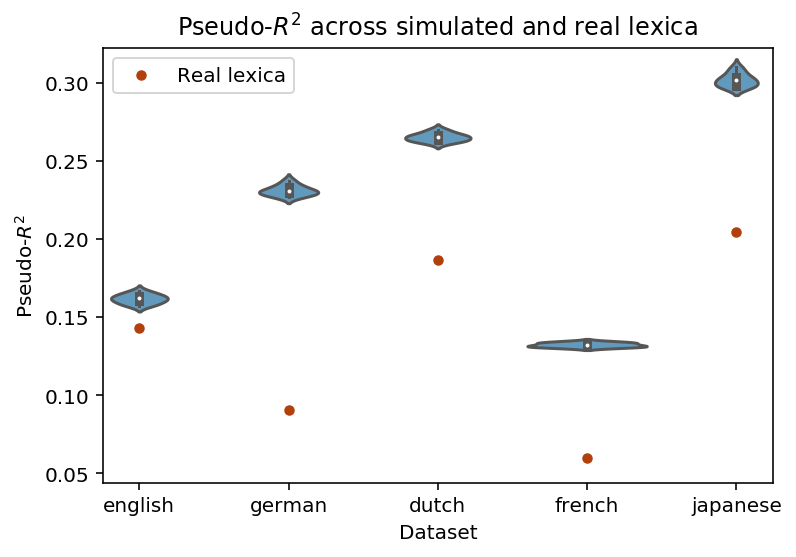

In [50]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_r2.png", dpi=400, bbox_inches = "tight")

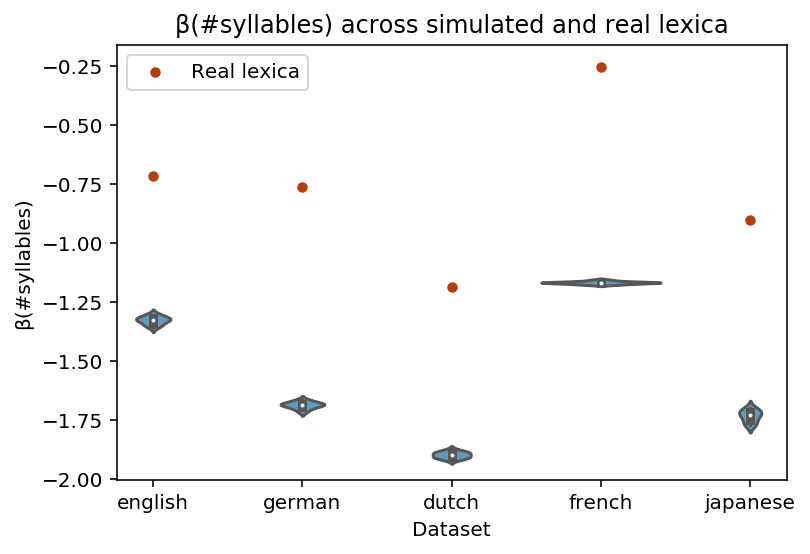

In [51]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_#sylls.png", dpi=400, bbox_inches = "tight")

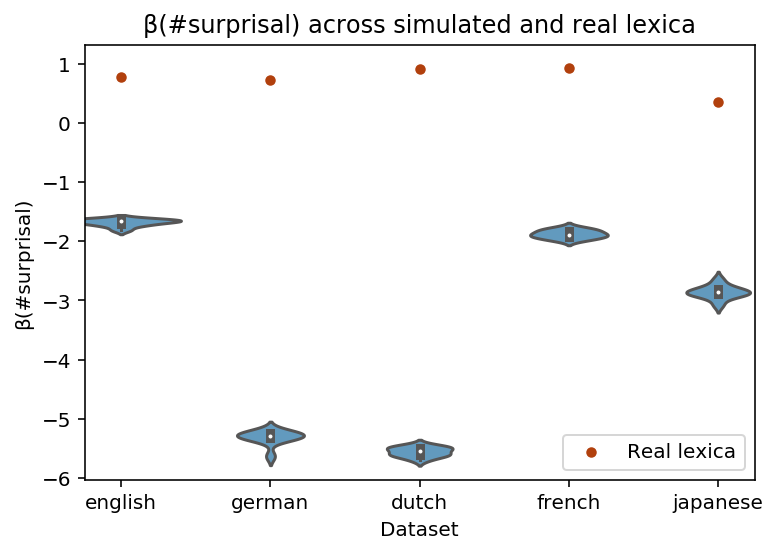

In [63]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_surprisal.png", dpi=400, bbox_inches = "tight")

### Model 2: `#homophones ~ #syllables + surprisal + #minimal pairs`

In [57]:
df_all_model2 = pd.concat(model2_results)

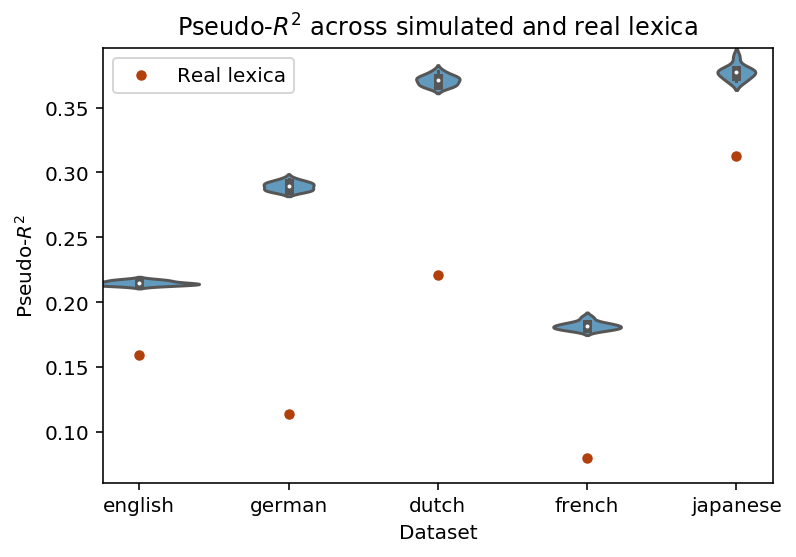

In [58]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model2_r2.png", dpi=400, bbox_inches = "tight")

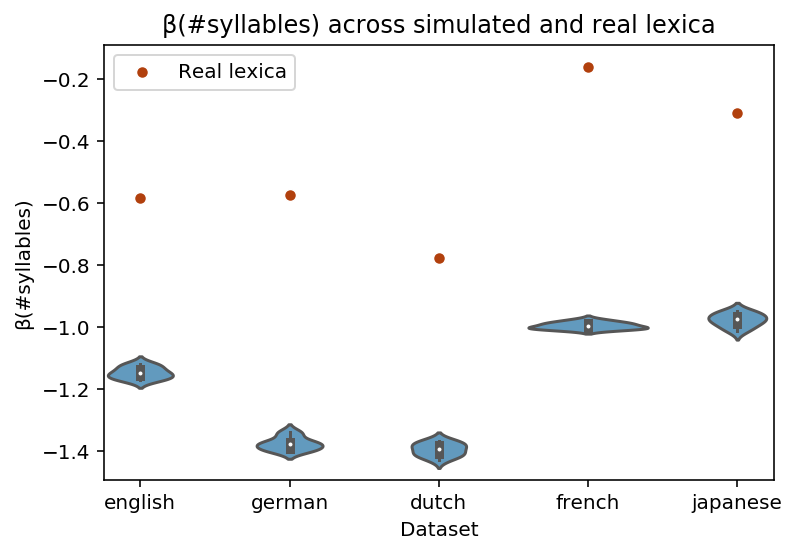

In [56]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model2_#sylls.png", dpi=400, bbox_inches = "tight")

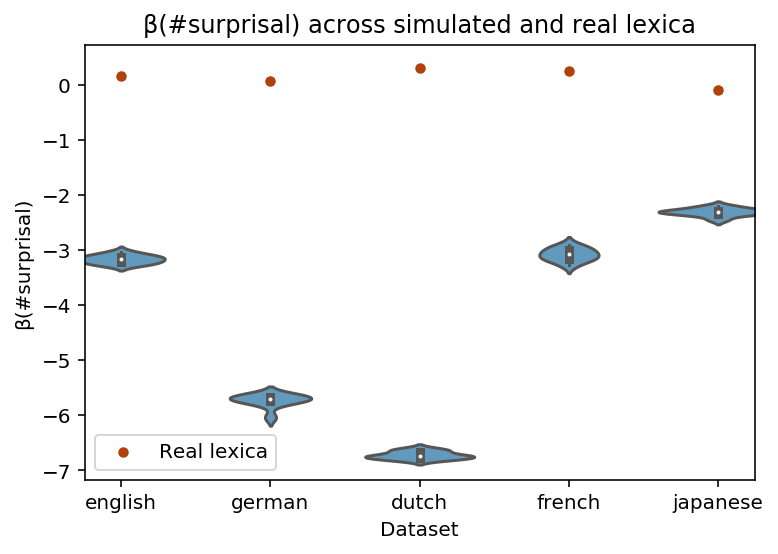

In [64]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model2_surprisal.png", dpi=400, bbox_inches = "tight")

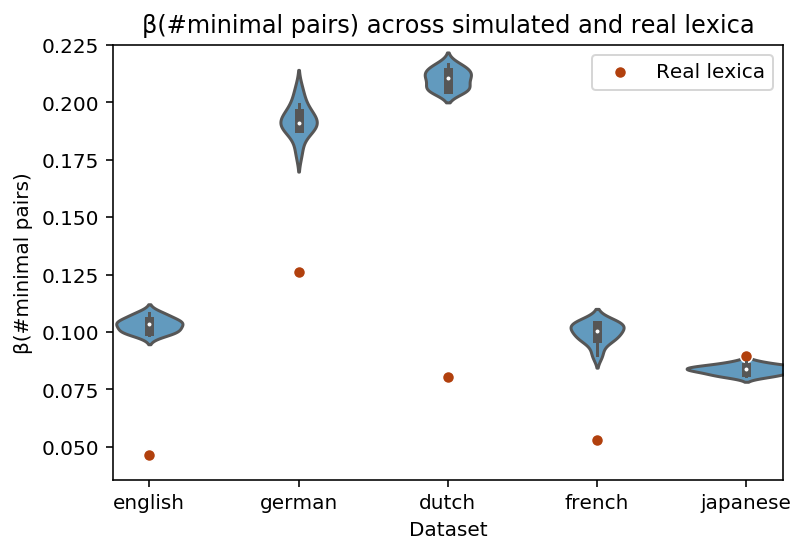

In [66]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'neighborhood_size',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'neighborhood_size',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#minimal pairs) across simulated and real lexica")
plt.ylabel("\u03B2(#minimal pairs)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model2_mps.png", dpi=400, bbox_inches = "tight")

### Model 3: `#minimal pairs ~ #syllables + surprisal`

In [67]:
df_all_model3 = pd.concat(model3_results)

Text(0.5, 0, 'Dataset')

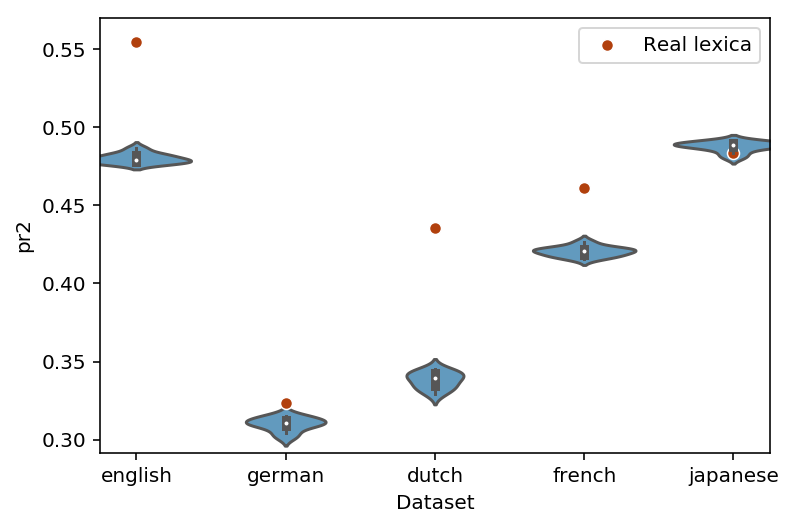

In [87]:
sns.violinplot(data = df_all_model3[df_all_model3['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model3[df_all_model3['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
# plt.title("\u03B2(#minimal pairs) across simulated and real lexica")
# plt.ylabel("\u03B2(#minimal pairs)")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/modeling/model2_mps.png", dpi=400, bbox_inches = "tight")

## Supplementary models

### Model 4: `#homophones ~ #syllables + surprisal`

In [92]:
df_all_model4 = pd.concat(model4_results)

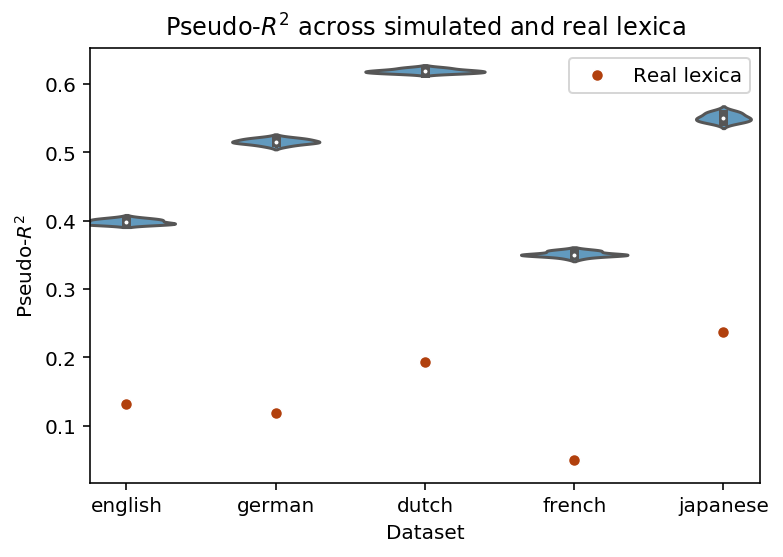

In [94]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_r2.png", dpi=400, bbox_inches = "tight")

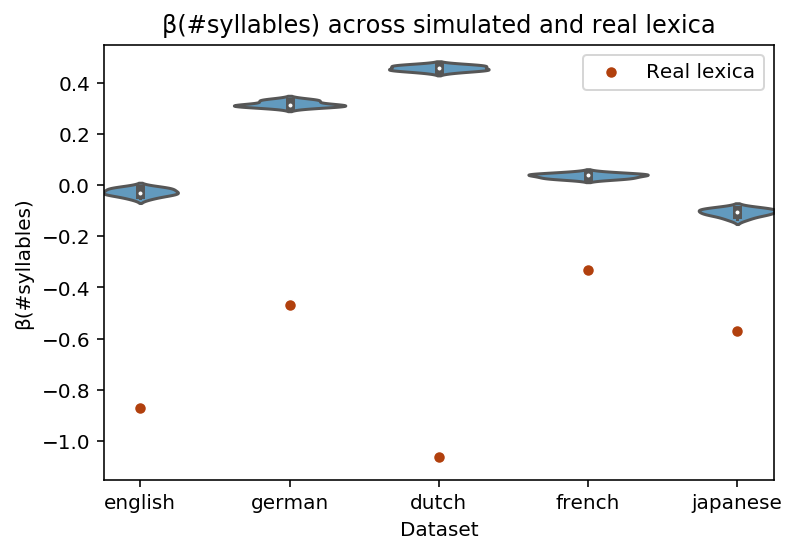

In [102]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_#sylls.png", dpi=400, bbox_inches = "tight")

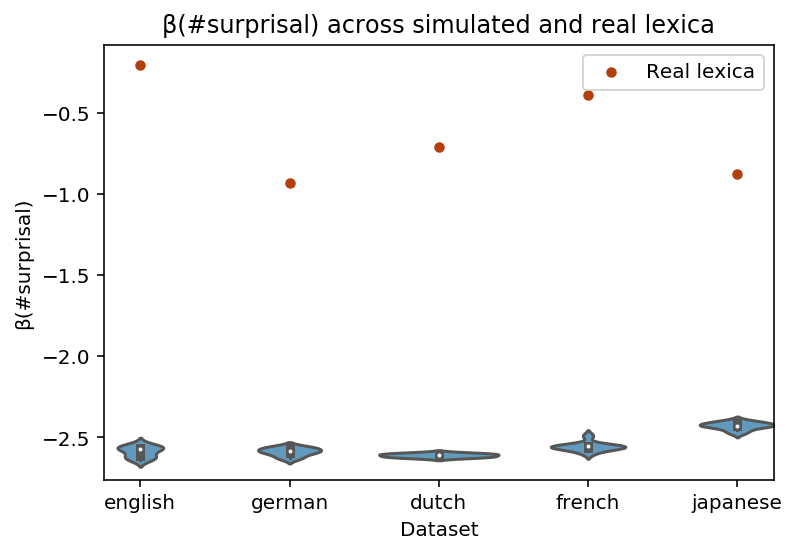

In [99]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'surprisal',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'surprisal',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_surprisal.png", dpi=400, bbox_inches = "tight")

### Model 5: `#homophones ~ #syllables + surprisal + #minimal pairs`

### Model 6: `#minimal pairs ~ #syllables + surprisal`

In [103]:
df_all_model6 = pd.concat(model6_results)

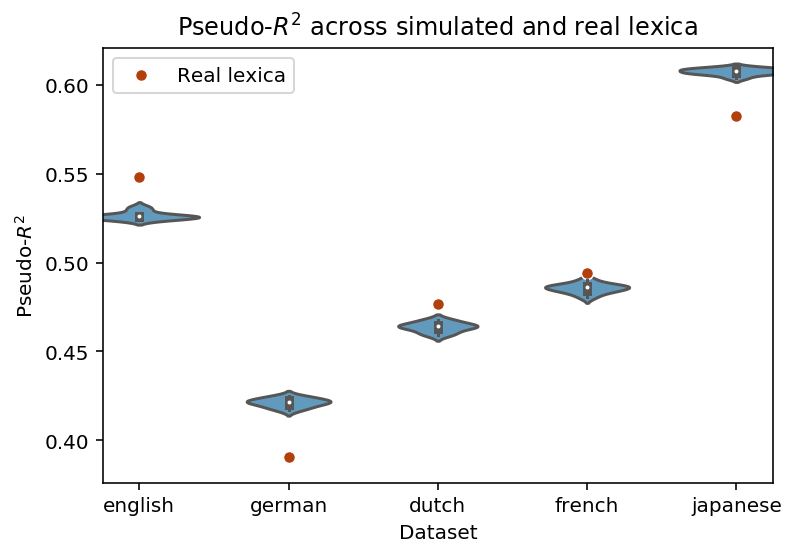

In [104]:
sns.violinplot(data = df_all_model6[df_all_model6['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model6[df_all_model6['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model6_r2.png", dpi=400, bbox_inches = "tight")

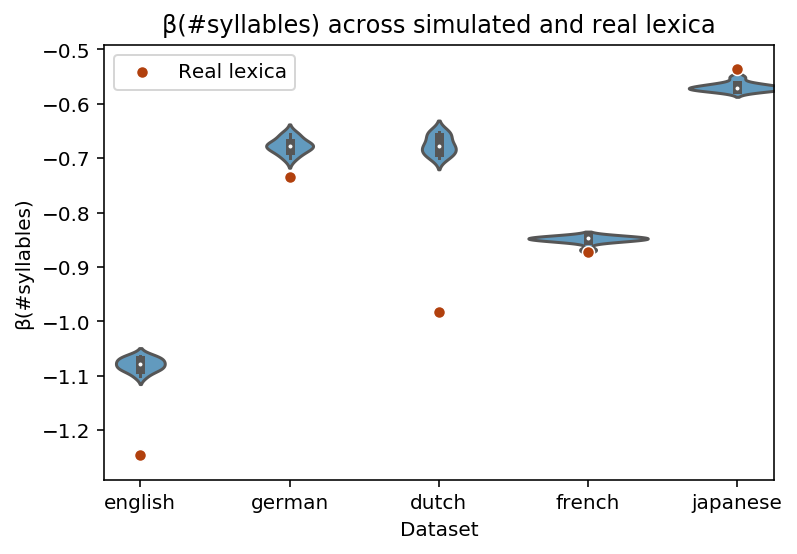

In [105]:
sns.violinplot(data = df_all_model6[df_all_model6['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model6[df_all_model6['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model6_#sylls.png", dpi=400, bbox_inches = "tight")

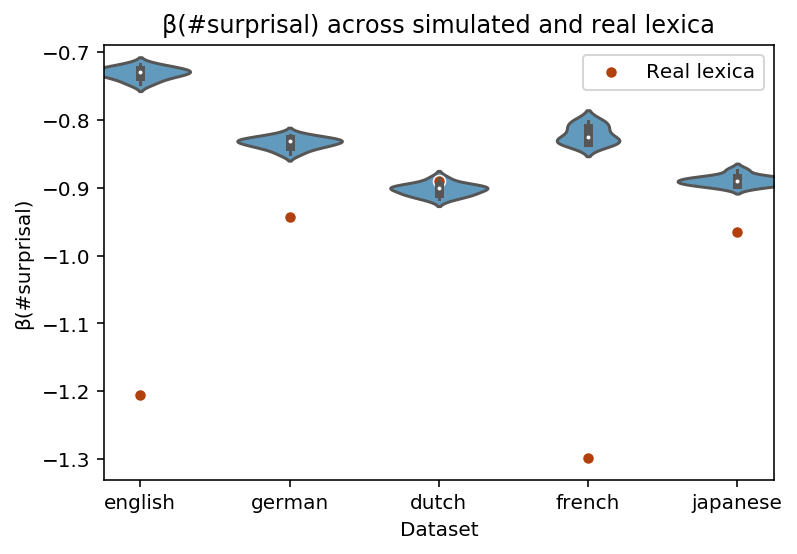

In [106]:
sns.violinplot(data = df_all_model6[df_all_model6['real']=="No"],
           x = "language",
           y = 'surprisal',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model6[df_all_model6['real']=="Yes"],
           x = "language",
           y = 'surprisal',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model6_surprisal.png", dpi=400, bbox_inches = "tight")